In [1]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from persim import PersImage
import gudhi
import os
import glob
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn import preprocessing

In [2]:
#pdlocnum has format [[birth1, persistence1, counts1],...]
#bounds should be a list [bmin,bmax,pmin,pmax]
#bins should be a list [bbins, pbins]
def PerIm(pdlocnumI,bounds,bins,stdev,res=1000):
    if pdlocnumI % 1000 == 0:
        print(pdlocnumI)
    pdlocnum = pds[pdlocnumI]
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[2], bounds[3], res)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z=np.zeros([res,res])
    for i in np.arange(len(pdlocnum)):
        z=z+pdlocnum[i][1]*pdlocnum[i][2]*np.exp((-0.5*(xx-pdlocnum[i][0])**2-0.5*(yy-pdlocnum[i][1])**2)*stdev**-2)
    return z.reshape(bins[0],res//bins[0],bins[1],res//bins[1]).sum(3).sum(1)

In [3]:
fPD1list=np.sort(glob.glob("condorSims/Dat*/*/*PD1.dat"))
TPD1list=[]
for f in fPD1list:
    if f[39]=='\\':
        TPD1list.append(float(f[36:39]))
    else:
        TPD1list.append(float(f[36:40]))

In [4]:
pds=[np.loadtxt(f) for f in fPD1list]

In [21]:
bounds=[0,25,0,25]
bins=[25,25]
res=bins[0]*10

imgs1=[PerIm(p,bounds,bins,1,res=res) for p in np.arange(len(pds))]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000


In [ ]:
t=50000
pd=pds[t]
bounds=[0,10,0,10]
bins=[10,10]
res=bins[0]*10

stdev=1

x = np.linspace(bounds[0], bounds[1], res)
y = np.linspace(bounds[2], bounds[3], res)
xx, yy = np.meshgrid(x, y, sparse=True)
z=np.zeros([res,res])
for i in np.arange(len(pd)):
    z=z+pd[i][1]*pd[i][2]*np.exp((-0.5*(xx-pd[i][0])**2-0.5*(yy-pd[i][1])**2)*stdev**-2)

plt.figure(figsize=(6,6))
plt.scatter(pd[:,0],pd[:,1],c='k')
plt.xlabel('b')
plt.ylabel('p')
plt.show()

plt.imshow(z,origin='lower')
plt.axis('off')
plt.show()

plt.imshow(PerIm(t,bounds,bins,stdev=stdev,res=res).reshape(bins),origin='lower')
plt.axis('off')
plt.show()

In [22]:
imgs1_array=np.array([img.flatten() for img in imgs1])

In [23]:
imgs1_scaled=preprocessing.scale(imgs1_array)

In [24]:
labels=[int(t<2.519) for t in TPD1list]

In [25]:
(np.shape(imgs1_array), np.shape(TPD1list), np.shape(labels))

((71210, 625), (71210,), (71210,))

In [26]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(imgs1_scaled, labels, TPD1list, test_size=0.5)

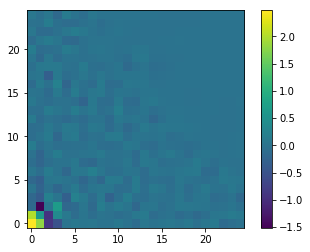

In [27]:
logreg = LogisticRegression(C=0.1, solver='liblinear', penalty='l2')
logreg.fit(X_train, y_train)

inverse_image = np.copy(logreg.coef_).reshape((25,25))
fig, ax = plt.subplots()
cs = ax.imshow(inverse_image, origin='lower')
cbar = fig.colorbar(cs)

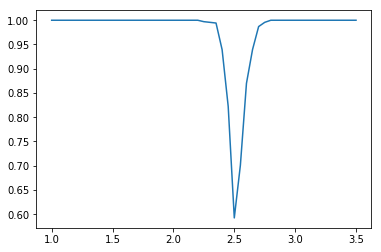

In [28]:
pred = logreg.predict(X_test)
diff = abs(pred-y_test)
TT = np.arange(1.0,3.51,0.05)
TT = np.round(TT, decimals=3)
avg = np.zeros(len(TT))
acc = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])
    acc[i] = np.mean(1-diff[np.where(T_test==TT[i])[0]])

plt.plot(TT, acc)

2.5


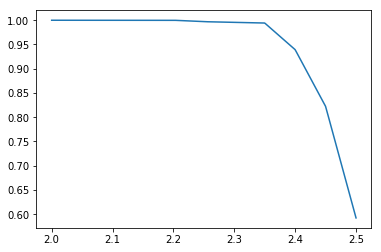

In [29]:
tRange = np.linspace(2,2.5,500)
interps = np.interp(tRange, TT, avg)

Tc = tRange[abs(interps-0.5).argmin()]

print(Tc)
plt.plot(tRange, interps)

In [30]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

2.0


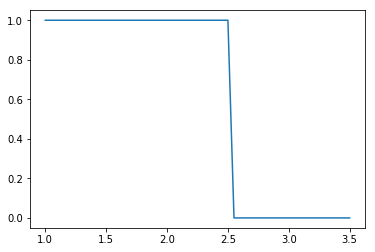

In [31]:
pred = kmeans.predict(X_test)
diff = abs(pred-y_test)
TT = np.arange(1.0,3.51,0.05)
TT = np.round(TT, decimals=3)
acc = np.zeros(len(TT))
avg = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])
    acc[i] = np.mean(diff[np.where(T_test==TT[i])[0]])

plt.plot(TT, acc)

tRange = np.linspace(2,2.5,500)
interp = np.interp(tRange, TT, avg)

Tc = tRange[abs(interp-0.5).argmin()]
print(Tc)

In [32]:
pca = PCA(n_components=2)
X_r = pca.fit(imgs1_array).transform(imgs1_array)

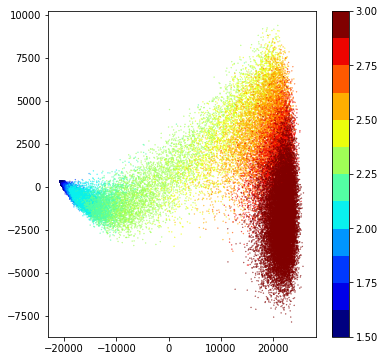

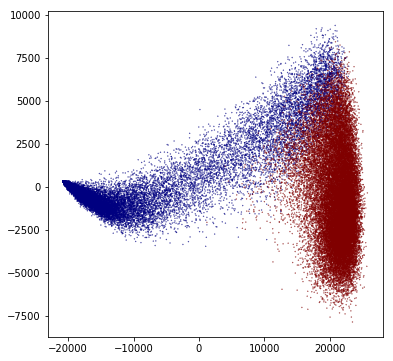

In [33]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1.5,3.5,13)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],c=TPD1list,s=0.1,cmap=cmap, norm=norm)
cbar = fig.colorbar(scat)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,1,3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],c=[1-l for l in labels],s=0.1,cmap=cmap, norm=norm)
plt.show()

**Power Law from PI**

In [466]:
def func(r, a, xi, c):
    return c - r/xi - a * np.log(r)

In [467]:
def getDensParams(im):
    dens=np.zeros(25)
    for r in np.arange(len(dens)):
        for j in range(r+1):
            for k in range(r-j,25):
                dens[r] += im[j][k]
#             dens[r] += im[j][r-j]
    ydata=np.log(dens)[10:]
    rdata=np.arange(len(dens))[10:]
    fit=curve_fit(func, rdata, ydata)[0]
#     plt.scatter(rdata,ydata)
#     rRange=np.linspace(1,25,100)
#     plt.plot(rRange,[func(rRange[i],fit[0],fit[1],fit[2]) for i in range(len(rRange))])
    
    return fit

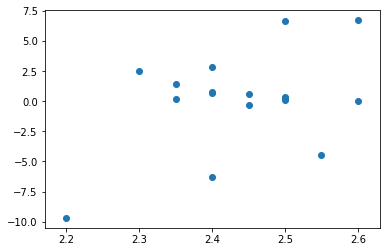

In [478]:
rng=np.arange(0,len(imgs1),100)
params=np.array([getDensParams(imgs1[i]) for i in rng])
temps=np.array([TPD1list[i] for i in rng])

indices=np.where(params[:,1]>10000)[0]
plt.scatter(temps[indices],params[indices,0])

**H0 Classification**

In [18]:
#pdlocnum has format [[birth1, persistence1, counts1],...]
#bounds should be a list [pmin,pmax]
#bins should be pbins
def PerIm0(pdlocnum,bounds,bins,stdev,res=1000):
    if len(np.shape(pdlocnum))==1:
        pdlocnum = np.array([pdlocnum])
    
    y = np.linspace(bounds[0], bounds[1], res)
    z=np.zeros(res)
    for i in np.arange(len(pdlocnum)):
        z=z+np.log(1+pdlocnum[i][1])*pdlocnum[i][2]*np.exp((-0.5*(y-pdlocnum[i][1])**2)*stdev**-2)
    return z.reshape(bins,res//bins).sum(1)

In [4]:
fPD0list=np.sort(glob.glob("condorSims/Dat*/*/*PD0.dat"))
TPD0list=[]
for f in fPD0list:
    if f[39]=='\\':
        TPD0list.append(float(f[36:39]))
    else:
        TPD0list.append(float(f[36:40]))

In [5]:
pds0=[np.loadtxt(f) for f in fPD0list]

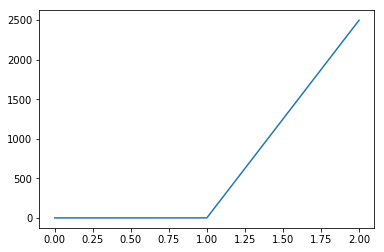

In [6]:
plt.plot(pds0[0])

In [21]:
bounds=[0,25]
bins=25
res=bins*10

imgs0 = [PerIm0(p,bounds,bins,1,res=res) for p in pds0]

In [22]:
imgs0_scaled=preprocessing.scale(imgs0)

In [418]:
labels0=[int(t<2.269) for t in TPD0list]

In [24]:
(np.shape(imgs0_scaled), np.shape(TPD0list), np.shape(labels0))

((71210, 25), (71210,), (71210,))

In [276]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(imgs0_scaled, labels, TPD0list, test_size=0.50)

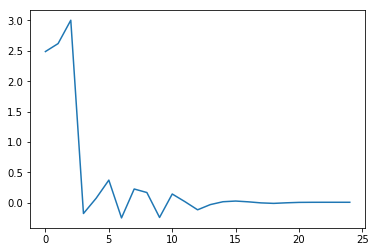

In [287]:
logreg = LogisticRegression(C=0.1, solver='liblinear', penalty='l2')
logreg.fit(X_train, y_train)

inverse_image = np.copy(logreg.coef_)
plt.plot(inverse_image[0])

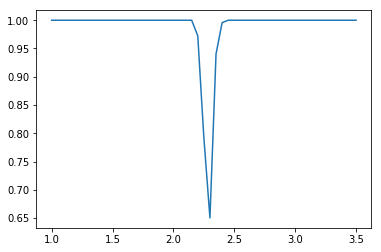

In [288]:
pred = logreg.predict(X_test)
diff = abs(pred-y_test)
TT = np.arange(1.0,3.51,0.05)
TT = np.round(TT, decimals=3)
avg = np.zeros(len(TT))
acc = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])
    acc[i] = np.mean(1-diff[np.where(T_test==TT[i])[0]])

plt.plot(TT, acc)

2.282565130260521


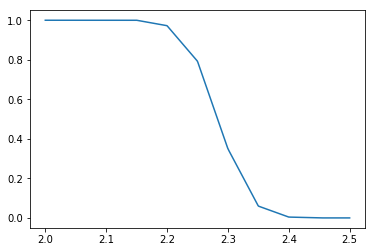

In [289]:
tRange = np.linspace(2,2.5,500)
interps = np.interp(tRange, TT, avg)

Tc = tRange[abs(interps-0.5).argmin()]

print(Tc)
plt.plot(tRange, interps)

In [290]:
kmeans = KMeans(n_clusters=2, random_state=10).fit(X_train)

2.3266533066132267


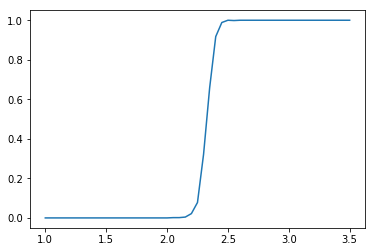

In [291]:
pred = kmeans.predict(X_test)
TT = np.arange(1.0,3.51,0.05)
TT = np.round(TT, decimals=3)
avg = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])

plt.plot(TT, avg)

tRange = np.linspace(2,2.5,500)
interp = np.interp(tRange, TT, avg)

Tc = tRange[abs(interp-0.5).argmin()]
print(Tc)

In [285]:
pca = PCA(n_components=2)
X_r = pca.fit(imgs0).transform(imgs0)

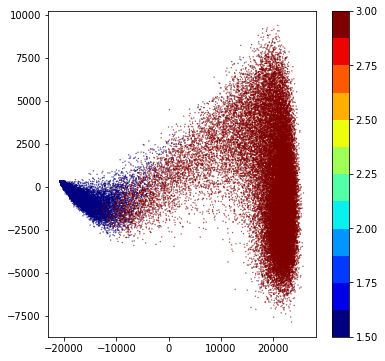

In [426]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1.5,3,13)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],c=[3-1.5*l for l in labels],s=0.1,cmap=cmap, norm=norm)
cbar = fig.colorbar(scat)
plt.show()

**Criticality**

In [13]:
flist=np.sort(glob.glob("2d_Ising_Fine/*/*.txt"))

In [15]:
for f in flist:
    t0 = time.time()
    data = np.loadtxt(f, dtype=int)
    alpha_complex=gudhi.AlphaComplex(data)
    simplex_tree=alpha_complex.create_simplex_tree()
    PD=simplex_tree.persistence()
    PD0=[]
    PD1=[]
    for elm in PD:
        if elm[0]==1:
            PD1.append((elm[1][0],elm[1][1]-elm[1][0]))
        else:
            if elm[1][1]!=float('inf'):
                PD0.append((elm[1][0],elm[1][1]-elm[1][0]))
    PD0=np.round(PD0,decimals=5)
    PD1=np.round(PD1,decimals=5)
    loc,counts=np.unique(PD0,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD0.dat",toSave)
    loc,counts=np.unique(PD1,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD1.dat",toSave)
    print(f, time.time() - t0)

2d_Ising_Fine\2.302\1557256085.txt 0.40096163749694824
2d_Ising_Fine\2.302\1557256101.txt 0.4039316177368164
2d_Ising_Fine\2.302\1557256118.txt 0.32013893127441406
2d_Ising_Fine\2.302\1557256135.txt 0.2922677993774414
2d_Ising_Fine\2.302\1557256153.txt 0.361034631729126
2d_Ising_Fine\2.302\1557256171.txt 0.34906625747680664
2d_Ising_Fine\2.302\1557256189.txt 0.3904252052307129
2d_Ising_Fine\2.302\1557256206.txt 0.3629939556121826
2d_Ising_Fine\2.302\1557256224.txt 0.46140146255493164
2d_Ising_Fine\2.302\1557256241.txt 0.3630685806274414
2d_Ising_Fine\2.302\1557256258.txt 0.3730323314666748
2d_Ising_Fine\2.302\1557256274.txt 0.36100316047668457
2d_Ising_Fine\2.302\1557256292.txt 0.3899228572845459
2d_Ising_Fine\2.302\1557256309.txt 0.35800838470458984
2d_Ising_Fine\2.302\1557256326.txt 0.3979349136352539
2d_Ising_Fine\2.302\1557256343.txt 0.6809606552124023
2d_Ising_Fine\2.302\1557256360.txt 0.40491700172424316
2d_Ising_Fine\2.302\1557256377.txt 0.3759942054748535
2d_Ising_Fine\2.302\15

2d_Ising_Fine\2.302\1557258610.txt 0.3280787467956543
2d_Ising_Fine\2.302\1557258627.txt 0.2958054542541504
2d_Ising_Fine\2.302\1557258642.txt 0.32033801078796387
2d_Ising_Fine\2.302\1557258658.txt 0.32811570167541504
2d_Ising_Fine\2.302\1557258676.txt 0.4103538990020752
2d_Ising_Fine\2.302\1557258693.txt 0.3688690662384033
2d_Ising_Fine\2.302\1557258709.txt 0.32360148429870605
2d_Ising_Fine\2.302\1557258725.txt 0.3983275890350342
2d_Ising_Fine\2.302\1557258741.txt 0.31864500045776367
2d_Ising_Fine\2.302\1557258758.txt 0.37387585639953613
2d_Ising_Fine\2.302\1557258775.txt 0.4158284664154053
2d_Ising_Fine\2.302\1557258791.txt 0.3073709011077881
2d_Ising_Fine\2.302\1557258807.txt 0.3554718494415283
2d_Ising_Fine\2.302\1557258823.txt 0.38802051544189453
2d_Ising_Fine\2.302\1557258840.txt 0.37498021125793457
2d_Ising_Fine\2.302\1557258858.txt 0.38668203353881836
2d_Ising_Fine\2.302\1557258874.txt 0.33150362968444824
2d_Ising_Fine\2.302\1557258891.txt 0.3124985694885254
2d_Ising_Fine\2.302

2d_Ising_Fine\2.302\1557261085.txt 0.3357243537902832
2d_Ising_Fine\2.302\1557261100.txt 0.3820078372955322
2d_Ising_Fine\2.302\1557261117.txt 0.39136719703674316
2d_Ising_Fine\2.302\1557261133.txt 0.3800802230834961
2d_Ising_Fine\2.302\1557261149.txt 0.34689807891845703
2d_Ising_Fine\2.302\1557261165.txt 0.3448445796966553
2d_Ising_Fine\2.302\1557261181.txt 0.22403335571289062
2d_Ising_Fine\2.302\1557261197.txt 0.35930800437927246
2d_Ising_Fine\2.302\1557261213.txt 0.36095738410949707
2d_Ising_Fine\2.302\1557261229.txt 0.3351116180419922
2d_Ising_Fine\2.302\1557261246.txt 0.39572691917419434
2d_Ising_Fine\2.302\1557261260.txt 0.336336612701416
2d_Ising_Fine\2.302\1557261276.txt 0.3919849395751953
2d_Ising_Fine\2.302\1557261291.txt 0.27925634384155273
2d_Ising_Fine\2.302\1557261307.txt 0.34105467796325684
2d_Ising_Fine\2.302\1557261324.txt 0.19960498809814453
2d_Ising_Fine\2.302\1557261340.txt 0.27808260917663574
2d_Ising_Fine\2.302\1557261355.txt 0.3162055015563965
2d_Ising_Fine\2.302

2d_Ising_Fine\2.302\1557263512.txt 0.29421520233154297
2d_Ising_Fine\2.302\1557263527.txt 0.26328253746032715
2d_Ising_Fine\2.302\1557263543.txt 0.34404516220092773
2d_Ising_Fine\2.302\1557263559.txt 0.3372609615325928
2d_Ising_Fine\2.302\1557263576.txt 0.4717381000518799
2d_Ising_Fine\2.302\1557263592.txt 0.35325145721435547
2d_Ising_Fine\2.302\1557263610.txt 0.3860056400299072
2d_Ising_Fine\2.302\1557263626.txt 0.3206040859222412
2d_Ising_Fine\2.302\1557263643.txt 0.38995933532714844
2d_Ising_Fine\2.302\1557263659.txt 0.36857056617736816
2d_Ising_Fine\2.302\1557263675.txt 0.3500642776489258
2d_Ising_Fine\2.302\1557263692.txt 0.3332679271697998
2d_Ising_Fine\2.302\1557263707.txt 0.35302233695983887
2d_Ising_Fine\2.302\1557263723.txt 0.33742332458496094
2d_Ising_Fine\2.302\1557263739.txt 0.3979346752166748
2d_Ising_Fine\2.302\1557263755.txt 0.4228699207305908
2d_Ising_Fine\2.302\1557263771.txt 0.37400317192077637
2d_Ising_Fine\2.302\1557263788.txt 0.4039173126220703
2d_Ising_Fine\2.302

2d_Ising_Fine\2.304\1557257801.txt 0.2892277240753174
2d_Ising_Fine\2.304\1557257818.txt 0.34209227561950684
2d_Ising_Fine\2.304\1557257834.txt 0.3789799213409424
2d_Ising_Fine\2.304\1557257851.txt 0.3389747142791748
2d_Ising_Fine\2.304\1557257867.txt 0.3798079490661621
2d_Ising_Fine\2.304\1557257884.txt 0.35309696197509766
2d_Ising_Fine\2.304\1557257902.txt 0.34205126762390137
2d_Ising_Fine\2.304\1557257919.txt 0.3271522521972656
2d_Ising_Fine\2.304\1557257935.txt 0.3729686737060547
2d_Ising_Fine\2.304\1557257952.txt 0.38400959968566895
2d_Ising_Fine\2.304\1557257969.txt 0.39394497871398926
2d_Ising_Fine\2.304\1557257986.txt 0.3391892910003662
2d_Ising_Fine\2.304\1557258003.txt 0.2922184467315674
2d_Ising_Fine\2.304\1557258020.txt 0.33710336685180664
2d_Ising_Fine\2.304\1557258037.txt 0.365703821182251
2d_Ising_Fine\2.304\1557258052.txt 0.2244422435760498
2d_Ising_Fine\2.304\1557258070.txt 0.33307313919067383
2d_Ising_Fine\2.304\1557258085.txt 0.3220682144165039
2d_Ising_Fine\2.304\15

2d_Ising_Fine\2.304\1557260333.txt 0.2672138214111328
2d_Ising_Fine\2.304\1557260349.txt 0.36302876472473145
2d_Ising_Fine\2.304\1557260366.txt 0.24840569496154785
2d_Ising_Fine\2.304\1557260382.txt 0.3769948482513428
2d_Ising_Fine\2.304\1557260398.txt 0.3450753688812256
2d_Ising_Fine\2.304\1557260414.txt 0.3680155277252197
2d_Ising_Fine\2.304\1557260431.txt 0.34508395195007324
2d_Ising_Fine\2.304\1557260447.txt 0.3101639747619629
2d_Ising_Fine\2.304\1557260463.txt 0.3720064163208008
2d_Ising_Fine\2.304\1557260479.txt 0.3281214237213135
2d_Ising_Fine\2.304\1557260495.txt 0.2682175636291504
2d_Ising_Fine\2.304\1557260512.txt 0.38105130195617676
2d_Ising_Fine\2.304\1557260529.txt 0.35903239250183105
2d_Ising_Fine\2.304\1557260544.txt 0.2981414794921875
2d_Ising_Fine\2.304\1557260561.txt 0.3531303405761719
2d_Ising_Fine\2.304\1557260578.txt 0.3939392566680908
2d_Ising_Fine\2.304\1557260594.txt 0.35704684257507324
2d_Ising_Fine\2.304\1557260611.txt 0.3899557590484619
2d_Ising_Fine\2.304\15

2d_Ising_Fine\2.304\1557262823.txt 0.3779904842376709
2d_Ising_Fine\2.304\1557262838.txt 0.3390932083129883
2d_Ising_Fine\2.304\1557262854.txt 0.35808253288269043
2d_Ising_Fine\2.304\1557262870.txt 0.3730952739715576
2d_Ising_Fine\2.304\1557262886.txt 0.3839757442474365
2d_Ising_Fine\2.304\1557262902.txt 0.3939476013183594
2d_Ising_Fine\2.304\1557262918.txt 0.31109619140625
2d_Ising_Fine\2.304\1557262934.txt 0.2833118438720703
2d_Ising_Fine\2.304\1557262950.txt 0.3480687141418457
2d_Ising_Fine\2.304\1557262966.txt 0.2682840824127197
2d_Ising_Fine\2.304\1557262982.txt 0.38691234588623047
2d_Ising_Fine\2.304\1557262998.txt 0.3869485855102539
2d_Ising_Fine\2.304\1557263013.txt 0.37507200241088867
2d_Ising_Fine\2.304\1557263028.txt 0.2792479991912842
2d_Ising_Fine\2.304\1557263045.txt 0.37698960304260254
2d_Ising_Fine\2.304\1557263060.txt 0.38995790481567383
2d_Ising_Fine\2.304\1557263076.txt 0.31711459159851074
2d_Ising_Fine\2.304\1557263094.txt 0.3042271137237549
2d_Ising_Fine\2.304\1557

2d_Ising_Fine\2.306\1557256989.txt 0.362032413482666
2d_Ising_Fine\2.306\1557257006.txt 0.2952115535736084
2d_Ising_Fine\2.306\1557257021.txt 0.391951322555542
2d_Ising_Fine\2.306\1557257037.txt 0.36003732681274414
2d_Ising_Fine\2.306\1557257053.txt 0.36801671981811523
2d_Ising_Fine\2.306\1557257069.txt 0.35405588150024414
2d_Ising_Fine\2.306\1557257085.txt 0.3031890392303467
2d_Ising_Fine\2.306\1557257100.txt 0.3321096897125244
2d_Ising_Fine\2.306\1557257116.txt 0.34607744216918945
2d_Ising_Fine\2.306\1557257133.txt 0.34208106994628906
2d_Ising_Fine\2.306\1557257148.txt 0.370941162109375
2d_Ising_Fine\2.306\1557257164.txt 0.3222081661224365
2d_Ising_Fine\2.306\1557257181.txt 0.34108638763427734
2d_Ising_Fine\2.306\1557257197.txt 0.382976770401001
2d_Ising_Fine\2.306\1557257213.txt 0.3580057621002197
2d_Ising_Fine\2.306\1557257229.txt 0.388002872467041
2d_Ising_Fine\2.306\1557257244.txt 0.28417229652404785
2d_Ising_Fine\2.306\1557257261.txt 0.32619643211364746
2d_Ising_Fine\2.306\15572

2d_Ising_Fine\2.306\1557259431.txt 0.3800525665283203
2d_Ising_Fine\2.306\1557259446.txt 0.32007861137390137
2d_Ising_Fine\2.306\1557259461.txt 0.2733335494995117
2d_Ising_Fine\2.306\1557259476.txt 0.3889613151550293
2d_Ising_Fine\2.306\1557259493.txt 0.3939483165740967
2d_Ising_Fine\2.306\1557259511.txt 0.3769857883453369
2d_Ising_Fine\2.306\1557259527.txt 0.3530564308166504
2d_Ising_Fine\2.306\1557259543.txt 0.3061819076538086
2d_Ising_Fine\2.306\1557259560.txt 0.36086273193359375
2d_Ising_Fine\2.306\1557259578.txt 0.3071110248565674
2d_Ising_Fine\2.306\1557259595.txt 0.29319024085998535
2d_Ising_Fine\2.306\1557259611.txt 0.2683422565460205
2d_Ising_Fine\2.306\1557259626.txt 0.328122615814209
2d_Ising_Fine\2.306\1557259642.txt 0.23038935661315918
2d_Ising_Fine\2.306\1557259657.txt 0.3510572910308838
2d_Ising_Fine\2.306\1557259674.txt 0.3530592918395996
2d_Ising_Fine\2.306\1557259689.txt 0.3261239528656006
2d_Ising_Fine\2.306\1557259704.txt 0.39295148849487305
2d_Ising_Fine\2.306\1557

2d_Ising_Fine\2.306\1557261868.txt 0.29022884368896484
2d_Ising_Fine\2.306\1557261883.txt 0.3350956439971924
2d_Ising_Fine\2.306\1557261900.txt 0.33510470390319824
2d_Ising_Fine\2.306\1557261916.txt 0.38796281814575195
2d_Ising_Fine\2.306\1557261933.txt 0.38297414779663086
2d_Ising_Fine\2.306\1557261949.txt 0.33809924125671387
2d_Ising_Fine\2.306\1557261965.txt 0.26329612731933594
2d_Ising_Fine\2.306\1557261980.txt 0.42885422706604004
2d_Ising_Fine\2.306\1557261996.txt 0.3570108413696289
2d_Ising_Fine\2.306\1557262011.txt 0.3400557041168213
2d_Ising_Fine\2.306\1557262028.txt 0.34415268898010254
2d_Ising_Fine\2.306\1557262043.txt 0.2922182083129883
2d_Ising_Fine\2.306\1557262058.txt 0.3420844078063965
2d_Ising_Fine\2.306\1557262072.txt 0.3440113067626953
2d_Ising_Fine\2.306\1557262087.txt 0.3171532154083252
2d_Ising_Fine\2.306\1557262102.txt 0.3420531749725342
2d_Ising_Fine\2.306\1557262119.txt 0.2383279800415039
2d_Ising_Fine\2.306\1557262134.txt 0.37805700302124023
2d_Ising_Fine\2.306

2d_Ising_Fine\2.308\1557256289.txt 0.25033044815063477
2d_Ising_Fine\2.308\1557256309.txt 0.32512974739074707
2d_Ising_Fine\2.308\1557256332.txt 0.36402463912963867
2d_Ising_Fine\2.308\1557256355.txt 0.37300634384155273
2d_Ising_Fine\2.308\1557256376.txt 0.2872309684753418
2d_Ising_Fine\2.308\1557256395.txt 0.2861649990081787
2d_Ising_Fine\2.308\1557256419.txt 0.29421329498291016
2d_Ising_Fine\2.308\1557256440.txt 0.32613348960876465
2d_Ising_Fine\2.308\1557256460.txt 0.22539782524108887
2d_Ising_Fine\2.308\1557256481.txt 0.40093255043029785
2d_Ising_Fine\2.308\1557256504.txt 0.33210325241088867
2d_Ising_Fine\2.308\1557256524.txt 0.30019688606262207
2d_Ising_Fine\2.308\1557256544.txt 0.3480703830718994
2d_Ising_Fine\2.308\1557256566.txt 0.38889002799987793
2d_Ising_Fine\2.308\1557256587.txt 0.3321864604949951
2d_Ising_Fine\2.308\1557256608.txt 0.3630251884460449
2d_Ising_Fine\2.308\1557256626.txt 0.35889720916748047
2d_Ising_Fine\2.308\1557256645.txt 0.24435949325561523
2d_Ising_Fine\2

2d_Ising_Fine\2.308\1557259174.txt 0.35605359077453613
2d_Ising_Fine\2.308\1557259193.txt 0.3710033893585205
2d_Ising_Fine\2.308\1557259210.txt 0.39295148849487305
2d_Ising_Fine\2.308\1557259228.txt 0.385967493057251
2d_Ising_Fine\2.308\1557259246.txt 0.3670186996459961
2d_Ising_Fine\2.308\1557259264.txt 0.3679807186126709
2d_Ising_Fine\2.308\1557259281.txt 0.22935271263122559
2d_Ising_Fine\2.308\1557259300.txt 0.35013294219970703
2d_Ising_Fine\2.308\1557259317.txt 0.3908865451812744
2d_Ising_Fine\2.308\1557259338.txt 0.31016993522644043
2d_Ising_Fine\2.308\1557259357.txt 0.34504175186157227
2d_Ising_Fine\2.308\1557259375.txt 0.3610715866088867
2d_Ising_Fine\2.308\1557259393.txt 0.328122615814209
2d_Ising_Fine\2.308\1557259412.txt 0.5285556316375732
2d_Ising_Fine\2.308\1557259433.txt 0.41385459899902344
2d_Ising_Fine\2.308\1557259455.txt 0.3999660015106201
2d_Ising_Fine\2.308\1557259471.txt 0.36907052993774414
2d_Ising_Fine\2.308\1557259488.txt 0.35006260871887207
2d_Ising_Fine\2.308\1

2d_Ising_Fine\2.308\1557261784.txt 0.3071780204772949
2d_Ising_Fine\2.308\1557261801.txt 0.37998485565185547
2d_Ising_Fine\2.308\1557261817.txt 0.31116676330566406
2d_Ising_Fine\2.308\1557261832.txt 0.24634718894958496
2d_Ising_Fine\2.308\1557261850.txt 0.36498188972473145
2d_Ising_Fine\2.308\1557261866.txt 0.28128528594970703
2d_Ising_Fine\2.308\1557261881.txt 0.3121659755706787
2d_Ising_Fine\2.308\1557261899.txt 0.34308385848999023
2d_Ising_Fine\2.308\1557261914.txt 0.3450765609741211
2d_Ising_Fine\2.308\1557261932.txt 0.36626410484313965
2d_Ising_Fine\2.308\1557261949.txt 0.362032413482666
2d_Ising_Fine\2.308\1557261966.txt 0.3530573844909668
2d_Ising_Fine\2.308\1557261983.txt 0.35608553886413574
2d_Ising_Fine\2.308\1557262000.txt 0.264254093170166
2d_Ising_Fine\2.308\1557262017.txt 0.36898231506347656
2d_Ising_Fine\2.308\1557262034.txt 0.3281543254852295
2d_Ising_Fine\2.308\1557262051.txt 0.3809814453125
2d_Ising_Fine\2.308\1557262067.txt 0.3420848846435547
2d_Ising_Fine\2.308\1557

2d_Ising_Fine\2.308\1557264244.txt 0.203108549118042
2d_Ising_Fine\2.308\1557264260.txt 0.3592958450317383
2d_Ising_Fine\2.308\1557264277.txt 0.3496406078338623
2d_Ising_Fine\2.308\1557264292.txt 0.3823838233947754
2d_Ising_Fine\2.308\1557264309.txt 0.40445756912231445
2d_Ising_Fine\2.308\1557264326.txt 0.3842496871948242
2d_Ising_Fine\2.308\1557264343.txt 0.2968735694885254
2d_Ising_Fine\2.308\1557264358.txt 0.26552486419677734
2d_Ising_Fine\2.308\1557264374.txt 0.3967900276184082
2d_Ising_Fine\2.308\1557264390.txt 0.3520946502685547
2d_Ising_Fine\2.308\1557264406.txt 0.3384239673614502
2d_Ising_Fine\2.308\1557264423.txt 0.35181641578674316
2d_Ising_Fine\2.308\1557264439.txt 0.35932207107543945
2d_Ising_Fine\2.308\1557264455.txt 0.28541016578674316
2d_Ising_Fine\2.308\1557264471.txt 0.37259960174560547
2d_Ising_Fine\2.308\1557264487.txt 0.359358549118042
2d_Ising_Fine\2.308\1557264503.txt 0.2661111354827881
2d_Ising_Fine\2.308\1557264518.txt 0.34186577796936035
2d_Ising_Fine\2.308\155

2d_Ising_Fine\2.312\1557257979.txt 0.3215773105621338
2d_Ising_Fine\2.312\1557257995.txt 0.32531070709228516
2d_Ising_Fine\2.312\1557258011.txt 0.31246185302734375
2d_Ising_Fine\2.312\1557258027.txt 0.37689709663391113
2d_Ising_Fine\2.312\1557258042.txt 0.32956814765930176
2d_Ising_Fine\2.312\1557258059.txt 0.3593580722808838
2d_Ising_Fine\2.312\1557258074.txt 0.2899174690246582
2d_Ising_Fine\2.312\1557258089.txt 0.35558056831359863
2d_Ising_Fine\2.312\1557258106.txt 0.3593606948852539
2d_Ising_Fine\2.312\1557258123.txt 0.3399779796600342
2d_Ising_Fine\2.312\1557258138.txt 0.37539052963256836
2d_Ising_Fine\2.312\1557258154.txt 0.3280487060546875
2d_Ising_Fine\2.312\1557258170.txt 0.41222500801086426
2d_Ising_Fine\2.312\1557258185.txt 0.3695027828216553
2d_Ising_Fine\2.312\1557258201.txt 0.39060425758361816
2d_Ising_Fine\2.312\1557258217.txt 0.40980029106140137
2d_Ising_Fine\2.312\1557258233.txt 0.4433107376098633
2d_Ising_Fine\2.312\1557258248.txt 0.28890061378479004
2d_Ising_Fine\2.31

2d_Ising_Fine\2.312\1557260384.txt 0.41015195846557617
2d_Ising_Fine\2.312\1557260400.txt 0.4522230625152588
2d_Ising_Fine\2.312\1557260417.txt 0.3918876647949219
2d_Ising_Fine\2.312\1557260432.txt 0.39057135581970215
2d_Ising_Fine\2.312\1557260448.txt 0.3085916042327881
2d_Ising_Fine\2.312\1557260463.txt 0.29493093490600586
2d_Ising_Fine\2.312\1557260478.txt 0.3437340259552002
2d_Ising_Fine\2.312\1557260494.txt 0.419893741607666
2d_Ising_Fine\2.312\1557260510.txt 0.39372920989990234
2d_Ising_Fine\2.312\1557260527.txt 0.37491369247436523
2d_Ising_Fine\2.312\1557260545.txt 0.430617094039917
2d_Ising_Fine\2.312\1557260562.txt 0.38545823097229004
2d_Ising_Fine\2.312\1557260578.txt 0.38883185386657715
2d_Ising_Fine\2.312\1557260594.txt 0.3441164493560791
2d_Ising_Fine\2.312\1557260610.txt 0.3593580722808838
2d_Ising_Fine\2.312\1557260625.txt 0.34510183334350586
2d_Ising_Fine\2.312\1557260641.txt 0.3579392433166504
2d_Ising_Fine\2.312\1557260655.txt 0.3905315399169922
2d_Ising_Fine\2.312\15

2d_Ising_Fine\2.312\1557262731.txt 0.39481592178344727
2d_Ising_Fine\2.312\1557262747.txt 0.2811770439147949
2d_Ising_Fine\2.312\1557262761.txt 0.30182385444641113
2d_Ising_Fine\2.312\1557262777.txt 0.39858412742614746
2d_Ising_Fine\2.312\1557262793.txt 0.3437018394470215
2d_Ising_Fine\2.312\1557262809.txt 0.3156611919403076
2d_Ising_Fine\2.312\1557262825.txt 0.2871246337890625
2d_Ising_Fine\2.312\1557262840.txt 0.3593623638153076
2d_Ising_Fine\2.312\1557262856.txt 0.38764214515686035
2d_Ising_Fine\2.312\1557262872.txt 0.38231468200683594
2d_Ising_Fine\2.312\1557262886.txt 0.2968740463256836
2d_Ising_Fine\2.312\1557262900.txt 0.3661479949951172
2d_Ising_Fine\2.312\1557262916.txt 0.3582761287689209
2d_Ising_Fine\2.312\1557262932.txt 0.3759036064147949
2d_Ising_Fine\2.312\1557262948.txt 0.3830084800720215
2d_Ising_Fine\2.312\1557262963.txt 0.28922557830810547
2d_Ising_Fine\2.312\1557262979.txt 0.3479461669921875
2d_Ising_Fine\2.312\1557262995.txt 0.32413363456726074
2d_Ising_Fine\2.312\1

2d_Ising_Fine\2.314\1557257333.txt 0.3011949062347412
2d_Ising_Fine\2.314\1557257353.txt 0.41315507888793945
2d_Ising_Fine\2.314\1557257368.txt 0.370807409286499
2d_Ising_Fine\2.314\1557257384.txt 0.36873936653137207
2d_Ising_Fine\2.314\1557257399.txt 0.42685723304748535
2d_Ising_Fine\2.314\1557257416.txt 0.45977115631103516
2d_Ising_Fine\2.314\1557257432.txt 0.5176165103912354
2d_Ising_Fine\2.314\1557257448.txt 0.5405490398406982
2d_Ising_Fine\2.314\1557257464.txt 0.742018461227417
2d_Ising_Fine\2.314\1557257479.txt 0.5854334831237793
2d_Ising_Fine\2.314\1557257495.txt 0.3640263080596924
2d_Ising_Fine\2.314\1557257510.txt 0.43985772132873535
2d_Ising_Fine\2.314\1557257526.txt 0.2961728572845459
2d_Ising_Fine\2.314\1557257542.txt 0.4468073844909668
2d_Ising_Fine\2.314\1557257558.txt 0.37317872047424316
2d_Ising_Fine\2.314\1557257577.txt 0.33749985694885254
2d_Ising_Fine\2.314\1557257594.txt 0.36801624298095703
2d_Ising_Fine\2.314\1557257611.txt 0.37032198905944824
2d_Ising_Fine\2.314\1

2d_Ising_Fine\2.314\1557259817.txt 0.38086509704589844
2d_Ising_Fine\2.314\1557259833.txt 0.32138586044311523
2d_Ising_Fine\2.314\1557259850.txt 0.23537397384643555
2d_Ising_Fine\2.314\1557259866.txt 0.2792489528656006
2d_Ising_Fine\2.314\1557259887.txt 0.3569803237915039
2d_Ising_Fine\2.314\1557259905.txt 0.2433483600616455
2d_Ising_Fine\2.314\1557259920.txt 0.30734968185424805
2d_Ising_Fine\2.314\1557259937.txt 0.34789514541625977
2d_Ising_Fine\2.314\1557259952.txt 0.2204875946044922
2d_Ising_Fine\2.314\1557259970.txt 0.362990140914917
2d_Ising_Fine\2.314\1557259986.txt 0.37699270248413086
2d_Ising_Fine\2.314\1557260003.txt 0.4348297119140625
2d_Ising_Fine\2.314\1557260019.txt 0.2842874526977539
2d_Ising_Fine\2.314\1557260036.txt 0.34510374069213867
2d_Ising_Fine\2.314\1557260052.txt 0.3608589172363281
2d_Ising_Fine\2.314\1557260068.txt 0.2852351665496826
2d_Ising_Fine\2.314\1557260085.txt 0.21143507957458496
2d_Ising_Fine\2.314\1557260101.txt 0.3307008743286133
2d_Ising_Fine\2.314\1

2d_Ising_Fine\2.314\1557262265.txt 0.3430781364440918
2d_Ising_Fine\2.314\1557262281.txt 0.29793405532836914
2d_Ising_Fine\2.314\1557262298.txt 0.3552517890930176
2d_Ising_Fine\2.314\1557262314.txt 0.3251168727874756
2d_Ising_Fine\2.314\1557262331.txt 0.3560144901275635
2d_Ising_Fine\2.314\1557262350.txt 0.3649897575378418
2d_Ising_Fine\2.314\1557262365.txt 0.36857008934020996
2d_Ising_Fine\2.314\1557262382.txt 0.3708610534667969
2d_Ising_Fine\2.314\1557262398.txt 0.38397717475891113
2d_Ising_Fine\2.314\1557262415.txt 0.36597704887390137
2d_Ising_Fine\2.314\1557262431.txt 0.3227512836456299
2d_Ising_Fine\2.314\1557262451.txt 0.251328706741333
2d_Ising_Fine\2.314\1557262469.txt 0.36804962158203125
2d_Ising_Fine\2.314\1557262485.txt 0.3430812358856201
2d_Ising_Fine\2.314\1557262502.txt 0.3021972179412842
2d_Ising_Fine\2.314\1557262519.txt 0.3590376377105713
2d_Ising_Fine\2.314\1557262538.txt 0.3129875659942627
2d_Ising_Fine\2.314\1557262554.txt 0.34105420112609863
2d_Ising_Fine\2.314\155

2d_Ising_Fine\2.316\1557256424.txt 0.35205817222595215
2d_Ising_Fine\2.316\1557256440.txt 0.3620319366455078
2d_Ising_Fine\2.316\1557256456.txt 0.25516629219055176
2d_Ising_Fine\2.316\1557256473.txt 0.4001810550689697
2d_Ising_Fine\2.316\1557256489.txt 0.24174928665161133
2d_Ising_Fine\2.316\1557256504.txt 0.321758508682251
2d_Ising_Fine\2.316\1557256520.txt 0.3761599063873291
2d_Ising_Fine\2.316\1557256536.txt 0.38104796409606934
2d_Ising_Fine\2.316\1557256553.txt 0.35205984115600586
2d_Ising_Fine\2.316\1557256568.txt 0.3280951976776123
2d_Ising_Fine\2.316\1557256585.txt 0.3620283603668213
2d_Ising_Fine\2.316\1557256601.txt 0.31615400314331055
2d_Ising_Fine\2.316\1557256617.txt 0.3719363212585449
2d_Ising_Fine\2.316\1557256633.txt 0.38700437545776367
2d_Ising_Fine\2.316\1557256649.txt 0.38593125343322754
2d_Ising_Fine\2.316\1557256664.txt 0.36394238471984863
2d_Ising_Fine\2.316\1557256681.txt 0.3579704761505127
2d_Ising_Fine\2.316\1557256697.txt 0.33510351181030273
2d_Ising_Fine\2.316

2d_Ising_Fine\2.316\1557258888.txt 0.42486095428466797
2d_Ising_Fine\2.316\1557258904.txt 0.38396716117858887
2d_Ising_Fine\2.316\1557258921.txt 0.27820324897766113
2d_Ising_Fine\2.316\1557258938.txt 0.40996479988098145
2d_Ising_Fine\2.316\1557258959.txt 0.44574689865112305
2d_Ising_Fine\2.316\1557258977.txt 0.4658029079437256
2d_Ising_Fine\2.316\1557258994.txt 0.416898250579834
2d_Ising_Fine\2.316\1557259011.txt 0.3680121898651123
2d_Ising_Fine\2.316\1557259027.txt 0.3839132785797119
2d_Ising_Fine\2.316\1557259044.txt 0.4099395275115967
2d_Ising_Fine\2.316\1557259059.txt 0.4098694324493408
2d_Ising_Fine\2.316\1557259075.txt 0.41788458824157715
2d_Ising_Fine\2.316\1557259093.txt 0.47379350662231445
2d_Ising_Fine\2.316\1557259113.txt 0.41286611557006836
2d_Ising_Fine\2.316\1557259131.txt 0.30016589164733887
2d_Ising_Fine\2.316\1557259147.txt 0.36505842208862305
2d_Ising_Fine\2.316\1557259162.txt 0.4387931823730469
2d_Ising_Fine\2.316\1557259178.txt 0.3039517402648926
2d_Ising_Fine\2.316

2d_Ising_Fine\2.316\1557261435.txt 0.3999307155609131
2d_Ising_Fine\2.316\1557261453.txt 0.382976770401001
2d_Ising_Fine\2.316\1557261470.txt 0.3810441493988037
2d_Ising_Fine\2.316\1557261486.txt 0.4009263515472412
2d_Ising_Fine\2.316\1557261502.txt 0.396942138671875
2d_Ising_Fine\2.316\1557261520.txt 0.36901307106018066
2d_Ising_Fine\2.316\1557261540.txt 0.3839685916900635
2d_Ising_Fine\2.316\1557261558.txt 0.41289329528808594
2d_Ising_Fine\2.316\1557261574.txt 0.4218745231628418
2d_Ising_Fine\2.316\1557261590.txt 0.4437522888183594
2d_Ising_Fine\2.316\1557261606.txt 0.436830997467041
2d_Ising_Fine\2.316\1557261622.txt 0.2733323574066162
2d_Ising_Fine\2.316\1557261639.txt 0.36798763275146484
2d_Ising_Fine\2.316\1557261656.txt 0.3830103874206543
2d_Ising_Fine\2.316\1557261673.txt 0.33609604835510254
2d_Ising_Fine\2.316\1557261691.txt 0.3929481506347656
2d_Ising_Fine\2.316\1557261708.txt 0.37100815773010254
2d_Ising_Fine\2.316\1557261728.txt 0.4109032154083252
2d_Ising_Fine\2.316\155726

2d_Ising_Fine\2.316\1557263881.txt 0.3800387382507324
2d_Ising_Fine\2.316\1557263898.txt 0.42481112480163574
2d_Ising_Fine\2.316\1557263913.txt 0.31621217727661133
2d_Ising_Fine\2.316\1557263930.txt 0.43390369415283203
2d_Ising_Fine\2.316\1557263945.txt 0.31908249855041504
2d_Ising_Fine\2.316\1557263961.txt 0.3780205249786377
2d_Ising_Fine\2.316\1557263977.txt 0.4228370189666748
2d_Ising_Fine\2.316\1557263994.txt 0.4588322639465332
2d_Ising_Fine\2.316\1557264010.txt 0.37637829780578613
2d_Ising_Fine\2.316\1557264027.txt 0.2991955280303955
2d_Ising_Fine\2.316\1557264043.txt 0.4259340763092041
2d_Ising_Fine\2.316\1557264059.txt 0.44081544876098633
2d_Ising_Fine\2.316\1557264074.txt 0.24930310249328613
2d_Ising_Fine\2.316\1557264090.txt 0.3899576663970947
2d_Ising_Fine\2.316\1557264106.txt 0.4029214382171631
2d_Ising_Fine\2.316\1557264122.txt 0.413893461227417
2d_Ising_Fine\2.316\1557264137.txt 0.4188802242279053
2d_Ising_Fine\2.316\1557264152.txt 0.42685937881469727
2d_Ising_Fine\2.316\1

2d_Ising_Fine\2.318\1557258045.txt 0.39051055908203125
2d_Ising_Fine\2.318\1557258060.txt 0.24434685707092285
2d_Ising_Fine\2.318\1557258076.txt 0.3450772762298584
2d_Ising_Fine\2.318\1557258091.txt 0.42546749114990234
2d_Ising_Fine\2.318\1557258106.txt 0.3886988162994385
2d_Ising_Fine\2.318\1557258121.txt 0.20545625686645508
2d_Ising_Fine\2.318\1557258137.txt 0.3803222179412842
2d_Ising_Fine\2.318\1557258155.txt 0.3191511631011963
2d_Ising_Fine\2.318\1557258171.txt 0.3271200656890869
2d_Ising_Fine\2.318\1557258188.txt 0.3516099452972412
2d_Ising_Fine\2.318\1557258203.txt 0.3228330612182617
2d_Ising_Fine\2.318\1557258217.txt 0.3412656784057617
2d_Ising_Fine\2.318\1557258233.txt 0.31615281105041504
2d_Ising_Fine\2.318\1557258248.txt 0.3580496311187744
2d_Ising_Fine\2.318\1557258264.txt 0.38297390937805176
2d_Ising_Fine\2.318\1557258278.txt 0.28124332427978516
2d_Ising_Fine\2.318\1557258294.txt 0.29683446884155273
2d_Ising_Fine\2.318\1557258311.txt 0.3509345054626465
2d_Ising_Fine\2.318\

2d_Ising_Fine\2.318\1557260385.txt 0.37373971939086914
2d_Ising_Fine\2.318\1557260401.txt 0.3639864921569824
2d_Ising_Fine\2.318\1557260418.txt 0.3690207004547119
2d_Ising_Fine\2.318\1557260433.txt 0.4133024215698242
2d_Ising_Fine\2.318\1557260449.txt 0.42389798164367676
2d_Ising_Fine\2.318\1557260464.txt 0.41894078254699707
2d_Ising_Fine\2.318\1557260480.txt 0.404890775680542
2d_Ising_Fine\2.318\1557260497.txt 0.39183974266052246
2d_Ising_Fine\2.318\1557260511.txt 0.3983805179595947
2d_Ising_Fine\2.318\1557260528.txt 0.38104701042175293
2d_Ising_Fine\2.318\1557260543.txt 0.36502552032470703
2d_Ising_Fine\2.318\1557260558.txt 0.26874780654907227
2d_Ising_Fine\2.318\1557260574.txt 0.3370945453643799
2d_Ising_Fine\2.318\1557260590.txt 0.36298537254333496
2d_Ising_Fine\2.318\1557260606.txt 0.36901044845581055
2d_Ising_Fine\2.318\1557260621.txt 0.2952113151550293
2d_Ising_Fine\2.318\1557260637.txt 0.34999513626098633
2d_Ising_Fine\2.318\1557260653.txt 0.3860044479370117
2d_Ising_Fine\2.318

2d_Ising_Fine\2.318\1557262708.txt 0.345078706741333
2d_Ising_Fine\2.318\1557262723.txt 0.6053807735443115
2d_Ising_Fine\2.318\1557262739.txt 0.48470425605773926
2d_Ising_Fine\2.318\1557262755.txt 0.44484543800354004
2d_Ising_Fine\2.318\1557262770.txt 0.39690208435058594
2d_Ising_Fine\2.318\1557262786.txt 0.3710670471191406
2d_Ising_Fine\2.318\1557262801.txt 0.45871543884277344
2d_Ising_Fine\2.318\1557262816.txt 0.37200284004211426
2d_Ising_Fine\2.318\1557262831.txt 0.2812511920928955
2d_Ising_Fine\2.318\1557262846.txt 0.4678053855895996
2d_Ising_Fine\2.318\1557262861.txt 0.41588735580444336
2d_Ising_Fine\2.318\1557262876.txt 0.4059152603149414
2d_Ising_Fine\2.318\1557262892.txt 0.4747297763824463
2d_Ising_Fine\2.318\1557262908.txt 0.48670053482055664
2d_Ising_Fine\2.318\1557262922.txt 0.7478616237640381
2d_Ising_Fine\2.318\1557262937.txt 0.6113660335540771
2d_Ising_Fine\2.318\1557262953.txt 0.5664846897125244
2d_Ising_Fine\2.318\1557262968.txt 0.5585403442382812
2d_Ising_Fine\2.318\15

2d_Ising_Fine\2.31\1557257390.txt 0.3541269302368164
2d_Ising_Fine\2.31\1557257407.txt 0.35105466842651367
2d_Ising_Fine\2.31\1557257424.txt 0.34740519523620605
2d_Ising_Fine\2.31\1557257441.txt 0.3663902282714844
2d_Ising_Fine\2.31\1557257458.txt 0.31516218185424805
2d_Ising_Fine\2.31\1557257475.txt 0.2782857418060303
2d_Ising_Fine\2.31\1557257491.txt 0.32909393310546875
2d_Ising_Fine\2.31\1557257508.txt 0.4039342403411865
2d_Ising_Fine\2.31\1557257524.txt 0.33037686347961426
2d_Ising_Fine\2.31\1557257543.txt 0.43782877922058105
2d_Ising_Fine\2.31\1557257560.txt 0.4387643337249756
2d_Ising_Fine\2.31\1557257578.txt 0.4438164234161377
2d_Ising_Fine\2.31\1557257596.txt 0.4298970699310303
2d_Ising_Fine\2.31\1557257613.txt 0.4188222885131836
2d_Ising_Fine\2.31\1557257629.txt 0.39366793632507324
2d_Ising_Fine\2.31\1557257647.txt 0.4338388442993164
2d_Ising_Fine\2.31\1557257664.txt 0.4434397220611572
2d_Ising_Fine\2.31\1557257680.txt 0.373934268951416
2d_Ising_Fine\2.31\1557257697.txt 0.2812

2d_Ising_Fine\2.31\1557259984.txt 0.38480687141418457
2d_Ising_Fine\2.31\1557260000.txt 0.3092184066772461
2d_Ising_Fine\2.31\1557260018.txt 0.36574673652648926
2d_Ising_Fine\2.31\1557260035.txt 0.35356974601745605
2d_Ising_Fine\2.31\1557260052.txt 0.3402278423309326
2d_Ising_Fine\2.31\1557260067.txt 0.34033727645874023
2d_Ising_Fine\2.31\1557260084.txt 0.413280725479126
2d_Ising_Fine\2.31\1557260100.txt 0.411329984664917
2d_Ising_Fine\2.31\1557260117.txt 0.4464118480682373
2d_Ising_Fine\2.31\1557260134.txt 0.3204007148742676
2d_Ising_Fine\2.31\1557260151.txt 0.24477219581604004
2d_Ising_Fine\2.31\1557260167.txt 0.4133446216583252
2d_Ising_Fine\2.31\1557260184.txt 0.36419153213500977
2d_Ising_Fine\2.31\1557260201.txt 0.38004016876220703
2d_Ising_Fine\2.31\1557260218.txt 0.3841512203216553
2d_Ising_Fine\2.31\1557260234.txt 0.32795095443725586
2d_Ising_Fine\2.31\1557260249.txt 0.3491179943084717
2d_Ising_Fine\2.31\1557260265.txt 0.3577721118927002
2d_Ising_Fine\2.31\1557260282.txt 0.2902

2d_Ising_Fine\2.31\1557262594.txt 0.4308803081512451
2d_Ising_Fine\2.31\1557262612.txt 0.41486024856567383
2d_Ising_Fine\2.31\1557262629.txt 0.5216052532196045
2d_Ising_Fine\2.31\1557262645.txt 0.43782782554626465
2d_Ising_Fine\2.31\1557262662.txt 0.41788196563720703
2d_Ising_Fine\2.31\1557262680.txt 0.38197875022888184
2d_Ising_Fine\2.31\1557262698.txt 0.4318561553955078
2d_Ising_Fine\2.31\1557262714.txt 0.24434781074523926
2d_Ising_Fine\2.31\1557262732.txt 0.4198758602142334
2d_Ising_Fine\2.31\1557262750.txt 0.3730044364929199
2d_Ising_Fine\2.31\1557262766.txt 0.3730030059814453
2d_Ising_Fine\2.31\1557262784.txt 0.35804200172424316
2d_Ising_Fine\2.31\1557262800.txt 0.3041870594024658
2d_Ising_Fine\2.31\1557262815.txt 0.40790843963623047
2d_Ising_Fine\2.31\1557262833.txt 0.38197875022888184
2d_Ising_Fine\2.31\1557262849.txt 0.3221745491027832
2d_Ising_Fine\2.31\1557262866.txt 0.40491366386413574
2d_Ising_Fine\2.31\1557262882.txt 0.3450474739074707
2d_Ising_Fine\2.31\1557262898.txt 0.3

2d_Ising_Fine\2.322\1557256704.txt 0.2263326644897461
2d_Ising_Fine\2.322\1557256722.txt 0.34366917610168457
2d_Ising_Fine\2.322\1557256739.txt 0.35224056243896484
2d_Ising_Fine\2.322\1557256756.txt 0.34089207649230957
2d_Ising_Fine\2.322\1557256772.txt 0.34366941452026367
2d_Ising_Fine\2.322\1557256787.txt 0.37755680084228516
2d_Ising_Fine\2.322\1557256802.txt 0.36019277572631836
2d_Ising_Fine\2.322\1557256820.txt 0.31242799758911133
2d_Ising_Fine\2.322\1557256837.txt 0.4064910411834717
2d_Ising_Fine\2.322\1557256853.txt 0.3526618480682373
2d_Ising_Fine\2.322\1557256868.txt 0.42102956771850586
2d_Ising_Fine\2.322\1557256885.txt 0.44623374938964844
2d_Ising_Fine\2.322\1557256902.txt 0.36141395568847656
2d_Ising_Fine\2.322\1557256919.txt 0.38973283767700195
2d_Ising_Fine\2.322\1557256936.txt 0.32637786865234375
2d_Ising_Fine\2.322\1557256952.txt 0.3436698913574219
2d_Ising_Fine\2.322\1557256969.txt 0.2574889659881592
2d_Ising_Fine\2.322\1557256989.txt 0.38038015365600586
2d_Ising_Fine\2

2d_Ising_Fine\2.322\1557259114.txt 0.29680490493774414
2d_Ising_Fine\2.322\1557259130.txt 0.30944395065307617
2d_Ising_Fine\2.322\1557259146.txt 0.4053976535797119
2d_Ising_Fine\2.322\1557259160.txt 0.29680466651916504
2d_Ising_Fine\2.322\1557259177.txt 0.38230466842651367
2d_Ising_Fine\2.322\1557259192.txt 0.24706649780273438
2d_Ising_Fine\2.322\1557259208.txt 0.35929107666015625
2d_Ising_Fine\2.322\1557259224.txt 0.3769996166229248
2d_Ising_Fine\2.322\1557259239.txt 0.39908480644226074
2d_Ising_Fine\2.322\1557259255.txt 0.21869921684265137
2d_Ising_Fine\2.322\1557259271.txt 0.3352925777435303
2d_Ising_Fine\2.322\1557259287.txt 0.3803589344024658
2d_Ising_Fine\2.322\1557259303.txt 0.34366917610168457
2d_Ising_Fine\2.322\1557259318.txt 0.2586197853088379
2d_Ising_Fine\2.322\1557259334.txt 0.2604942321777344
2d_Ising_Fine\2.322\1557259350.txt 0.406156063079834
2d_Ising_Fine\2.322\1557259365.txt 0.41658782958984375
2d_Ising_Fine\2.322\1557259381.txt 0.3664743900299072
2d_Ising_Fine\2.322

2d_Ising_Fine\2.322\1557261519.txt 0.29680585861206055
2d_Ising_Fine\2.322\1557261535.txt 0.3413562774658203
2d_Ising_Fine\2.322\1557261557.txt 0.28589582443237305
2d_Ising_Fine\2.322\1557261576.txt 0.37491273880004883
2d_Ising_Fine\2.322\1557261592.txt 0.23089838027954102
2d_Ising_Fine\2.322\1557261608.txt 0.38849806785583496
2d_Ising_Fine\2.322\1557261627.txt 0.29680609703063965
2d_Ising_Fine\2.322\1557261646.txt 0.36963391304016113
2d_Ising_Fine\2.322\1557261663.txt 0.38082456588745117
2d_Ising_Fine\2.322\1557261678.txt 0.35929083824157715
2d_Ising_Fine\2.322\1557261694.txt 0.39583826065063477
2d_Ising_Fine\2.322\1557261709.txt 0.260394811630249
2d_Ising_Fine\2.322\1557261727.txt 0.29680633544921875
2d_Ising_Fine\2.322\1557261745.txt 0.33124756813049316
2d_Ising_Fine\2.322\1557261762.txt 0.3806488513946533
2d_Ising_Fine\2.322\1557261780.txt 0.35929059982299805
2d_Ising_Fine\2.322\1557261798.txt 0.3947486877441406
2d_Ising_Fine\2.322\1557261814.txt 0.30845212936401367
2d_Ising_Fine\2

2d_Ising_Fine\2.322\1557263934.txt 0.3564631938934326
2d_Ising_Fine\2.322\1557263950.txt 0.35929036140441895
2d_Ising_Fine\2.322\1557263966.txt 0.3216838836669922
2d_Ising_Fine\2.322\1557263981.txt 0.23016810417175293
2d_Ising_Fine\2.322\1557263997.txt 0.374910831451416
2d_Ising_Fine\2.322\1557264012.txt 0.23986363410949707
2d_Ising_Fine\2.322\1557264027.txt 0.2723379135131836
2d_Ising_Fine\2.322\1557264044.txt 0.3905339241027832
2d_Ising_Fine\2.324\1557256081.txt 0.36896705627441406
2d_Ising_Fine\2.324\1557256097.txt 0.3760685920715332
2d_Ising_Fine\2.324\1557256112.txt 0.35929131507873535
2d_Ising_Fine\2.324\1557256127.txt 0.2530660629272461
2d_Ising_Fine\2.324\1557256143.txt 0.2893028259277344
2d_Ising_Fine\2.324\1557256159.txt 0.4374575614929199
2d_Ising_Fine\2.324\1557256174.txt 0.24040889739990234
2d_Ising_Fine\2.324\1557256189.txt 0.31731390953063965
2d_Ising_Fine\2.324\1557256204.txt 0.3124277591705322
2d_Ising_Fine\2.324\1557256221.txt 0.35791468620300293
2d_Ising_Fine\2.324\1

2d_Ising_Fine\2.324\1557258327.txt 0.3436696529388428
2d_Ising_Fine\2.324\1557258343.txt 0.35297703742980957
2d_Ising_Fine\2.324\1557258360.txt 0.3700990676879883
2d_Ising_Fine\2.324\1557258376.txt 0.29680681228637695
2d_Ising_Fine\2.324\1557258393.txt 0.3858034610748291
2d_Ising_Fine\2.324\1557258408.txt 0.3974125385284424
2d_Ising_Fine\2.324\1557258424.txt 0.3749113082885742
2d_Ising_Fine\2.324\1557258440.txt 0.329531192779541
2d_Ising_Fine\2.324\1557258455.txt 0.3636622428894043
2d_Ising_Fine\2.324\1557258471.txt 0.3280479907989502
2d_Ising_Fine\2.324\1557258486.txt 0.3390049934387207
2d_Ising_Fine\2.324\1557258502.txt 0.3919520378112793
2d_Ising_Fine\2.324\1557258518.txt 0.36252737045288086
2d_Ising_Fine\2.324\1557258534.txt 0.39124321937561035
2d_Ising_Fine\2.324\1557258552.txt 0.3905329704284668
2d_Ising_Fine\2.324\1557258570.txt 0.34037184715270996
2d_Ising_Fine\2.324\1557258590.txt 0.3936808109283447
2d_Ising_Fine\2.324\1557258607.txt 0.3280479907989502
2d_Ising_Fine\2.324\1557

2d_Ising_Fine\2.324\1557260822.txt 0.39339470863342285
2d_Ising_Fine\2.324\1557260840.txt 0.3620874881744385
2d_Ising_Fine\2.324\1557260857.txt 0.43024420738220215
2d_Ising_Fine\2.324\1557260875.txt 0.37006711959838867
2d_Ising_Fine\2.324\1557260893.txt 0.4876415729522705
2d_Ising_Fine\2.324\1557260911.txt 0.4906942844390869
2d_Ising_Fine\2.324\1557260928.txt 0.46378397941589355
2d_Ising_Fine\2.324\1557260946.txt 0.54850172996521
2d_Ising_Fine\2.324\1557260964.txt 0.3580775260925293
2d_Ising_Fine\2.324\1557260980.txt 0.44976186752319336
2d_Ising_Fine\2.324\1557260996.txt 0.5435483455657959
2d_Ising_Fine\2.324\1557261014.txt 0.3560824394226074
2d_Ising_Fine\2.324\1557261032.txt 0.5644967555999756
2d_Ising_Fine\2.324\1557261049.txt 0.3081347942352295
2d_Ising_Fine\2.324\1557261067.txt 0.45079731941223145
2d_Ising_Fine\2.324\1557261085.txt 0.47971415519714355
2d_Ising_Fine\2.324\1557261103.txt 0.48769617080688477
2d_Ising_Fine\2.324\1557261121.txt 0.41588878631591797
2d_Ising_Fine\2.324\1

2d_Ising_Fine\2.324\1557263302.txt 0.32712793350219727
2d_Ising_Fine\2.324\1557263319.txt 0.23337697982788086
2d_Ising_Fine\2.324\1557263335.txt 0.3530547618865967
2d_Ising_Fine\2.324\1557263351.txt 0.3400893211364746
2d_Ising_Fine\2.324\1557263367.txt 0.3201446533203125
2d_Ising_Fine\2.324\1557263383.txt 0.397935152053833
2d_Ising_Fine\2.324\1557263399.txt 0.3061814308166504
2d_Ising_Fine\2.324\1557263414.txt 0.3700129985809326
2d_Ising_Fine\2.324\1557263432.txt 0.36103248596191406
2d_Ising_Fine\2.324\1557263449.txt 0.2732696533203125
2d_Ising_Fine\2.324\1557263465.txt 0.3779892921447754
2d_Ising_Fine\2.324\1557263481.txt 0.2453446388244629
2d_Ising_Fine\2.324\1557263497.txt 0.3839735984802246
2d_Ising_Fine\2.324\1557263513.txt 0.33826470375061035
2d_Ising_Fine\2.324\1557263529.txt 0.3869657516479492
2d_Ising_Fine\2.324\1557263545.txt 0.34940314292907715
2d_Ising_Fine\2.324\1557263562.txt 0.45179176330566406
2d_Ising_Fine\2.324\1557263578.txt 0.4149603843688965
2d_Ising_Fine\2.324\155

2d_Ising_Fine\2.326\1557257557.txt 0.38297510147094727
2d_Ising_Fine\2.326\1557257573.txt 0.2782566547393799
2d_Ising_Fine\2.326\1557257588.txt 0.34411120414733887
2d_Ising_Fine\2.326\1557257604.txt 0.35704779624938965
2d_Ising_Fine\2.326\1557257619.txt 0.4198436737060547
2d_Ising_Fine\2.326\1557257634.txt 0.37284111976623535
2d_Ising_Fine\2.326\1557257649.txt 0.38996005058288574
2d_Ising_Fine\2.326\1557257665.txt 0.4178812503814697
2d_Ising_Fine\2.326\1557257681.txt 0.374997615814209
2d_Ising_Fine\2.326\1557257696.txt 0.32512974739074707
2d_Ising_Fine\2.326\1557257711.txt 0.2563152313232422
2d_Ising_Fine\2.326\1557257727.txt 0.26030468940734863
2d_Ising_Fine\2.326\1557257741.txt 0.3749964237213135
2d_Ising_Fine\2.326\1557257757.txt 0.4198775291442871
2d_Ising_Fine\2.326\1557257772.txt 0.2124636173248291
2d_Ising_Fine\2.326\1557257787.txt 0.3789546489715576
2d_Ising_Fine\2.326\1557257803.txt 0.4059154987335205
2d_Ising_Fine\2.326\1557257818.txt 0.3840055465698242
2d_Ising_Fine\2.326\15

2d_Ising_Fine\2.326\1557259848.txt 0.37400054931640625
2d_Ising_Fine\2.326\1557259863.txt 0.37842750549316406
2d_Ising_Fine\2.326\1557259878.txt 0.3503596782684326
2d_Ising_Fine\2.326\1557259892.txt 0.3291144371032715
2d_Ising_Fine\2.326\1557259907.txt 0.31932830810546875
2d_Ising_Fine\2.326\1557259922.txt 0.32692456245422363
2d_Ising_Fine\2.326\1557259937.txt 0.3291189670562744
2d_Ising_Fine\2.326\1557259952.txt 0.3191564083099365
2d_Ising_Fine\2.326\1557259968.txt 0.3370978832244873
2d_Ising_Fine\2.326\1557259984.txt 0.35524725914001465
2d_Ising_Fine\2.326\1557260000.txt 0.373929500579834
2d_Ising_Fine\2.326\1557260014.txt 0.3132305145263672
2d_Ising_Fine\2.326\1557260029.txt 0.3172414302825928
2d_Ising_Fine\2.326\1557260045.txt 0.3231370449066162
2d_Ising_Fine\2.326\1557260060.txt 0.35692739486694336
2d_Ising_Fine\2.326\1557260076.txt 0.2953040599822998
2d_Ising_Fine\2.326\1557260093.txt 0.30832648277282715
2d_Ising_Fine\2.326\1557260108.txt 0.39083313941955566
2d_Ising_Fine\2.326\1

2d_Ising_Fine\2.326\1557262161.txt 0.2842392921447754
2d_Ising_Fine\2.326\1557262176.txt 0.35292720794677734
2d_Ising_Fine\2.326\1557262192.txt 0.37779855728149414
2d_Ising_Fine\2.326\1557262206.txt 0.34907054901123047
2d_Ising_Fine\2.326\1557262221.txt 0.37794995307922363
2d_Ising_Fine\2.326\1557262236.txt 0.289264440536499
2d_Ising_Fine\2.326\1557262251.txt 0.2513277530670166
2d_Ising_Fine\2.326\1557262267.txt 0.36003684997558594
2d_Ising_Fine\2.326\1557262282.txt 0.3470730781555176
2d_Ising_Fine\2.326\1557262297.txt 0.28025007247924805
2d_Ising_Fine\2.326\1557262312.txt 0.245344877243042
2d_Ising_Fine\2.326\1557262327.txt 0.3101685047149658
2d_Ising_Fine\2.326\1557262342.txt 0.38493871688842773
2d_Ising_Fine\2.326\1557262356.txt 0.30920839309692383
2d_Ising_Fine\2.326\1557262373.txt 0.36678314208984375
2d_Ising_Fine\2.326\1557262388.txt 0.23138141632080078
2d_Ising_Fine\2.326\1557262404.txt 0.32929182052612305
2d_Ising_Fine\2.326\1557262418.txt 0.2776479721069336
2d_Ising_Fine\2.326

2d_Ising_Fine\2.328\1557256882.txt 0.350067138671875
2d_Ising_Fine\2.328\1557256898.txt 0.35225820541381836
2d_Ising_Fine\2.328\1557256912.txt 0.2443380355834961
2d_Ising_Fine\2.328\1557256927.txt 0.27028536796569824
2d_Ising_Fine\2.328\1557256942.txt 0.35346555709838867
2d_Ising_Fine\2.328\1557256956.txt 0.3221399784088135
2d_Ising_Fine\2.328\1557256971.txt 0.3560469150543213
2d_Ising_Fine\2.328\1557256987.txt 0.30385661125183105
2d_Ising_Fine\2.328\1557257002.txt 0.3151578903198242
2d_Ising_Fine\2.328\1557257017.txt 0.39649176597595215
2d_Ising_Fine\2.328\1557257032.txt 0.2749752998352051
2d_Ising_Fine\2.328\1557257047.txt 0.2602360248565674
2d_Ising_Fine\2.328\1557257063.txt 0.34731578826904297
2d_Ising_Fine\2.328\1557257078.txt 0.26529526710510254
2d_Ising_Fine\2.328\1557257094.txt 0.3640263080596924
2d_Ising_Fine\2.328\1557257109.txt 0.33310532569885254
2d_Ising_Fine\2.328\1557257124.txt 0.35597658157348633
2d_Ising_Fine\2.328\1557257138.txt 0.33809471130371094
2d_Ising_Fine\2.328

2d_Ising_Fine\2.328\1557259185.txt 0.2646653652191162
2d_Ising_Fine\2.328\1557259200.txt 0.35312342643737793
2d_Ising_Fine\2.328\1557259215.txt 0.34500908851623535
2d_Ising_Fine\2.328\1557259230.txt 0.25738072395324707
2d_Ising_Fine\2.328\1557259245.txt 0.34906935691833496
2d_Ising_Fine\2.328\1557259259.txt 0.3450744152069092
2d_Ising_Fine\2.328\1557259274.txt 0.34699440002441406
2d_Ising_Fine\2.328\1557259289.txt 0.3560495376586914
2d_Ising_Fine\2.328\1557259304.txt 0.31920933723449707
2d_Ising_Fine\2.328\1557259319.txt 0.3530569076538086
2d_Ising_Fine\2.328\1557259334.txt 0.21511197090148926
2d_Ising_Fine\2.328\1557259349.txt 0.35597777366638184
2d_Ising_Fine\2.328\1557259366.txt 0.3821570873260498
2d_Ising_Fine\2.328\1557259380.txt 0.3570408821105957
2d_Ising_Fine\2.328\1557259394.txt 0.2154240608215332
2d_Ising_Fine\2.328\1557259408.txt 0.37699151039123535
2d_Ising_Fine\2.328\1557259424.txt 0.3530569076538086
2d_Ising_Fine\2.328\1557259439.txt 0.37898707389831543
2d_Ising_Fine\2.32

2d_Ising_Fine\2.328\1557261454.txt 0.4118998050689697
2d_Ising_Fine\2.328\1557261469.txt 0.23140764236450195
2d_Ising_Fine\2.328\1557261484.txt 0.21741604804992676
2d_Ising_Fine\2.328\1557261498.txt 0.21741867065429688
2d_Ising_Fine\2.328\1557261513.txt 0.336139440536499
2d_Ising_Fine\2.328\1557261528.txt 0.37108683586120605
2d_Ising_Fine\2.328\1557261543.txt 0.36368608474731445
2d_Ising_Fine\2.328\1557261558.txt 0.2603027820587158
2d_Ising_Fine\2.328\1557261575.txt 0.28623127937316895
2d_Ising_Fine\2.328\1557261592.txt 0.3634157180786133
2d_Ising_Fine\2.328\1557261608.txt 0.3096282482147217
2d_Ising_Fine\2.328\1557261622.txt 0.37429094314575195
2d_Ising_Fine\2.328\1557261637.txt 0.35611820220947266
2d_Ising_Fine\2.328\1557261652.txt 0.3121652603149414
2d_Ising_Fine\2.328\1557261667.txt 0.2640388011932373
2d_Ising_Fine\2.328\1557261682.txt 0.2668731212615967
2d_Ising_Fine\2.328\1557261697.txt 0.23122596740722656
2d_Ising_Fine\2.328\1557261713.txt 0.359271764755249
2d_Ising_Fine\2.328\1

2d_Ising_Fine\2.32\1557256108.txt 0.3143880367279053
2d_Ising_Fine\2.32\1557256124.txt 0.37494564056396484
2d_Ising_Fine\2.32\1557256138.txt 0.39675116539001465
2d_Ising_Fine\2.32\1557256153.txt 0.3624722957611084
2d_Ising_Fine\2.32\1557256168.txt 0.3913722038269043
2d_Ising_Fine\2.32\1557256184.txt 0.3933596611022949
2d_Ising_Fine\2.32\1557256199.txt 0.31814074516296387
2d_Ising_Fine\2.32\1557256215.txt 0.31639790534973145
2d_Ising_Fine\2.32\1557256230.txt 0.2549595832824707
2d_Ising_Fine\2.32\1557256244.txt 0.2523229122161865
2d_Ising_Fine\2.32\1557256260.txt 0.34511756896972656
2d_Ising_Fine\2.32\1557256276.txt 0.358752965927124
2d_Ising_Fine\2.32\1557256292.txt 0.36199450492858887
2d_Ising_Fine\2.32\1557256307.txt 0.3736386299133301
2d_Ising_Fine\2.32\1557256323.txt 0.3812260627746582
2d_Ising_Fine\2.32\1557256339.txt 0.3719329833984375
2d_Ising_Fine\2.32\1557256355.txt 0.3593597412109375
2d_Ising_Fine\2.32\1557256371.txt 0.2209944725036621
2d_Ising_Fine\2.32\1557256386.txt 0.34946

2d_Ising_Fine\2.32\1557258456.txt 0.43828582763671875
2d_Ising_Fine\2.32\1557258471.txt 0.39893531799316406
2d_Ising_Fine\2.32\1557258486.txt 0.4008800983428955
2d_Ising_Fine\2.32\1557258501.txt 0.3560459613800049
2d_Ising_Fine\2.32\1557258517.txt 0.30345916748046875
2d_Ising_Fine\2.32\1557258534.txt 0.40587615966796875
2d_Ising_Fine\2.32\1557258550.txt 0.37100934982299805
2d_Ising_Fine\2.32\1557258564.txt 0.355149507522583
2d_Ising_Fine\2.32\1557258580.txt 0.26928091049194336
2d_Ising_Fine\2.32\1557258595.txt 0.262265682220459
2d_Ising_Fine\2.32\1557258609.txt 0.31618452072143555
2d_Ising_Fine\2.32\1557258624.txt 0.35099220275878906
2d_Ising_Fine\2.32\1557258638.txt 0.3819468021392822
2d_Ising_Fine\2.32\1557258653.txt 0.24530386924743652
2d_Ising_Fine\2.32\1557258668.txt 0.36801743507385254
2d_Ising_Fine\2.32\1557258683.txt 0.35802626609802246
2d_Ising_Fine\2.32\1557258699.txt 0.335174560546875
2d_Ising_Fine\2.32\1557258714.txt 0.33310604095458984
2d_Ising_Fine\2.32\1557258729.txt 0.3

2d_Ising_Fine\2.32\1557260787.txt 0.36855220794677734
2d_Ising_Fine\2.32\1557260802.txt 0.2931251525878906
2d_Ising_Fine\2.32\1557260817.txt 0.2968769073486328
2d_Ising_Fine\2.32\1557260833.txt 0.34963011741638184
2d_Ising_Fine\2.32\1557260849.txt 0.35837697982788086
2d_Ising_Fine\2.32\1557260863.txt 0.3595430850982666
2d_Ising_Fine\2.32\1557260877.txt 0.3672165870666504
2d_Ising_Fine\2.32\1557260892.txt 0.33003687858581543
2d_Ising_Fine\2.32\1557260907.txt 0.367795467376709
2d_Ising_Fine\2.32\1557260922.txt 0.3670186996459961
2d_Ising_Fine\2.32\1557260936.txt 0.385012149810791
2d_Ising_Fine\2.32\1557260951.txt 0.40299367904663086
2d_Ising_Fine\2.32\1557260966.txt 0.28024768829345703
2d_Ising_Fine\2.32\1557260981.txt 0.3500649929046631
2d_Ising_Fine\2.32\1557260997.txt 0.3785228729248047
2d_Ising_Fine\2.32\1557261012.txt 0.3782346248626709
2d_Ising_Fine\2.32\1557261026.txt 0.3596069812774658
2d_Ising_Fine\2.32\1557261042.txt 0.3121192455291748
2d_Ising_Fine\2.32\1557261057.txt 0.305194

2d_Ising_Fine\2.32\1557263095.txt 0.2442770004272461
2d_Ising_Fine\2.32\1557263110.txt 0.3081779479980469
2d_Ising_Fine\2.32\1557263126.txt 0.35700368881225586
2d_Ising_Fine\2.32\1557263140.txt 0.2913823127746582
2d_Ising_Fine\2.32\1557263154.txt 0.2572460174560547
2d_Ising_Fine\2.32\1557263170.txt 0.37606143951416016
2d_Ising_Fine\2.32\1557263185.txt 0.25328636169433594
2d_Ising_Fine\2.32\1557263199.txt 0.3540925979614258
2d_Ising_Fine\2.32\1557263214.txt 0.3763861656188965
2d_Ising_Fine\2.32\1557263228.txt 0.3491041660308838
2d_Ising_Fine\2.32\1557263243.txt 0.3916926383972168
2d_Ising_Fine\2.32\1557263259.txt 0.3041861057281494
2d_Ising_Fine\2.32\1557263274.txt 0.3263816833496094
2d_Ising_Fine\2.32\1557263290.txt 0.3560476303100586
2d_Ising_Fine\2.32\1557263305.txt 0.3370194435119629
2d_Ising_Fine\2.32\1557263320.txt 0.3729841709136963
2d_Ising_Fine\2.32\1557263335.txt 0.3587322235107422
2d_Ising_Fine\2.32\1557263350.txt 0.2543206214904785
2d_Ising_Fine\2.32\1557263365.txt 0.3611478

2d_Ising_Fine\2.332\1557258410.txt 0.21043658256530762
2d_Ising_Fine\2.332\1557258433.txt 0.3927328586578369
2d_Ising_Fine\2.332\1557258453.txt 0.35804319381713867
2d_Ising_Fine\2.332\1557258472.txt 0.29816508293151855
2d_Ising_Fine\2.332\1557258492.txt 0.34311914443969727
2d_Ising_Fine\2.332\1557258509.txt 0.26938915252685547
2d_Ising_Fine\2.332\1557258529.txt 0.3859679698944092
2d_Ising_Fine\2.332\1557258549.txt 0.3041856288909912
2d_Ising_Fine\2.332\1557258567.txt 0.35205769538879395
2d_Ising_Fine\2.332\1557258589.txt 0.36417245864868164
2d_Ising_Fine\2.332\1557258607.txt 0.21549010276794434
2d_Ising_Fine\2.332\1557258624.txt 0.33991122245788574
2d_Ising_Fine\2.332\1557258643.txt 0.3742985725402832
2d_Ising_Fine\2.332\1557258662.txt 0.31815147399902344
2d_Ising_Fine\2.332\1557258681.txt 0.34707045555114746
2d_Ising_Fine\2.332\1557258702.txt 0.21741700172424316
2d_Ising_Fine\2.332\1557258719.txt 0.39594173431396484
2d_Ising_Fine\2.332\1557258742.txt 0.36096739768981934
2d_Ising_Fine\

2d_Ising_Fine\2.332\1557260980.txt 0.36502766609191895
2d_Ising_Fine\2.332\1557260996.txt 0.3230626583099365
2d_Ising_Fine\2.332\1557261011.txt 0.21645903587341309
2d_Ising_Fine\2.332\1557261027.txt 0.3307631015777588
2d_Ising_Fine\2.332\1557261043.txt 0.2759389877319336
2d_Ising_Fine\2.332\1557261059.txt 0.31946706771850586
2d_Ising_Fine\2.332\1557261076.txt 0.36100268363952637
2d_Ising_Fine\2.332\1557261090.txt 0.2575843334197998
2d_Ising_Fine\2.332\1557261107.txt 0.3271932601928711
2d_Ising_Fine\2.332\1557261125.txt 0.37400031089782715
2d_Ising_Fine\2.332\1557261140.txt 0.3571007251739502
2d_Ising_Fine\2.332\1557261155.txt 0.3470485210418701
2d_Ising_Fine\2.332\1557261170.txt 0.2324059009552002
2d_Ising_Fine\2.332\1557261185.txt 0.3560459613800049
2d_Ising_Fine\2.332\1557261200.txt 0.2842390537261963
2d_Ising_Fine\2.332\1557261214.txt 0.23259496688842773
2d_Ising_Fine\2.332\1557261229.txt 0.2652914524078369
2d_Ising_Fine\2.332\1557261244.txt 0.3001976013183594
2d_Ising_Fine\2.332\15

2d_Ising_Fine\2.332\1557263308.txt 0.4039597511291504
2d_Ising_Fine\2.332\1557263323.txt 0.3450605869293213
2d_Ising_Fine\2.332\1557263339.txt 0.3600003719329834
2d_Ising_Fine\2.332\1557263355.txt 0.3002023696899414
2d_Ising_Fine\2.332\1557263371.txt 0.3420741558074951
2d_Ising_Fine\2.332\1557263387.txt 0.36901378631591797
2d_Ising_Fine\2.332\1557263402.txt 0.2543208599090576
2d_Ising_Fine\2.332\1557263418.txt 0.46176600456237793
2d_Ising_Fine\2.332\1557263433.txt 0.46774959564208984
2d_Ising_Fine\2.332\1557263449.txt 0.4648094177246094
2d_Ising_Fine\2.332\1557263465.txt 0.46276211738586426
2d_Ising_Fine\2.332\1557263481.txt 0.4318125247955322
2d_Ising_Fine\2.332\1557263496.txt 0.326138973236084
2d_Ising_Fine\2.332\1557263511.txt 0.40775156021118164
2d_Ising_Fine\2.332\1557263527.txt 0.4278872013092041
2d_Ising_Fine\2.332\1557263543.txt 0.3161616325378418
2d_Ising_Fine\2.332\1557263558.txt 0.3869969844818115
2d_Ising_Fine\2.332\1557263573.txt 0.37300920486450195
2d_Ising_Fine\2.332\155

2d_Ising_Fine\2.334\1557257730.txt 0.3436703681945801
2d_Ising_Fine\2.334\1557257753.txt 0.29680609703063965
2d_Ising_Fine\2.334\1557257779.txt 0.36713647842407227
2d_Ising_Fine\2.334\1557257807.txt 0.2878541946411133
2d_Ising_Fine\2.334\1557257832.txt 0.21869850158691406
2d_Ising_Fine\2.334\1557257857.txt 0.3793346881866455
2d_Ising_Fine\2.334\1557257882.txt 0.23805809020996094
2d_Ising_Fine\2.334\1557257902.txt 0.32811474800109863
2d_Ising_Fine\2.334\1557257928.txt 0.39052915573120117
2d_Ising_Fine\2.334\1557257953.txt 0.3664407730102539
2d_Ising_Fine\2.334\1557257975.txt 0.4373335838317871
2d_Ising_Fine\2.334\1557258000.txt 0.43407416343688965
2d_Ising_Fine\2.334\1557258020.txt 0.35956668853759766
2d_Ising_Fine\2.334\1557258045.txt 0.37636876106262207
2d_Ising_Fine\2.334\1557258066.txt 0.39751219749450684
2d_Ising_Fine\2.334\1557258090.txt 0.32808518409729004
2d_Ising_Fine\2.334\1557258113.txt 0.38977622985839844
2d_Ising_Fine\2.334\1557258136.txt 0.2757425308227539
2d_Ising_Fine\2.

2d_Ising_Fine\2.334\1557260912.txt 0.2499401569366455
2d_Ising_Fine\2.334\1557260930.txt 0.3138999938964844
2d_Ising_Fine\2.334\1557260949.txt 0.29238224029541016
2d_Ising_Fine\2.334\1557260969.txt 0.23439407348632812
2d_Ising_Fine\2.334\1557260989.txt 0.24986743927001953
2d_Ising_Fine\2.334\1557261009.txt 0.3699791431427002
2d_Ising_Fine\2.334\1557261029.txt 0.2768826484680176
2d_Ising_Fine\2.334\1557261050.txt 0.31242966651916504
2d_Ising_Fine\2.334\1557261069.txt 0.31590938568115234
2d_Ising_Fine\2.334\1557261089.txt 0.2667708396911621
2d_Ising_Fine\2.334\1557261110.txt 0.3749830722808838
2d_Ising_Fine\2.334\1557261128.txt 0.2940638065338135
2d_Ising_Fine\2.334\1557261145.txt 0.2863013744354248
2d_Ising_Fine\2.334\1557261163.txt 0.3437018394470215
2d_Ising_Fine\2.334\1557261180.txt 0.38220882415771484
2d_Ising_Fine\2.334\1557261197.txt 0.3221554756164551
2d_Ising_Fine\2.334\1557261214.txt 0.24994134902954102
2d_Ising_Fine\2.334\1557261234.txt 0.3490562438964844
2d_Ising_Fine\2.334\1

2d_Ising_Fine\2.334\1557263709.txt 0.24197793006896973
2d_Ising_Fine\2.334\1557263729.txt 0.24962353706359863
2d_Ising_Fine\2.334\1557263748.txt 0.21876096725463867
2d_Ising_Fine\2.334\1557263768.txt 0.38504815101623535
2d_Ising_Fine\2.334\1557263788.txt 0.34540319442749023
2d_Ising_Fine\2.334\1557263807.txt 0.2968735694885254
2d_Ising_Fine\2.334\1557263825.txt 0.2655670642852783
2d_Ising_Fine\2.334\1557263842.txt 0.3462538719177246
2d_Ising_Fine\2.334\1557263862.txt 0.34454941749572754
2d_Ising_Fine\2.334\1557263880.txt 0.32811927795410156
2d_Ising_Fine\2.334\1557263897.txt 0.3048717975616455
2d_Ising_Fine\2.334\1557263914.txt 0.31508708000183105
2d_Ising_Fine\2.334\1557263931.txt 0.43782949447631836
2d_Ising_Fine\2.334\1557263948.txt 0.3825709819793701
2d_Ising_Fine\2.334\1557263966.txt 0.31516337394714355
2d_Ising_Fine\2.334\1557263983.txt 0.35903263092041016
2d_Ising_Fine\2.334\1557264001.txt 0.37904977798461914
2d_Ising_Fine\2.334\1557264018.txt 0.347536563873291
2d_Ising_Fine\2.3

2d_Ising_Fine\2.336\1557256419.txt 0.23432707786560059
2d_Ising_Fine\2.336\1557256435.txt 0.40614986419677734
2d_Ising_Fine\2.336\1557256449.txt 0.3486955165863037
2d_Ising_Fine\2.336\1557256466.txt 0.3814423084259033
2d_Ising_Fine\2.336\1557256482.txt 0.37331080436706543
2d_Ising_Fine\2.336\1557256497.txt 0.3512997627258301
2d_Ising_Fine\2.336\1557256512.txt 0.3280792236328125
2d_Ising_Fine\2.336\1557256527.txt 0.3366248607635498
2d_Ising_Fine\2.336\1557256541.txt 0.22490453720092773
2d_Ising_Fine\2.336\1557256556.txt 0.3749814033508301
2d_Ising_Fine\2.336\1557256571.txt 0.3907749652862549
2d_Ising_Fine\2.336\1557256587.txt 0.3251020908355713
2d_Ising_Fine\2.336\1557256602.txt 0.3999297618865967
2d_Ising_Fine\2.336\1557256618.txt 0.36383914947509766
2d_Ising_Fine\2.336\1557256633.txt 0.41614294052124023
2d_Ising_Fine\2.336\1557256646.txt 0.411588191986084
2d_Ising_Fine\2.336\1557256660.txt 0.2495129108428955
2d_Ising_Fine\2.336\1557256675.txt 0.25746703147888184
2d_Ising_Fine\2.336\15

2d_Ising_Fine\2.336\1557258352.txt 0.32671475410461426
2d_Ising_Fine\2.336\1557258366.txt 0.2584877014160156
2d_Ising_Fine\2.336\1557258380.txt 0.3593611717224121
2d_Ising_Fine\2.336\1557258393.txt 0.37808918952941895
2d_Ising_Fine\2.336\1557258411.txt 0.36054182052612305
2d_Ising_Fine\2.336\1557258431.txt 0.38387060165405273
2d_Ising_Fine\2.336\1557258447.txt 0.4078991413116455
2d_Ising_Fine\2.336\1557258460.txt 0.3481287956237793
2d_Ising_Fine\2.336\1557258472.txt 0.37498998641967773
2d_Ising_Fine\2.336\1557258484.txt 0.34035658836364746
2d_Ising_Fine\2.336\1557258507.txt 0.3288538455963135
2d_Ising_Fine\2.336\1557258526.txt 0.2812166213989258
2d_Ising_Fine\2.336\1557258542.txt 0.2219698429107666
2d_Ising_Fine\2.336\1557258555.txt 0.3554394245147705
2d_Ising_Fine\2.336\1557258567.txt 0.37494611740112305
2d_Ising_Fine\2.336\1557258579.txt 0.3336195945739746
2d_Ising_Fine\2.336\1557258598.txt 0.3554248809814453
2d_Ising_Fine\2.336\1557258614.txt 0.4206416606903076
2d_Ising_Fine\2.336\1

2d_Ising_Fine\2.336\1557260267.txt 0.252288818359375
2d_Ising_Fine\2.336\1557260283.txt 0.38889193534851074
2d_Ising_Fine\2.336\1557260298.txt 0.35508251190185547
2d_Ising_Fine\2.336\1557260311.txt 0.3917841911315918
2d_Ising_Fine\2.336\1557260325.txt 0.3980715274810791
2d_Ising_Fine\2.336\1557260341.txt 0.314164400100708
2d_Ising_Fine\2.336\1557260356.txt 0.29041194915771484
2d_Ising_Fine\2.336\1557260372.txt 0.3101010322570801
2d_Ising_Fine\2.336\1557260388.txt 0.2214057445526123
2d_Ising_Fine\2.336\1557260404.txt 0.35278773307800293
2d_Ising_Fine\2.336\1557260416.txt 0.3520777225494385
2d_Ising_Fine\2.336\1557260431.txt 0.3530545234680176
2d_Ising_Fine\2.336\1557260447.txt 0.39322805404663086
2d_Ising_Fine\2.336\1557260461.txt 0.3141598701477051
2d_Ising_Fine\2.336\1557260476.txt 0.31933021545410156
2d_Ising_Fine\2.336\1557260490.txt 0.3161180019378662
2d_Ising_Fine\2.336\1557260503.txt 0.27430009841918945
2d_Ising_Fine\2.336\1557260517.txt 0.2604966163635254
2d_Ising_Fine\2.336\155

2d_Ising_Fine\2.336\1557262561.txt 0.32759737968444824
2d_Ising_Fine\2.336\1557262577.txt 0.341233491897583
2d_Ising_Fine\2.336\1557262593.txt 0.3219895362854004
2d_Ising_Fine\2.336\1557262607.txt 0.3124263286590576
2d_Ising_Fine\2.336\1557262620.txt 0.29250311851501465
2d_Ising_Fine\2.336\1557262635.txt 0.24261951446533203
2d_Ising_Fine\2.336\1557262651.txt 0.3064560890197754
2d_Ising_Fine\2.336\1557262667.txt 0.3593568801879883
2d_Ising_Fine\2.336\1557262681.txt 0.3387291431427002
2d_Ising_Fine\2.336\1557262697.txt 0.3473021984100342
2d_Ising_Fine\2.336\1557262713.txt 0.29680514335632324
2d_Ising_Fine\2.336\1557262728.txt 0.3265981674194336
2d_Ising_Fine\2.336\1557262744.txt 0.37468862533569336
2d_Ising_Fine\2.336\1557262764.txt 0.40622425079345703
2d_Ising_Fine\2.336\1557262780.txt 0.2744629383087158
2d_Ising_Fine\2.336\1557262796.txt 0.3759274482727051
2d_Ising_Fine\2.336\1557262812.txt 0.4132211208343506
2d_Ising_Fine\2.336\1557262827.txt 0.2881588935852051
2d_Ising_Fine\2.336\155

2d_Ising_Fine\2.338\1557258286.txt 0.31245946884155273
2d_Ising_Fine\2.338\1557258304.txt 0.3229200839996338
2d_Ising_Fine\2.338\1557258322.txt 0.2864532470703125
2d_Ising_Fine\2.338\1557258338.txt 0.3905339241027832
2d_Ising_Fine\2.338\1557258354.txt 0.3953096866607666
2d_Ising_Fine\2.338\1557258371.txt 0.4219660758972168
2d_Ising_Fine\2.338\1557258390.txt 0.3280503749847412
2d_Ising_Fine\2.338\1557258407.txt 0.3940110206604004
2d_Ising_Fine\2.338\1557258425.txt 0.2882707118988037
2d_Ising_Fine\2.338\1557258443.txt 0.23432159423828125
2d_Ising_Fine\2.338\1557258461.txt 0.42963385581970215
2d_Ising_Fine\2.338\1557258479.txt 0.3946073055267334
2d_Ising_Fine\2.338\1557258496.txt 0.32593464851379395
2d_Ising_Fine\2.338\1557258512.txt 0.3833479881286621
2d_Ising_Fine\2.338\1557258528.txt 0.37494468688964844
2d_Ising_Fine\2.338\1557258547.txt 0.35237717628479004
2d_Ising_Fine\2.338\1557258564.txt 0.39492273330688477
2d_Ising_Fine\2.338\1557258581.txt 0.3905954360961914
2d_Ising_Fine\2.338\1

2d_Ising_Fine\2.338\1557260855.txt 0.33448290824890137
2d_Ising_Fine\2.338\1557260873.txt 0.3711426258087158
2d_Ising_Fine\2.338\1557260890.txt 0.372006893157959
2d_Ising_Fine\2.338\1557260906.txt 0.3579905033111572
2d_Ising_Fine\2.338\1557260924.txt 0.32712554931640625
2d_Ising_Fine\2.338\1557260941.txt 0.4072885513305664
2d_Ising_Fine\2.338\1557260958.txt 0.3212094306945801
2d_Ising_Fine\2.338\1557260976.txt 0.3690509796142578
2d_Ising_Fine\2.338\1557260993.txt 0.3519883155822754
2d_Ising_Fine\2.338\1557261011.txt 0.32819128036499023
2d_Ising_Fine\2.338\1557261031.txt 0.3450767993927002
2d_Ising_Fine\2.338\1557261049.txt 0.24734210968017578
2d_Ising_Fine\2.338\1557261065.txt 0.24135589599609375
2d_Ising_Fine\2.338\1557261081.txt 0.29121851921081543
2d_Ising_Fine\2.338\1557261098.txt 0.3281228542327881
2d_Ising_Fine\2.338\1557261115.txt 0.28119564056396484
2d_Ising_Fine\2.338\1557261132.txt 0.3251616954803467
2d_Ising_Fine\2.338\1557261149.txt 0.3250617980957031
2d_Ising_Fine\2.338\15

2d_Ising_Fine\2.338\1557263441.txt 0.3513765335083008
2d_Ising_Fine\2.338\1557263458.txt 0.34883999824523926
2d_Ising_Fine\2.338\1557263475.txt 0.4189441204071045
2d_Ising_Fine\2.338\1557263492.txt 0.38138365745544434
2d_Ising_Fine\2.338\1557263508.txt 0.24934816360473633
2d_Ising_Fine\2.338\1557263524.txt 0.44080662727355957
2d_Ising_Fine\2.338\1557263541.txt 0.392578125
2d_Ising_Fine\2.338\1557263558.txt 0.41385602951049805
2d_Ising_Fine\2.338\1557263574.txt 0.36101722717285156
2d_Ising_Fine\2.338\1557263590.txt 0.24627017974853516
2d_Ising_Fine\2.338\1557263606.txt 0.28822922706604004
2d_Ising_Fine\2.338\1557263623.txt 0.4059162139892578
2d_Ising_Fine\2.338\1557263641.txt 0.3697631359100342
2d_Ising_Fine\2.338\1557263658.txt 0.3071715831756592
2d_Ising_Fine\2.338\1557263675.txt 0.26422905921936035
2d_Ising_Fine\2.338\1557263692.txt 0.29128527641296387
2d_Ising_Fine\2.338\1557263709.txt 0.3818624019622803
2d_Ising_Fine\2.338\1557263727.txt 0.4410414695739746
2d_Ising_Fine\2.338\15572

2d_Ising_Fine\2.33\1557257417.txt 0.3670797348022461
2d_Ising_Fine\2.33\1557257432.txt 0.38790130615234375
2d_Ising_Fine\2.33\1557257449.txt 0.2843010425567627
2d_Ising_Fine\2.33\1557257466.txt 0.25033020973205566
2d_Ising_Fine\2.33\1557257483.txt 0.31609416007995605
2d_Ising_Fine\2.33\1557257499.txt 0.30625462532043457
2d_Ising_Fine\2.33\1557257517.txt 0.37506794929504395
2d_Ising_Fine\2.33\1557257535.txt 0.3036806583404541
2d_Ising_Fine\2.33\1557257551.txt 0.3414802551269531
2d_Ising_Fine\2.33\1557257568.txt 0.33634448051452637
2d_Ising_Fine\2.33\1557257589.txt 0.34473633766174316
2d_Ising_Fine\2.33\1557257606.txt 0.35802769660949707
2d_Ising_Fine\2.33\1557257624.txt 0.3700706958770752
2d_Ising_Fine\2.33\1557257643.txt 0.3809492588043213
2d_Ising_Fine\2.33\1557257660.txt 0.33612799644470215
2d_Ising_Fine\2.33\1557257677.txt 0.40885186195373535
2d_Ising_Fine\2.33\1557257694.txt 0.34308338165283203
2d_Ising_Fine\2.33\1557257709.txt 0.5127465724945068
2d_Ising_Fine\2.33\1557257723.txt 0

2d_Ising_Fine\2.33\1557259853.txt 0.4326317310333252
2d_Ising_Fine\2.33\1557259869.txt 0.4483785629272461
2d_Ising_Fine\2.33\1557259885.txt 0.5156784057617188
2d_Ising_Fine\2.33\1557259902.txt 0.47788047790527344
2d_Ising_Fine\2.33\1557259919.txt 0.38620471954345703
2d_Ising_Fine\2.33\1557259937.txt 0.3532388210296631
2d_Ising_Fine\2.33\1557259954.txt 0.26558375358581543
2d_Ising_Fine\2.33\1557259970.txt 0.39487719535827637
2d_Ising_Fine\2.33\1557259985.txt 0.35854172706604004
2d_Ising_Fine\2.33\1557260000.txt 0.328113317489624
2d_Ising_Fine\2.33\1557260016.txt 0.35943126678466797
2d_Ising_Fine\2.33\1557260032.txt 0.4097883701324463
2d_Ising_Fine\2.33\1557260048.txt 0.46638965606689453
2d_Ising_Fine\2.33\1557260063.txt 0.37475132942199707
2d_Ising_Fine\2.33\1557260079.txt 0.4218120574951172
2d_Ising_Fine\2.33\1557260095.txt 0.4210319519042969
2d_Ising_Fine\2.33\1557260112.txt 0.33286452293395996
2d_Ising_Fine\2.33\1557260132.txt 0.3875257968902588
2d_Ising_Fine\2.33\1557260150.txt 0.44

2d_Ising_Fine\2.33\1557262394.txt 0.281252384185791
2d_Ising_Fine\2.33\1557262410.txt 0.3758535385131836
2d_Ising_Fine\2.33\1557262427.txt 0.32146739959716797
2d_Ising_Fine\2.33\1557262442.txt 0.4061925411224365
2d_Ising_Fine\2.33\1557262459.txt 0.3414449691772461
2d_Ising_Fine\2.33\1557262474.txt 0.3556063175201416
2d_Ising_Fine\2.33\1557262491.txt 0.2187039852142334
2d_Ising_Fine\2.33\1557262509.txt 0.34964656829833984
2d_Ising_Fine\2.33\1557262526.txt 0.2342534065246582
2d_Ising_Fine\2.33\1557262543.txt 0.32808446884155273
2d_Ising_Fine\2.33\1557262559.txt 0.30889415740966797
2d_Ising_Fine\2.33\1557262575.txt 0.33977699279785156
2d_Ising_Fine\2.33\1557262591.txt 0.3593611717224121
2d_Ising_Fine\2.33\1557262606.txt 0.298358678817749
2d_Ising_Fine\2.33\1557262624.txt 0.37874937057495117
2d_Ising_Fine\2.33\1557262642.txt 0.36708545684814453
2d_Ising_Fine\2.33\1557262661.txt 0.3734595775604248
2d_Ising_Fine\2.33\1557262679.txt 0.3693211078643799
2d_Ising_Fine\2.33\1557262694.txt 0.35929

2d_Ising_Fine\2.342\1557256626.txt 0.44720029830932617
2d_Ising_Fine\2.342\1557256641.txt 0.3640625476837158
2d_Ising_Fine\2.342\1557256655.txt 0.3905627727508545
2d_Ising_Fine\2.342\1557256667.txt 0.3599123954772949
2d_Ising_Fine\2.342\1557256681.txt 0.329071044921875
2d_Ising_Fine\2.342\1557256694.txt 0.2812511920928955
2d_Ising_Fine\2.342\1557256708.txt 0.374617338180542
2d_Ising_Fine\2.342\1557256722.txt 0.26436352729797363
2d_Ising_Fine\2.342\1557256735.txt 0.20314788818359375
2d_Ising_Fine\2.342\1557256749.txt 0.3177003860473633
2d_Ising_Fine\2.342\1557256762.txt 0.26984500885009766
2d_Ising_Fine\2.342\1557256776.txt 0.32811975479125977
2d_Ising_Fine\2.342\1557256789.txt 0.2968008518218994
2d_Ising_Fine\2.342\1557256804.txt 0.3282616138458252
2d_Ising_Fine\2.342\1557256818.txt 0.3329744338989258
2d_Ising_Fine\2.342\1557256831.txt 0.21872782707214355
2d_Ising_Fine\2.342\1557256844.txt 0.32236385345458984
2d_Ising_Fine\2.342\1557256857.txt 0.35424208641052246
2d_Ising_Fine\2.342\15

2d_Ising_Fine\2.342\1557258722.txt 0.23435091972351074
2d_Ising_Fine\2.342\1557258736.txt 0.23242926597595215
2d_Ising_Fine\2.342\1557258749.txt 0.34189677238464355
2d_Ising_Fine\2.342\1557258765.txt 0.343670129776001
2d_Ising_Fine\2.342\1557258780.txt 0.4026479721069336
2d_Ising_Fine\2.342\1557258795.txt 0.3810560703277588
2d_Ising_Fine\2.342\1557258810.txt 0.37494564056396484
2d_Ising_Fine\2.342\1557258824.txt 0.45502638816833496
2d_Ising_Fine\2.342\1557258838.txt 0.4251124858856201
2d_Ising_Fine\2.342\1557258852.txt 0.40584516525268555
2d_Ising_Fine\2.342\1557258864.txt 0.2839808464050293
2d_Ising_Fine\2.342\1557258877.txt 0.2031111717224121
2d_Ising_Fine\2.342\1557258892.txt 0.3270418643951416
2d_Ising_Fine\2.342\1557258905.txt 0.24638795852661133
2d_Ising_Fine\2.342\1557258918.txt 0.29680633544921875
2d_Ising_Fine\2.342\1557258930.txt 0.35935330390930176
2d_Ising_Fine\2.342\1557258944.txt 0.37030625343322754
2d_Ising_Fine\2.342\1557258958.txt 0.3287217617034912
2d_Ising_Fine\2.342

2d_Ising_Fine\2.342\1557260831.txt 0.3116133213043213
2d_Ising_Fine\2.342\1557260844.txt 0.37491297721862793
2d_Ising_Fine\2.342\1557260857.txt 0.25768399238586426
2d_Ising_Fine\2.342\1557260870.txt 0.41570425033569336
2d_Ising_Fine\2.342\1557260884.txt 0.3905661106109619
2d_Ising_Fine\2.342\1557260897.txt 0.27660489082336426
2d_Ising_Fine\2.342\1557260910.txt 0.361342191696167
2d_Ising_Fine\2.342\1557260924.txt 0.37491393089294434
2d_Ising_Fine\2.342\1557260938.txt 0.4264647960662842
2d_Ising_Fine\2.342\1557260950.txt 0.3292412757873535
2d_Ising_Fine\2.342\1557260964.txt 0.31508660316467285
2d_Ising_Fine\2.342\1557260977.txt 0.27922487258911133
2d_Ising_Fine\2.342\1557260990.txt 0.4176065921783447
2d_Ising_Fine\2.342\1557261002.txt 0.24994111061096191
2d_Ising_Fine\2.342\1557261015.txt 0.39771223068237305
2d_Ising_Fine\2.342\1557261028.txt 0.33611273765563965
2d_Ising_Fine\2.342\1557261042.txt 0.41054224967956543
2d_Ising_Fine\2.342\1557261054.txt 0.3033418655395508
2d_Ising_Fine\2.34

2d_Ising_Fine\2.342\1557262772.txt 0.3676645755767822
2d_Ising_Fine\2.342\1557262784.txt 0.338090181350708
2d_Ising_Fine\2.342\1557262798.txt 0.40615367889404297
2d_Ising_Fine\2.342\1557262810.txt 0.2523965835571289
2d_Ising_Fine\2.342\1557262822.txt 0.364438533782959
2d_Ising_Fine\2.344\1557256090.txt 0.37497591972351074
2d_Ising_Fine\2.344\1557256106.txt 0.34440135955810547
2d_Ising_Fine\2.344\1557256121.txt 0.24103879928588867
2d_Ising_Fine\2.344\1557256136.txt 0.4218294620513916
2d_Ising_Fine\2.344\1557256152.txt 0.42804908752441406
2d_Ising_Fine\2.344\1557256165.txt 0.28060388565063477
2d_Ising_Fine\2.344\1557256180.txt 0.4389157295227051
2d_Ising_Fine\2.344\1557256197.txt 0.3597290515899658
2d_Ising_Fine\2.344\1557256214.txt 0.29680824279785156
2d_Ising_Fine\2.344\1557256230.txt 0.402205228805542
2d_Ising_Fine\2.344\1557256246.txt 0.2864964008331299
2d_Ising_Fine\2.344\1557256262.txt 0.2811849117279053
2d_Ising_Fine\2.344\1557256278.txt 0.4149019718170166
2d_Ising_Fine\2.344\1557

2d_Ising_Fine\2.344\1557258451.txt 0.3561220169067383
2d_Ising_Fine\2.344\1557258467.txt 0.31242942810058594
2d_Ising_Fine\2.344\1557258485.txt 0.38428497314453125
2d_Ising_Fine\2.344\1557258501.txt 0.37001490592956543
2d_Ising_Fine\2.344\1557258520.txt 0.35928893089294434
2d_Ising_Fine\2.344\1557258536.txt 0.4200589656829834
2d_Ising_Fine\2.344\1557258552.txt 0.37041234970092773
2d_Ising_Fine\2.344\1557258570.txt 0.42998504638671875
2d_Ising_Fine\2.344\1557258585.txt 0.4168665409088135
2d_Ising_Fine\2.344\1557258601.txt 0.4062187671661377
2d_Ising_Fine\2.344\1557258618.txt 0.4270625114440918
2d_Ising_Fine\2.344\1557258635.txt 0.5215210914611816
2d_Ising_Fine\2.344\1557258651.txt 0.38129091262817383
2d_Ising_Fine\2.344\1557258668.txt 0.3301815986633301
2d_Ising_Fine\2.344\1557258684.txt 0.38986802101135254
2d_Ising_Fine\2.344\1557258702.txt 0.426074743270874
2d_Ising_Fine\2.344\1557258718.txt 0.40641045570373535
2d_Ising_Fine\2.344\1557258736.txt 0.47420310974121094
2d_Ising_Fine\2.344

2d_Ising_Fine\2.344\1557260940.txt 0.25414323806762695
2d_Ising_Fine\2.344\1557260957.txt 0.328049898147583
2d_Ising_Fine\2.344\1557260975.txt 0.33799242973327637
2d_Ising_Fine\2.344\1557260990.txt 0.3163421154022217
2d_Ising_Fine\2.344\1557261007.txt 0.2812614440917969
2d_Ising_Fine\2.344\1557261024.txt 0.3526344299316406
2d_Ising_Fine\2.344\1557261041.txt 0.3458249568939209
2d_Ising_Fine\2.344\1557261058.txt 0.32811522483825684
2d_Ising_Fine\2.344\1557261074.txt 0.34024739265441895
2d_Ising_Fine\2.344\1557261091.txt 0.3059718608856201
2d_Ising_Fine\2.344\1557261106.txt 0.3593583106994629
2d_Ising_Fine\2.344\1557261122.txt 0.3030736446380615
2d_Ising_Fine\2.344\1557261138.txt 0.25843334197998047
2d_Ising_Fine\2.344\1557261155.txt 0.32808947563171387
2d_Ising_Fine\2.344\1557261172.txt 0.35578465461730957
2d_Ising_Fine\2.344\1557261189.txt 0.3520681858062744
2d_Ising_Fine\2.344\1557261207.txt 0.3749821186065674
2d_Ising_Fine\2.344\1557261223.txt 0.26558876037597656
2d_Ising_Fine\2.344\1

2d_Ising_Fine\2.344\1557263388.txt 0.28466343879699707
2d_Ising_Fine\2.344\1557263404.txt 0.21873068809509277
2d_Ising_Fine\2.344\1557263419.txt 0.3243992328643799
2d_Ising_Fine\2.344\1557263440.txt 0.3144950866699219
2d_Ising_Fine\2.344\1557263458.txt 0.31246089935302734
2d_Ising_Fine\2.344\1557263474.txt 0.23431873321533203
2d_Ising_Fine\2.344\1557263489.txt 0.2953181266784668
2d_Ising_Fine\2.344\1557263506.txt 0.5232312679290771
2d_Ising_Fine\2.344\1557263522.txt 0.4238288402557373
2d_Ising_Fine\2.344\1557263538.txt 0.32019829750061035
2d_Ising_Fine\2.344\1557263555.txt 0.299130916595459
2d_Ising_Fine\2.344\1557263570.txt 0.564807653427124
2d_Ising_Fine\2.344\1557263586.txt 0.2503645420074463
2d_Ising_Fine\2.344\1557263601.txt 0.23432087898254395
2d_Ising_Fine\2.344\1557263618.txt 0.33547329902648926
2d_Ising_Fine\2.344\1557263634.txt 0.21367931365966797
2d_Ising_Fine\2.344\1557263650.txt 0.3593273162841797
2d_Ising_Fine\2.344\1557263667.txt 0.26552629470825195
2d_Ising_Fine\2.344\1

2d_Ising_Fine\2.346\1557256869.txt 0.3789849281311035
2d_Ising_Fine\2.346\1557256875.txt 0.29119110107421875
2d_Ising_Fine\2.346\1557256881.txt 0.3341381549835205
2d_Ising_Fine\2.346\1557256886.txt 0.2184150218963623
2d_Ising_Fine\2.346\1557256892.txt 0.24498248100280762
2d_Ising_Fine\2.346\1557256898.txt 0.3021233081817627
2d_Ising_Fine\2.346\1557256904.txt 0.3110804557800293
2d_Ising_Fine\2.346\1557256911.txt 0.38800740242004395
2d_Ising_Fine\2.346\1557256917.txt 0.3106961250305176
2d_Ising_Fine\2.346\1557256923.txt 0.3418846130371094
2d_Ising_Fine\2.346\1557256929.txt 0.27526378631591797
2d_Ising_Fine\2.346\1557256935.txt 0.3582174777984619
2d_Ising_Fine\2.346\1557256941.txt 0.3114736080169678
2d_Ising_Fine\2.346\1557256947.txt 0.31430888175964355
2d_Ising_Fine\2.346\1557256953.txt 0.22410368919372559
2d_Ising_Fine\2.346\1557256959.txt 0.24434638023376465
2d_Ising_Fine\2.346\1557256965.txt 0.24425840377807617
2d_Ising_Fine\2.346\1557256972.txt 0.22975516319274902
2d_Ising_Fine\2.346

2d_Ising_Fine\2.346\1557257834.txt 0.3436696529388428
2d_Ising_Fine\2.346\1557257840.txt 0.24366259574890137
2d_Ising_Fine\2.346\1557257846.txt 0.36466312408447266
2d_Ising_Fine\2.346\1557257852.txt 0.3593597412109375
2d_Ising_Fine\2.346\1557257858.txt 0.25975584983825684
2d_Ising_Fine\2.346\1557257864.txt 0.3362724781036377
2d_Ising_Fine\2.346\1557257870.txt 0.31245994567871094
2d_Ising_Fine\2.346\1557257878.txt 0.2329716682434082
2d_Ising_Fine\2.346\1557257888.txt 0.3127405643463135
2d_Ising_Fine\2.346\1557257896.txt 0.35932159423828125
2d_Ising_Fine\2.346\1557257902.txt 0.21869969367980957
2d_Ising_Fine\2.346\1557257908.txt 0.37117862701416016
2d_Ising_Fine\2.346\1557257915.txt 0.3721904754638672
2d_Ising_Fine\2.346\1557257925.txt 0.3362436294555664
2d_Ising_Fine\2.346\1557257936.txt 0.3876762390136719
2d_Ising_Fine\2.346\1557257946.txt 0.32808518409729004
2d_Ising_Fine\2.346\1557257957.txt 0.28111886978149414
2d_Ising_Fine\2.346\1557257968.txt 0.33151721954345703
2d_Ising_Fine\2.34

2d_Ising_Fine\2.346\1557258934.txt 0.2980942726135254
2d_Ising_Fine\2.346\1557258939.txt 0.2969543933868408
2d_Ising_Fine\2.346\1557258945.txt 0.44394803047180176
2d_Ising_Fine\2.346\1557258951.txt 0.2916398048400879
2d_Ising_Fine\2.346\1557258957.txt 0.33600282669067383
2d_Ising_Fine\2.346\1557258962.txt 0.3470139503479004
2d_Ising_Fine\2.346\1557258968.txt 0.31559228897094727
2d_Ising_Fine\2.346\1557258974.txt 0.3202633857727051
2d_Ising_Fine\2.346\1557258982.txt 0.4842667579650879
2d_Ising_Fine\2.346\1557258992.txt 0.46315813064575195
2d_Ising_Fine\2.346\1557258998.txt 0.40450191497802734
2d_Ising_Fine\2.346\1557259004.txt 0.44451379776000977
2d_Ising_Fine\2.346\1557259010.txt 0.5191614627838135
2d_Ising_Fine\2.346\1557259016.txt 0.35799336433410645
2d_Ising_Fine\2.346\1557259022.txt 0.38456273078918457
2d_Ising_Fine\2.346\1557259030.txt 0.4590632915496826
2d_Ising_Fine\2.346\1557259039.txt 0.2548363208770752
2d_Ising_Fine\2.346\1557259045.txt 0.2961440086364746
2d_Ising_Fine\2.346\

2d_Ising_Fine\2.348\1557256949.txt 0.26555728912353516
2d_Ising_Fine\2.348\1557256965.txt 0.2926342487335205
2d_Ising_Fine\2.348\1557256982.txt 0.3351871967315674
2d_Ising_Fine\2.348\1557256998.txt 0.24997544288635254
2d_Ising_Fine\2.348\1557257015.txt 0.39524316787719727
2d_Ising_Fine\2.348\1557257031.txt 0.27977561950683594
2d_Ising_Fine\2.348\1557257048.txt 0.3437032699584961
2d_Ising_Fine\2.348\1557257063.txt 0.30994510650634766
2d_Ising_Fine\2.348\1557257080.txt 0.31896305084228516
2d_Ising_Fine\2.348\1557257095.txt 0.2812182903289795
2d_Ising_Fine\2.348\1557257112.txt 0.21869707107543945
2d_Ising_Fine\2.348\1557257128.txt 0.3076941967010498
2d_Ising_Fine\2.348\1557257145.txt 0.343181848526001
2d_Ising_Fine\2.348\1557257161.txt 0.3280503749847412
2d_Ising_Fine\2.348\1557257179.txt 0.32431936264038086
2d_Ising_Fine\2.348\1557257195.txt 0.28921055793762207
2d_Ising_Fine\2.348\1557257211.txt 0.31247401237487793
2d_Ising_Fine\2.348\1557257227.txt 0.23430895805358887
2d_Ising_Fine\2.34

2d_Ising_Fine\2.348\1557259441.txt 0.4118235111236572
2d_Ising_Fine\2.348\1557259462.txt 0.39060544967651367
2d_Ising_Fine\2.348\1557259482.txt 0.28841376304626465
2d_Ising_Fine\2.348\1557259502.txt 0.34693217277526855
2d_Ising_Fine\2.348\1557259522.txt 0.3574206829071045
2d_Ising_Fine\2.348\1557259541.txt 0.2632417678833008
2d_Ising_Fine\2.348\1557259557.txt 0.3253443241119385
2d_Ising_Fine\2.348\1557259572.txt 0.31493520736694336
2d_Ising_Fine\2.348\1557259588.txt 0.4423823356628418
2d_Ising_Fine\2.348\1557259603.txt 0.45079493522644043
2d_Ising_Fine\2.348\1557259620.txt 0.3241307735443115
2d_Ising_Fine\2.348\1557259636.txt 0.32526516914367676
2d_Ising_Fine\2.348\1557259652.txt 0.30814170837402344
2d_Ising_Fine\2.348\1557259668.txt 0.34094667434692383
2d_Ising_Fine\2.348\1557259684.txt 0.36210179328918457
2d_Ising_Fine\2.348\1557259701.txt 0.3466782569885254
2d_Ising_Fine\2.348\1557259717.txt 0.25873398780822754
2d_Ising_Fine\2.348\1557259733.txt 0.22639799118041992
2d_Ising_Fine\2.3

2d_Ising_Fine\2.348\1557261983.txt 0.29946327209472656
2d_Ising_Fine\2.348\1557261999.txt 0.3326423168182373
2d_Ising_Fine\2.348\1557262015.txt 0.2750105857849121
2d_Ising_Fine\2.348\1557262031.txt 0.22414159774780273
2d_Ising_Fine\2.348\1557262048.txt 0.3618659973144531
2d_Ising_Fine\2.348\1557262065.txt 0.3265087604522705
2d_Ising_Fine\2.348\1557262081.txt 0.3280472755432129
2d_Ising_Fine\2.348\1557262097.txt 0.28212809562683105
2d_Ising_Fine\2.348\1557262114.txt 0.29507017135620117
2d_Ising_Fine\2.348\1557262132.txt 0.24994158744812012
2d_Ising_Fine\2.348\1557262148.txt 0.24994182586669922
2d_Ising_Fine\2.348\1557262164.txt 0.3763723373413086
2d_Ising_Fine\2.348\1557262180.txt 0.2884054183959961
2d_Ising_Fine\2.348\1557262198.txt 0.21876788139343262
2d_Ising_Fine\2.348\1557262213.txt 0.33130955696105957
2d_Ising_Fine\2.348\1557262230.txt 0.35846590995788574
2d_Ising_Fine\2.348\1557262246.txt 0.34373903274536133
2d_Ising_Fine\2.348\1557262262.txt 0.24987125396728516
2d_Ising_Fine\2.3

2d_Ising_Fine\2.34\1557256215.txt 0.3593606948852539
2d_Ising_Fine\2.34\1557256238.txt 0.362562894821167
2d_Ising_Fine\2.34\1557256262.txt 0.2461702823638916
2d_Ising_Fine\2.34\1557256283.txt 0.2812516689300537
2d_Ising_Fine\2.34\1557256309.txt 0.38927793502807617
2d_Ising_Fine\2.34\1557256334.txt 0.21024656295776367
2d_Ising_Fine\2.34\1557256359.txt 0.3437380790710449
2d_Ising_Fine\2.34\1557256384.txt 0.3436698913574219
2d_Ising_Fine\2.34\1557256405.txt 0.32018542289733887
2d_Ising_Fine\2.34\1557256423.txt 0.24564242362976074
2d_Ising_Fine\2.34\1557256447.txt 0.3593587875366211
2d_Ising_Fine\2.34\1557256467.txt 0.3442399501800537
2d_Ising_Fine\2.34\1557256489.txt 0.30659914016723633
2d_Ising_Fine\2.34\1557256508.txt 0.25001072883605957
2d_Ising_Fine\2.34\1557256528.txt 0.2641177177429199
2d_Ising_Fine\2.34\1557256550.txt 0.3729090690612793
2d_Ising_Fine\2.34\1557256572.txt 0.34366917610168457
2d_Ising_Fine\2.34\1557256593.txt 0.2756354808807373
2d_Ising_Fine\2.34\1557256614.txt 0.2362

2d_Ising_Fine\2.34\1557259281.txt 0.3711118698120117
2d_Ising_Fine\2.34\1557259299.txt 0.21403717994689941
2d_Ising_Fine\2.34\1557259316.txt 0.32811427116394043
2d_Ising_Fine\2.34\1557259335.txt 0.359224796295166
2d_Ising_Fine\2.34\1557259354.txt 0.32045865058898926
2d_Ising_Fine\2.34\1557259373.txt 0.33046603202819824
2d_Ising_Fine\2.34\1557259392.txt 0.32811903953552246
2d_Ising_Fine\2.34\1557259413.txt 0.34302783012390137
2d_Ising_Fine\2.34\1557259431.txt 0.26266050338745117
2d_Ising_Fine\2.34\1557259452.txt 0.3593597412109375
2d_Ising_Fine\2.34\1557259472.txt 0.35257816314697266
2d_Ising_Fine\2.34\1557259491.txt 0.32070493698120117
2d_Ising_Fine\2.34\1557259511.txt 0.2812526226043701
2d_Ising_Fine\2.34\1557259528.txt 0.2391204833984375
2d_Ising_Fine\2.34\1557259546.txt 0.23064637184143066
2d_Ising_Fine\2.34\1557259565.txt 0.32808923721313477
2d_Ising_Fine\2.34\1557259586.txt 0.2655222415924072
2d_Ising_Fine\2.34\1557259603.txt 0.3275115489959717
2d_Ising_Fine\2.34\1557259621.txt 0.

2d_Ising_Fine\2.34\1557262021.txt 0.35771894454956055
2d_Ising_Fine\2.34\1557262038.txt 0.21877479553222656
2d_Ising_Fine\2.34\1557262056.txt 0.3504951000213623
2d_Ising_Fine\2.34\1557262073.txt 0.36281275749206543
2d_Ising_Fine\2.34\1557262090.txt 0.3124997615814209
2d_Ising_Fine\2.34\1557262106.txt 0.27901411056518555
2d_Ising_Fine\2.34\1557262122.txt 0.38184404373168945
2d_Ising_Fine\2.34\1557262138.txt 0.3280487060546875
2d_Ising_Fine\2.34\1557262154.txt 0.2473585605621338
2d_Ising_Fine\2.34\1557262173.txt 0.30245471000671387
2d_Ising_Fine\2.34\1557262190.txt 0.23431944847106934
2d_Ising_Fine\2.34\1557262207.txt 0.38107943534851074
2d_Ising_Fine\2.34\1557262224.txt 0.4021289348602295
2d_Ising_Fine\2.34\1557262242.txt 0.37494397163391113
2d_Ising_Fine\2.34\1557262258.txt 0.3941502571105957
2d_Ising_Fine\2.34\1557262276.txt 0.2965407371520996
2d_Ising_Fine\2.34\1557262291.txt 0.2655677795410156
2d_Ising_Fine\2.34\1557262308.txt 0.24480938911437988
2d_Ising_Fine\2.34\1557262324.txt 0.

2d_Ising_Fine\2.34\1557264622.txt 0.260953426361084
2d_Ising_Fine\2.34\1557264640.txt 0.2812306880950928
2d_Ising_Fine\2.34\1557264657.txt 0.24989080429077148
2d_Ising_Fine\2.34\1557264674.txt 0.3174550533294678
2d_Ising_Fine\2.34\1557264691.txt 0.3032195568084717
2d_Ising_Fine\2.34\1557264709.txt 0.2811908721923828
2d_Ising_Fine\2.34\1557264730.txt 0.2561492919921875
2d_Ising_Fine\2.34\1557264751.txt 0.30148863792419434
2d_Ising_Fine\2.34\1557264769.txt 0.34374260902404785
2d_Ising_Fine\2.34\1557264788.txt 0.28112053871154785
2d_Ising_Fine\2.34\1557264806.txt 0.22997164726257324
2d_Ising_Fine\2.34\1557264823.txt 0.3325660228729248
2d_Ising_Fine\2.34\1557264841.txt 0.26563382148742676
2d_Ising_Fine\2.34\1557264857.txt 0.35394740104675293
2d_Ising_Fine\2.34\1557264875.txt 0.3447556495666504
2d_Ising_Fine\2.34\1557264891.txt 0.35936808586120605
2d_Ising_Fine\2.34\1557264909.txt 0.3792996406555176
2d_Ising_Fine\2.34\1557264925.txt 0.3201017379760742
2d_Ising_Fine\2.34\1557264942.txt 0.265

2d_Ising_Fine\2.352\1557257773.txt 0.3479182720184326
2d_Ising_Fine\2.352\1557257787.txt 0.28118467330932617
2d_Ising_Fine\2.352\1557257801.txt 0.30039429664611816
2d_Ising_Fine\2.352\1557257815.txt 0.30524110794067383
2d_Ising_Fine\2.352\1557257828.txt 0.35935139656066895
2d_Ising_Fine\2.352\1557257843.txt 0.2186727523803711
2d_Ising_Fine\2.352\1557257857.txt 0.23952007293701172
2d_Ising_Fine\2.352\1557257872.txt 0.3564910888671875
2d_Ising_Fine\2.352\1557257886.txt 0.32811617851257324
2d_Ising_Fine\2.352\1557257901.txt 0.3773341178894043
2d_Ising_Fine\2.352\1557257915.txt 0.3212463855743408
2d_Ising_Fine\2.352\1557257929.txt 0.2812154293060303
2d_Ising_Fine\2.352\1557257943.txt 0.288637638092041
2d_Ising_Fine\2.352\1557257958.txt 0.2809104919433594
2d_Ising_Fine\2.352\1557257971.txt 0.21877145767211914
2d_Ising_Fine\2.352\1557257985.txt 0.28124117851257324
2d_Ising_Fine\2.352\1557258001.txt 0.3027031421661377
2d_Ising_Fine\2.352\1557258015.txt 0.2690918445587158
2d_Ising_Fine\2.352\1

2d_Ising_Fine\2.352\1557259903.txt 0.3080470561981201
2d_Ising_Fine\2.352\1557259918.txt 0.29346323013305664
2d_Ising_Fine\2.352\1557259932.txt 0.3016242980957031
2d_Ising_Fine\2.352\1557259946.txt 0.35221004486083984
2d_Ising_Fine\2.352\1557259961.txt 0.36113643646240234
2d_Ising_Fine\2.352\1557259975.txt 0.2926461696624756
2d_Ising_Fine\2.352\1557259989.txt 0.391831636428833
2d_Ising_Fine\2.352\1557260003.txt 0.3368971347808838
2d_Ising_Fine\2.352\1557260017.txt 0.33631038665771484
2d_Ising_Fine\2.352\1557260031.txt 0.3378174304962158
2d_Ising_Fine\2.352\1557260045.txt 0.34052228927612305
2d_Ising_Fine\2.352\1557260060.txt 0.3110668659210205
2d_Ising_Fine\2.352\1557260075.txt 0.33724260330200195
2d_Ising_Fine\2.352\1557260089.txt 0.24887847900390625
2d_Ising_Fine\2.352\1557260104.txt 0.33376288414001465
2d_Ising_Fine\2.352\1557260117.txt 0.3212258815765381
2d_Ising_Fine\2.352\1557260131.txt 0.24583816528320312
2d_Ising_Fine\2.352\1557260145.txt 0.3209574222564697
2d_Ising_Fine\2.352\

2d_Ising_Fine\2.352\1557262033.txt 0.30596160888671875
2d_Ising_Fine\2.352\1557262047.txt 0.2724165916442871
2d_Ising_Fine\2.352\1557262060.txt 0.2963438034057617
2d_Ising_Fine\2.352\1557262075.txt 0.34281420707702637
2d_Ising_Fine\2.352\1557262089.txt 0.31366944313049316
2d_Ising_Fine\2.352\1557262103.txt 0.263380765914917
2d_Ising_Fine\2.352\1557262118.txt 0.2368319034576416
2d_Ising_Fine\2.352\1557262131.txt 0.23900723457336426
2d_Ising_Fine\2.352\1557262145.txt 0.2814335823059082
2d_Ising_Fine\2.352\1557262159.txt 0.38817477226257324
2d_Ising_Fine\2.352\1557262173.txt 0.37749576568603516
2d_Ising_Fine\2.352\1557262186.txt 0.320981502532959
2d_Ising_Fine\2.352\1557262200.txt 0.3132638931274414
2d_Ising_Fine\2.352\1557262214.txt 0.2573220729827881
2d_Ising_Fine\2.352\1557262227.txt 0.26068711280822754
2d_Ising_Fine\2.352\1557262241.txt 0.2625124454498291
2d_Ising_Fine\2.352\1557262255.txt 0.28139328956604004
2d_Ising_Fine\2.352\1557262269.txt 0.32274675369262695
2d_Ising_Fine\2.352\1

2d_Ising_Fine\2.354\1557257354.txt 0.3572580814361572
2d_Ising_Fine\2.354\1557257375.txt 0.26267385482788086
2d_Ising_Fine\2.354\1557257392.txt 0.2685394287109375
2d_Ising_Fine\2.354\1557257409.txt 0.31733226776123047
2d_Ising_Fine\2.354\1557257430.txt 0.338085412979126
2d_Ising_Fine\2.354\1557257450.txt 0.32408881187438965
2d_Ising_Fine\2.354\1557257471.txt 0.23935985565185547
2d_Ising_Fine\2.354\1557257489.txt 0.3013293743133545
2d_Ising_Fine\2.354\1557257507.txt 0.23982882499694824
2d_Ising_Fine\2.354\1557257525.txt 0.27739787101745605
2d_Ising_Fine\2.354\1557257544.txt 0.29444193840026855
2d_Ising_Fine\2.354\1557257562.txt 0.2979393005371094
2d_Ising_Fine\2.354\1557257578.txt 0.2895545959472656
2d_Ising_Fine\2.354\1557257594.txt 0.23678994178771973
2d_Ising_Fine\2.354\1557257612.txt 0.3294253349304199
2d_Ising_Fine\2.354\1557257629.txt 0.32863688468933105
2d_Ising_Fine\2.354\1557257646.txt 0.3210628032684326
2d_Ising_Fine\2.354\1557257663.txt 0.32200050354003906
2d_Ising_Fine\2.354

2d_Ising_Fine\2.354\1557259958.txt 0.25374674797058105
2d_Ising_Fine\2.354\1557259974.txt 0.27648234367370605
2d_Ising_Fine\2.354\1557259990.txt 1.054636001586914
2d_Ising_Fine\2.354\1557260006.txt 0.6927015781402588
2d_Ising_Fine\2.354\1557260022.txt 0.8021152019500732
2d_Ising_Fine\2.354\1557260038.txt 0.6620669364929199
2d_Ising_Fine\2.354\1557260055.txt 0.6170966625213623
2d_Ising_Fine\2.354\1557260070.txt 0.4856593608856201
2d_Ising_Fine\2.354\1557260087.txt 0.8383173942565918
2d_Ising_Fine\2.354\1557260105.txt 0.7467355728149414
2d_Ising_Fine\2.354\1557260122.txt 0.7091929912567139
2d_Ising_Fine\2.354\1557260138.txt 0.36574339866638184
2d_Ising_Fine\2.354\1557260154.txt 0.35625648498535156
2d_Ising_Fine\2.354\1557260170.txt 0.35850071907043457
2d_Ising_Fine\2.354\1557260186.txt 0.34429287910461426
2d_Ising_Fine\2.354\1557260203.txt 0.36803722381591797
2d_Ising_Fine\2.354\1557260219.txt 0.399075984954834
2d_Ising_Fine\2.354\1557260236.txt 0.2776038646697998
2d_Ising_Fine\2.354\155

2d_Ising_Fine\2.354\1557262388.txt 0.3760998249053955
2d_Ising_Fine\2.354\1557262403.txt 0.3614766597747803
2d_Ising_Fine\2.354\1557262418.txt 0.41200780868530273
2d_Ising_Fine\2.354\1557262434.txt 0.29872870445251465
2d_Ising_Fine\2.354\1557262449.txt 0.424152135848999
2d_Ising_Fine\2.354\1557262465.txt 0.5040080547332764
2d_Ising_Fine\2.354\1557262481.txt 0.6999945640563965
2d_Ising_Fine\2.354\1557262497.txt 0.4520564079284668
2d_Ising_Fine\2.354\1557262512.txt 0.387941837310791
2d_Ising_Fine\2.354\1557262526.txt 0.286327600479126
2d_Ising_Fine\2.354\1557262542.txt 0.2505831718444824
2d_Ising_Fine\2.354\1557262557.txt 0.3375239372253418
2d_Ising_Fine\2.354\1557262573.txt 0.36800551414489746
2d_Ising_Fine\2.354\1557262588.txt 0.3200194835662842
2d_Ising_Fine\2.354\1557262603.txt 0.28599047660827637
2d_Ising_Fine\2.354\1557262619.txt 0.22016143798828125
2d_Ising_Fine\2.354\1557262634.txt 0.32535648345947266
2d_Ising_Fine\2.354\1557262649.txt 0.4039957523345947
2d_Ising_Fine\2.354\15572

2d_Ising_Fine\2.356\1557256475.txt 0.2474198341369629
2d_Ising_Fine\2.356\1557256490.txt 0.2774062156677246
2d_Ising_Fine\2.356\1557256503.txt 0.36000823974609375
2d_Ising_Fine\2.356\1557256515.txt 0.22793126106262207
2d_Ising_Fine\2.356\1557256527.txt 0.25942063331604004
2d_Ising_Fine\2.356\1557256540.txt 0.34493279457092285
2d_Ising_Fine\2.356\1557256553.txt 0.2811164855957031
2d_Ising_Fine\2.356\1557256569.txt 0.28106236457824707
2d_Ising_Fine\2.356\1557256584.txt 0.32326745986938477
2d_Ising_Fine\2.356\1557256598.txt 0.2584965229034424
2d_Ising_Fine\2.356\1557256612.txt 0.3581969738006592
2d_Ising_Fine\2.356\1557256625.txt 0.2680683135986328
2d_Ising_Fine\2.356\1557256641.txt 0.3261127471923828
2d_Ising_Fine\2.356\1557256654.txt 0.2498033046722412
2d_Ising_Fine\2.356\1557256669.txt 0.3723001480102539
2d_Ising_Fine\2.356\1557256683.txt 0.34801745414733887
2d_Ising_Fine\2.356\1557256696.txt 0.3516974449157715
2d_Ising_Fine\2.356\1557256709.txt 0.4425392150878906
2d_Ising_Fine\2.356\1

2d_Ising_Fine\2.356\1557258742.txt 0.34862470626831055
2d_Ising_Fine\2.356\1557258758.txt 0.34400486946105957
2d_Ising_Fine\2.356\1557258774.txt 0.26799440383911133
2d_Ising_Fine\2.356\1557258790.txt 0.40008091926574707
2d_Ising_Fine\2.356\1557258805.txt 0.46791982650756836
2d_Ising_Fine\2.356\1557258822.txt 0.4760560989379883
2d_Ising_Fine\2.356\1557258838.txt 0.3199431896209717
2d_Ising_Fine\2.356\1557258854.txt 0.32799863815307617
2d_Ising_Fine\2.356\1557258869.txt 0.30222654342651367
2d_Ising_Fine\2.356\1557258886.txt 0.2521491050720215
2d_Ising_Fine\2.356\1557258901.txt 0.4760570526123047
2d_Ising_Fine\2.356\1557258918.txt 0.4485361576080322
2d_Ising_Fine\2.356\1557258933.txt 0.5600502490997314
2d_Ising_Fine\2.356\1557258949.txt 0.3985304832458496
2d_Ising_Fine\2.356\1557258964.txt 0.34403181076049805
2d_Ising_Fine\2.356\1557258978.txt 0.3061800003051758
2d_Ising_Fine\2.356\1557258993.txt 0.26459312438964844
2d_Ising_Fine\2.356\1557259008.txt 0.4920365810394287
2d_Ising_Fine\2.356

2d_Ising_Fine\2.356\1557261096.txt 0.24822545051574707
2d_Ising_Fine\2.356\1557261110.txt 0.3281137943267822
2d_Ising_Fine\2.356\1557261124.txt 0.31490159034729004
2d_Ising_Fine\2.356\1557261138.txt 0.3257277011871338
2d_Ising_Fine\2.356\1557261152.txt 0.3280458450317383
2d_Ising_Fine\2.356\1557261167.txt 0.42395496368408203
2d_Ising_Fine\2.356\1557261182.txt 0.2817099094390869
2d_Ising_Fine\2.356\1557261197.txt 0.36959362030029297
2d_Ising_Fine\2.356\1557261211.txt 0.3593587875366211
2d_Ising_Fine\2.356\1557261226.txt 0.2550792694091797
2d_Ising_Fine\2.356\1557261240.txt 0.4000365734100342
2d_Ising_Fine\2.356\1557261255.txt 0.32027554512023926
2d_Ising_Fine\2.356\1557261269.txt 0.3031351566314697
2d_Ising_Fine\2.356\1557261283.txt 0.3080017566680908
2d_Ising_Fine\2.356\1557261298.txt 0.34400057792663574
2d_Ising_Fine\2.356\1557261312.txt 0.23169422149658203
2d_Ising_Fine\2.356\1557261327.txt 0.21344828605651855
2d_Ising_Fine\2.356\1557261343.txt 0.3504970073699951
2d_Ising_Fine\2.356\

2d_Ising_Fine\2.356\1557263465.txt 0.2353513240814209
2d_Ising_Fine\2.356\1557263481.txt 0.316648006439209
2d_Ising_Fine\2.356\1557263497.txt 0.3186228275299072
2d_Ising_Fine\2.356\1557263513.txt 0.2812519073486328
2d_Ising_Fine\2.356\1557263530.txt 0.27776360511779785
2d_Ising_Fine\2.356\1557263545.txt 0.2684183120727539
2d_Ising_Fine\2.356\1557263562.txt 0.27990007400512695
2d_Ising_Fine\2.356\1557263578.txt 0.3384082317352295
2d_Ising_Fine\2.356\1557263593.txt 0.252000093460083
2d_Ising_Fine\2.356\1557263611.txt 0.3527262210845947
2d_Ising_Fine\2.356\1557263627.txt 0.4403235912322998
2d_Ising_Fine\2.356\1557263644.txt 0.4039902687072754
2d_Ising_Fine\2.356\1557263660.txt 0.395979642868042
2d_Ising_Fine\2.356\1557263677.txt 0.4623680114746094
2d_Ising_Fine\2.356\1557263694.txt 0.2640345096588135
2d_Ising_Fine\2.356\1557263710.txt 0.4239480495452881
2d_Ising_Fine\2.356\1557263726.txt 0.30414271354675293
2d_Ising_Fine\2.356\1557263742.txt 0.330244779586792
2d_Ising_Fine\2.356\155726375

2d_Ising_Fine\2.358\1557258210.txt 0.27094292640686035
2d_Ising_Fine\2.358\1557258226.txt 0.23432040214538574
2d_Ising_Fine\2.358\1557258242.txt 0.3253495693206787
2d_Ising_Fine\2.358\1557258258.txt 0.356386661529541
2d_Ising_Fine\2.358\1557258274.txt 0.2547461986541748
2d_Ising_Fine\2.358\1557258290.txt 0.2499392032623291
2d_Ising_Fine\2.358\1557258308.txt 0.38806581497192383
2d_Ising_Fine\2.358\1557258324.txt 0.363999605178833
2d_Ising_Fine\2.358\1557258341.txt 0.384000301361084
2d_Ising_Fine\2.358\1557258358.txt 0.3667159080505371
2d_Ising_Fine\2.358\1557258374.txt 0.3426828384399414
2d_Ising_Fine\2.358\1557258391.txt 0.24994206428527832
2d_Ising_Fine\2.358\1557258408.txt 0.3079657554626465
2d_Ising_Fine\2.358\1557258425.txt 0.32270073890686035
2d_Ising_Fine\2.358\1557258442.txt 0.3124265670776367
2d_Ising_Fine\2.358\1557258459.txt 0.3784043788909912
2d_Ising_Fine\2.358\1557258476.txt 0.24421167373657227
2d_Ising_Fine\2.358\1557258495.txt 0.37619709968566895
2d_Ising_Fine\2.358\1557

2d_Ising_Fine\2.358\1557260686.txt 0.28803277015686035
2d_Ising_Fine\2.358\1557260702.txt 0.3919682502746582
2d_Ising_Fine\2.358\1557260718.txt 0.23603153228759766
2d_Ising_Fine\2.358\1557260736.txt 0.2799985408782959
2d_Ising_Fine\2.358\1557260754.txt 0.31193113327026367
2d_Ising_Fine\2.358\1557260774.txt 0.3325169086456299
2d_Ising_Fine\2.358\1557260790.txt 0.32167744636535645
2d_Ising_Fine\2.358\1557260808.txt 0.32399535179138184
2d_Ising_Fine\2.358\1557260825.txt 0.2760000228881836
2d_Ising_Fine\2.358\1557260841.txt 0.3640003204345703
2d_Ising_Fine\2.358\1557260859.txt 0.3239309787750244
2d_Ising_Fine\2.358\1557260875.txt 0.35607218742370605
2d_Ising_Fine\2.358\1557260890.txt 0.39192819595336914
2d_Ising_Fine\2.358\1557260907.txt 0.20795893669128418
2d_Ising_Fine\2.358\1557260924.txt 0.27605342864990234
2d_Ising_Fine\2.358\1557260941.txt 0.29993104934692383
2d_Ising_Fine\2.358\1557260958.txt 0.22803950309753418
2d_Ising_Fine\2.358\1557260974.txt 0.2919940948486328
2d_Ising_Fine\2.3

2d_Ising_Fine\2.358\1557263076.txt 0.23593807220458984
2d_Ising_Fine\2.358\1557263092.txt 0.35599255561828613
2d_Ising_Fine\2.358\1557263108.txt 0.3520693778991699
2d_Ising_Fine\2.358\1557263123.txt 0.29999876022338867
2d_Ising_Fine\2.358\1557263140.txt 0.24795174598693848
2d_Ising_Fine\2.358\1557263156.txt 0.2920570373535156
2d_Ising_Fine\2.358\1557263172.txt 0.28400444984436035
2d_Ising_Fine\2.358\1557263188.txt 0.36800074577331543
2d_Ising_Fine\2.358\1557263203.txt 0.3039979934692383
2d_Ising_Fine\2.358\1557263218.txt 0.3479292392730713
2d_Ising_Fine\2.358\1557263234.txt 0.3920001983642578
2d_Ising_Fine\2.358\1557263249.txt 0.3000349998474121
2d_Ising_Fine\2.358\1557263266.txt 0.3320338726043701
2d_Ising_Fine\2.358\1557263281.txt 0.3560037612915039
2d_Ising_Fine\2.358\1557263296.txt 0.3479268550872803
2d_Ising_Fine\2.358\1557263311.txt 0.2520146369934082
2d_Ising_Fine\2.358\1557263327.txt 0.31998682022094727
2d_Ising_Fine\2.358\1557263342.txt 0.46000146865844727
2d_Ising_Fine\2.358\

2d_Ising_Fine\2.35\1557257443.txt 0.36793065071105957
2d_Ising_Fine\2.35\1557257460.txt 0.3000202178955078
2d_Ising_Fine\2.35\1557257478.txt 0.4160268306732178
2d_Ising_Fine\2.35\1557257494.txt 0.2800567150115967
2d_Ising_Fine\2.35\1557257510.txt 0.27593159675598145
2d_Ising_Fine\2.35\1557257528.txt 0.3439669609069824
2d_Ising_Fine\2.35\1557257545.txt 0.4120337963104248
2d_Ising_Fine\2.35\1557257562.txt 0.3000478744506836
2d_Ising_Fine\2.35\1557257578.txt 0.38395023345947266
2d_Ising_Fine\2.35\1557257596.txt 0.32399749755859375
2d_Ising_Fine\2.35\1557257613.txt 0.2759687900543213
2d_Ising_Fine\2.35\1557257629.txt 0.3680713176727295
2d_Ising_Fine\2.35\1557257645.txt 0.33592939376831055
2d_Ising_Fine\2.35\1557257661.txt 0.21196460723876953
2d_Ising_Fine\2.35\1557257678.txt 0.2600686550140381
2d_Ising_Fine\2.35\1557257694.txt 0.33193182945251465
2d_Ising_Fine\2.35\1557257710.txt 0.31204938888549805
2d_Ising_Fine\2.35\1557257726.txt 0.21995139122009277
2d_Ising_Fine\2.35\1557257742.txt 0.3

2d_Ising_Fine\2.35\1557259966.txt 0.2279651165008545
2d_Ising_Fine\2.35\1557259983.txt 0.23600149154663086
2d_Ising_Fine\2.35\1557260000.txt 0.2080681324005127
2d_Ising_Fine\2.35\1557260017.txt 0.35991740226745605
2d_Ising_Fine\2.35\1557260033.txt 0.271958589553833
2d_Ising_Fine\2.35\1557260050.txt 0.35203075408935547
2d_Ising_Fine\2.35\1557260065.txt 0.24803733825683594
2d_Ising_Fine\2.35\1557260081.txt 0.3679995536804199
2d_Ising_Fine\2.35\1557260097.txt 0.3639650344848633
2d_Ising_Fine\2.35\1557260113.txt 0.2559659481048584
2d_Ising_Fine\2.35\1557260129.txt 0.31204700469970703
2d_Ising_Fine\2.35\1557260146.txt 0.3319535255432129
2d_Ising_Fine\2.35\1557260162.txt 0.2960693836212158
2d_Ising_Fine\2.35\1557260178.txt 0.29993176460266113
2d_Ising_Fine\2.35\1557260195.txt 0.2640538215637207
2d_Ising_Fine\2.35\1557260211.txt 0.3679513931274414
2d_Ising_Fine\2.35\1557260227.txt 0.35199475288391113
2d_Ising_Fine\2.35\1557260242.txt 0.23206877708435059
2d_Ising_Fine\2.35\1557260258.txt 0.243

2d_Ising_Fine\2.35\1557262495.txt 0.30407238006591797
2d_Ising_Fine\2.35\1557262511.txt 0.2399301528930664
2d_Ising_Fine\2.35\1557262527.txt 0.3200404644012451
2d_Ising_Fine\2.35\1557262542.txt 0.2482738494873047
2d_Ising_Fine\2.35\1557262558.txt 0.34775447845458984
2d_Ising_Fine\2.35\1557262574.txt 0.3000037670135498
2d_Ising_Fine\2.35\1557262590.txt 0.37593936920166016
2d_Ising_Fine\2.35\1557262606.txt 0.3530721664428711
2d_Ising_Fine\2.35\1557262621.txt 0.3279991149902344
2d_Ising_Fine\2.35\1557262638.txt 0.2759997844696045
2d_Ising_Fine\2.35\1557262653.txt 0.2839994430541992
2d_Ising_Fine\2.35\1557262669.txt 0.26400065422058105
2d_Ising_Fine\2.35\1557262685.txt 0.3279726505279541
2d_Ising_Fine\2.35\1557262700.txt 0.35599708557128906
2d_Ising_Fine\2.35\1557262716.txt 0.27593278884887695
2d_Ising_Fine\2.35\1557262731.txt 0.3680446147918701
2d_Ising_Fine\2.35\1557262747.txt 0.215956449508667
2d_Ising_Fine\2.35\1557262763.txt 0.34399867057800293
2d_Ising_Fine\2.35\1557262779.txt 0.2960

2d_Ising_Fine\2.362\1557256685.txt 0.2781963348388672
2d_Ising_Fine\2.362\1557256698.txt 0.20311450958251953
2d_Ising_Fine\2.362\1557256710.txt 0.23435497283935547
2d_Ising_Fine\2.362\1557256722.txt 0.2727670669555664
2d_Ising_Fine\2.362\1557256734.txt 0.3062453269958496
2d_Ising_Fine\2.362\1557256745.txt 0.24997353553771973
2d_Ising_Fine\2.362\1557256757.txt 0.2655293941497803
2d_Ising_Fine\2.362\1557256769.txt 0.31841063499450684
2d_Ising_Fine\2.362\1557256780.txt 0.37022852897644043
2d_Ising_Fine\2.362\1557256792.txt 0.2968409061431885
2d_Ising_Fine\2.362\1557256805.txt 0.3191239833831787
2d_Ising_Fine\2.362\1557256817.txt 0.3224611282348633
2d_Ising_Fine\2.362\1557256828.txt 0.37494540214538574
2d_Ising_Fine\2.362\1557256841.txt 0.2563817501068115
2d_Ising_Fine\2.362\1557256853.txt 0.27059364318847656
2d_Ising_Fine\2.362\1557256865.txt 0.32811641693115234
2d_Ising_Fine\2.362\1557256877.txt 0.3244051933288574
2d_Ising_Fine\2.362\1557256889.txt 0.34515953063964844
2d_Ising_Fine\2.362

2d_Ising_Fine\2.362\1557258704.txt 0.2945888042449951
2d_Ising_Fine\2.362\1557258718.txt 0.2811906337738037
2d_Ising_Fine\2.362\1557258734.txt 0.3374905586242676
2d_Ising_Fine\2.362\1557258750.txt 0.32841944694519043
2d_Ising_Fine\2.362\1557258765.txt 0.28223299980163574
2d_Ising_Fine\2.362\1557258781.txt 0.3593564033508301
2d_Ising_Fine\2.362\1557258796.txt 0.3153350353240967
2d_Ising_Fine\2.362\1557258812.txt 0.25421738624572754
2d_Ising_Fine\2.362\1557258828.txt 0.3125019073486328
2d_Ising_Fine\2.362\1557258844.txt 0.24775338172912598
2d_Ising_Fine\2.362\1557258860.txt 0.28777551651000977
2d_Ising_Fine\2.362\1557258876.txt 0.3436715602874756
2d_Ising_Fine\2.362\1557258892.txt 0.392775297164917
2d_Ising_Fine\2.362\1557258909.txt 0.34966588020324707
2d_Ising_Fine\2.362\1557258926.txt 0.3437368869781494
2d_Ising_Fine\2.362\1557258942.txt 0.24220585823059082
2d_Ising_Fine\2.362\1557258957.txt 0.2882833480834961
2d_Ising_Fine\2.362\1557258975.txt 0.32812023162841797
2d_Ising_Fine\2.362\1

2d_Ising_Fine\2.362\1557260991.txt 0.31243014335632324
2d_Ising_Fine\2.362\1557261008.txt 0.32428765296936035
2d_Ising_Fine\2.362\1557261023.txt 0.293804407119751
2d_Ising_Fine\2.362\1557261040.txt 0.21871352195739746
2d_Ising_Fine\2.362\1557261055.txt 0.3425006866455078
2d_Ising_Fine\2.362\1557261071.txt 0.35028076171875
2d_Ising_Fine\2.362\1557261088.txt 0.3437371253967285
2d_Ising_Fine\2.362\1557261103.txt 0.3090944290161133
2d_Ising_Fine\2.362\1557261119.txt 0.3441789150238037
2d_Ising_Fine\2.362\1557261134.txt 0.28113770484924316
2d_Ising_Fine\2.362\1557261150.txt 0.33441901206970215
2d_Ising_Fine\2.362\1557261166.txt 0.20792913436889648
2d_Ising_Fine\2.362\1557261182.txt 0.31046557426452637
2d_Ising_Fine\2.362\1557261198.txt 0.3124265670776367
2d_Ising_Fine\2.362\1557261216.txt 0.381317138671875
2d_Ising_Fine\2.362\1557261231.txt 0.27804112434387207
2d_Ising_Fine\2.362\1557261248.txt 0.2343897819519043
2d_Ising_Fine\2.362\1557261264.txt 0.3405146598815918
2d_Ising_Fine\2.362\1557

2d_Ising_Fine\2.362\1557263352.txt 0.28623437881469727
2d_Ising_Fine\2.362\1557263367.txt 0.3303794860839844
2d_Ising_Fine\2.362\1557263382.txt 0.37491774559020996
2d_Ising_Fine\2.364\1557256092.txt 0.3301737308502197
2d_Ising_Fine\2.364\1557256108.txt 0.2942190170288086
2d_Ising_Fine\2.364\1557256124.txt 0.31249475479125977
2d_Ising_Fine\2.364\1557256139.txt 0.21863269805908203
2d_Ising_Fine\2.364\1557256155.txt 0.272214412689209
2d_Ising_Fine\2.364\1557256171.txt 0.3381311893463135
2d_Ising_Fine\2.364\1557256187.txt 0.3593580722808838
2d_Ising_Fine\2.364\1557256203.txt 0.2534036636352539
2d_Ising_Fine\2.364\1557256218.txt 0.22538375854492188
2d_Ising_Fine\2.364\1557256234.txt 0.2811870574951172
2d_Ising_Fine\2.364\1557256251.txt 0.2031404972076416
2d_Ising_Fine\2.364\1557256267.txt 0.24587392807006836
2d_Ising_Fine\2.364\1557256284.txt 0.2241535186767578
2d_Ising_Fine\2.364\1557256300.txt 0.3749120235443115
2d_Ising_Fine\2.364\1557256317.txt 0.32811784744262695
2d_Ising_Fine\2.364\15

2d_Ising_Fine\2.364\1557258537.txt 0.2614147663116455
2d_Ising_Fine\2.364\1557258554.txt 0.3280818462371826
2d_Ising_Fine\2.364\1557258573.txt 0.27483367919921875
2d_Ising_Fine\2.364\1557258589.txt 0.35293078422546387
2d_Ising_Fine\2.364\1557258605.txt 0.26563024520874023
2d_Ising_Fine\2.364\1557258621.txt 0.3832685947418213
2d_Ising_Fine\2.364\1557258638.txt 0.33817410469055176
2d_Ising_Fine\2.364\1557258655.txt 0.2499403953552246
2d_Ising_Fine\2.364\1557258671.txt 0.29602599143981934
2d_Ising_Fine\2.364\1557258688.txt 0.2501637935638428
2d_Ising_Fine\2.364\1557258704.txt 0.26563072204589844
2d_Ising_Fine\2.364\1557258720.txt 0.3749122619628906
2d_Ising_Fine\2.364\1557258736.txt 0.28458094596862793
2d_Ising_Fine\2.364\1557258752.txt 0.2362368106842041
2d_Ising_Fine\2.364\1557258768.txt 0.31245970726013184
2d_Ising_Fine\2.364\1557258783.txt 0.25355029106140137
2d_Ising_Fine\2.364\1557258799.txt 0.2665278911590576
2d_Ising_Fine\2.364\1557258816.txt 0.20314741134643555
2d_Ising_Fine\2.36

2d_Ising_Fine\2.364\1557261040.txt 0.5131919384002686
2d_Ising_Fine\2.364\1557261057.txt 0.29196834564208984
2d_Ising_Fine\2.364\1557261073.txt 0.3252427577972412
2d_Ising_Fine\2.364\1557261089.txt 0.512505292892456
2d_Ising_Fine\2.364\1557261104.txt 0.34627366065979004
2d_Ising_Fine\2.364\1557261121.txt 0.4246947765350342
2d_Ising_Fine\2.364\1557261138.txt 0.3800196647644043
2d_Ising_Fine\2.364\1557261155.txt 0.3966972827911377
2d_Ising_Fine\2.364\1557261174.txt 0.333343505859375
2d_Ising_Fine\2.364\1557261191.txt 0.3741416931152344
2d_Ising_Fine\2.364\1557261207.txt 0.3109776973724365
2d_Ising_Fine\2.364\1557261225.txt 0.25478029251098633
2d_Ising_Fine\2.364\1557261241.txt 0.21743345260620117
2d_Ising_Fine\2.364\1557261258.txt 0.4356997013092041
2d_Ising_Fine\2.364\1557261274.txt 0.3804490566253662
2d_Ising_Fine\2.364\1557261291.txt 0.2720310688018799
2d_Ising_Fine\2.364\1557261310.txt 0.29601073265075684
2d_Ising_Fine\2.364\1557261326.txt 0.2001478672027588
2d_Ising_Fine\2.364\15572

2d_Ising_Fine\2.364\1557263528.txt 0.2398827075958252
2d_Ising_Fine\2.364\1557263545.txt 0.2266216278076172
2d_Ising_Fine\2.364\1557263561.txt 0.3369615077972412
2d_Ising_Fine\2.364\1557263577.txt 0.2790839672088623
2d_Ising_Fine\2.364\1557263593.txt 0.2794759273529053
2d_Ising_Fine\2.364\1557263609.txt 0.33101367950439453
2d_Ising_Fine\2.364\1557263624.txt 0.3032383918762207
2d_Ising_Fine\2.364\1557263640.txt 0.22735095024108887
2d_Ising_Fine\2.364\1557263657.txt 0.32983851432800293
2d_Ising_Fine\2.364\1557263673.txt 0.2631652355194092
2d_Ising_Fine\2.364\1557263689.txt 0.2656722068786621
2d_Ising_Fine\2.364\1557263704.txt 0.26340460777282715
2d_Ising_Fine\2.364\1557263720.txt 0.3155219554901123
2d_Ising_Fine\2.364\1557263736.txt 0.3502519130706787
2d_Ising_Fine\2.364\1557263753.txt 0.24445343017578125
2d_Ising_Fine\2.364\1557263770.txt 0.3171658515930176
2d_Ising_Fine\2.364\1557263786.txt 0.31123805046081543
2d_Ising_Fine\2.364\1557263802.txt 0.32511019706726074
2d_Ising_Fine\2.364\1

2d_Ising_Fine\2.366\1557257674.txt 0.2939014434814453
2d_Ising_Fine\2.366\1557257689.txt 0.2605924606323242
2d_Ising_Fine\2.366\1557257705.txt 0.436676025390625
2d_Ising_Fine\2.366\1557257721.txt 0.32445383071899414
2d_Ising_Fine\2.366\1557257737.txt 0.3126704692840576
2d_Ising_Fine\2.366\1557257753.txt 0.32229113578796387
2d_Ising_Fine\2.366\1557257769.txt 0.21673989295959473
2d_Ising_Fine\2.366\1557257785.txt 0.3168199062347412
2d_Ising_Fine\2.366\1557257802.txt 0.21822643280029297
2d_Ising_Fine\2.366\1557257818.txt 0.3189504146575928
2d_Ising_Fine\2.366\1557257835.txt 0.24152255058288574
2d_Ising_Fine\2.366\1557257851.txt 0.3400614261627197
2d_Ising_Fine\2.366\1557257867.txt 0.2645604610443115
2d_Ising_Fine\2.366\1557257884.txt 0.2224717140197754
2d_Ising_Fine\2.366\1557257900.txt 0.2619905471801758
2d_Ising_Fine\2.366\1557257915.txt 0.3189525604248047
2d_Ising_Fine\2.366\1557257929.txt 0.2729189395904541
2d_Ising_Fine\2.366\1557257946.txt 0.2779886722564697
2d_Ising_Fine\2.366\1557

2d_Ising_Fine\2.366\1557260104.txt 0.3023827075958252
2d_Ising_Fine\2.366\1557260120.txt 0.29916977882385254
2d_Ising_Fine\2.366\1557260137.txt 0.2848796844482422
2d_Ising_Fine\2.366\1557260152.txt 0.2922179698944092
2d_Ising_Fine\2.366\1557260168.txt 0.313509464263916
2d_Ising_Fine\2.366\1557260184.txt 0.2861909866333008
2d_Ising_Fine\2.366\1557260201.txt 0.2190394401550293
2d_Ising_Fine\2.366\1557260218.txt 0.2820296287536621
2d_Ising_Fine\2.366\1557260234.txt 0.2297203540802002
2d_Ising_Fine\2.366\1557260250.txt 0.27354955673217773
2d_Ising_Fine\2.366\1557260267.txt 0.23295283317565918
2d_Ising_Fine\2.366\1557260285.txt 0.30909204483032227
2d_Ising_Fine\2.366\1557260302.txt 0.36171555519104004
2d_Ising_Fine\2.366\1557260319.txt 0.21495962142944336
2d_Ising_Fine\2.366\1557260335.txt 0.3229374885559082
2d_Ising_Fine\2.366\1557260352.txt 0.33658361434936523
2d_Ising_Fine\2.366\1557260369.txt 0.28894639015197754
2d_Ising_Fine\2.366\1557260384.txt 0.28915953636169434
2d_Ising_Fine\2.366\

2d_Ising_Fine\2.366\1557262587.txt 0.3432466983795166
2d_Ising_Fine\2.366\1557262603.txt 0.3455638885498047
2d_Ising_Fine\2.366\1557262618.txt 0.24592828750610352
2d_Ising_Fine\2.366\1557262633.txt 0.3541250228881836
2d_Ising_Fine\2.366\1557262648.txt 0.3479485511779785
2d_Ising_Fine\2.366\1557262663.txt 0.22800111770629883
2d_Ising_Fine\2.366\1557262679.txt 0.3119997978210449
2d_Ising_Fine\2.366\1557262696.txt 0.3500356674194336
2d_Ising_Fine\2.366\1557262712.txt 0.2360706329345703
2d_Ising_Fine\2.366\1557262728.txt 0.35622215270996094
2d_Ising_Fine\2.366\1557262743.txt 0.309908390045166
2d_Ising_Fine\2.366\1557262759.txt 0.3480384349822998
2d_Ising_Fine\2.366\1557262774.txt 0.27902913093566895
2d_Ising_Fine\2.366\1557262789.txt 0.3735160827636719
2d_Ising_Fine\2.366\1557262804.txt 0.24937653541564941
2d_Ising_Fine\2.366\1557262821.txt 0.2689330577850342
2d_Ising_Fine\2.366\1557262837.txt 0.35417604446411133
2d_Ising_Fine\2.366\1557262852.txt 0.3110082149505615
2d_Ising_Fine\2.366\155

2d_Ising_Fine\2.368\1557257033.txt 0.26450610160827637
2d_Ising_Fine\2.368\1557257048.txt 0.3051633834838867
2d_Ising_Fine\2.368\1557257064.txt 0.3628392219543457
2d_Ising_Fine\2.368\1557257080.txt 0.26162004470825195
2d_Ising_Fine\2.368\1557257098.txt 0.23801350593566895
2d_Ising_Fine\2.368\1557257114.txt 0.3696584701538086
2d_Ising_Fine\2.368\1557257130.txt 0.320192813873291
2d_Ising_Fine\2.368\1557257148.txt 0.3447306156158447
2d_Ising_Fine\2.368\1557257167.txt 0.2630784511566162
2d_Ising_Fine\2.368\1557257183.txt 0.27423572540283203
2d_Ising_Fine\2.368\1557257199.txt 0.3402395248413086
2d_Ising_Fine\2.368\1557257214.txt 0.35544300079345703
2d_Ising_Fine\2.368\1557257231.txt 0.3839430809020996
2d_Ising_Fine\2.368\1557257247.txt 0.2888219356536865
2d_Ising_Fine\2.368\1557257264.txt 0.33429837226867676
2d_Ising_Fine\2.368\1557257280.txt 0.29288148880004883
2d_Ising_Fine\2.368\1557257297.txt 0.21994686126708984
2d_Ising_Fine\2.368\1557257313.txt 0.22526884078979492
2d_Ising_Fine\2.368\

2d_Ising_Fine\2.368\1557259432.txt 0.25401735305786133
2d_Ising_Fine\2.368\1557259447.txt 0.3183095455169678
2d_Ising_Fine\2.368\1557259462.txt 0.2838265895843506
2d_Ising_Fine\2.368\1557259477.txt 0.2918093204498291
2d_Ising_Fine\2.368\1557259492.txt 0.22506475448608398
2d_Ising_Fine\2.368\1557259508.txt 0.29073357582092285
2d_Ising_Fine\2.368\1557259523.txt 0.27750110626220703
2d_Ising_Fine\2.368\1557259538.txt 0.2303175926208496
2d_Ising_Fine\2.368\1557259554.txt 0.2431645393371582
2d_Ising_Fine\2.368\1557259570.txt 0.3532440662384033
2d_Ising_Fine\2.368\1557259585.txt 0.3419461250305176
2d_Ising_Fine\2.368\1557259600.txt 0.22312307357788086
2d_Ising_Fine\2.368\1557259615.txt 0.30702686309814453
2d_Ising_Fine\2.368\1557259630.txt 0.2779231071472168
2d_Ising_Fine\2.368\1557259645.txt 0.2854301929473877
2d_Ising_Fine\2.368\1557259661.txt 0.275101900100708
2d_Ising_Fine\2.368\1557259676.txt 0.22082018852233887
2d_Ising_Fine\2.368\1557259692.txt 0.3361489772796631
2d_Ising_Fine\2.368\15

2d_Ising_Fine\2.368\1557261750.txt 0.23982858657836914
2d_Ising_Fine\2.368\1557261765.txt 0.24295544624328613
2d_Ising_Fine\2.368\1557261780.txt 0.320465087890625
2d_Ising_Fine\2.368\1557261796.txt 0.2409648895263672
2d_Ising_Fine\2.368\1557261811.txt 0.28247761726379395
2d_Ising_Fine\2.368\1557261826.txt 0.3549659252166748
2d_Ising_Fine\2.368\1557261841.txt 0.27184629440307617
2d_Ising_Fine\2.368\1557261856.txt 0.33914637565612793
2d_Ising_Fine\2.368\1557261871.txt 0.3691103458404541
2d_Ising_Fine\2.368\1557261886.txt 0.2870049476623535
2d_Ising_Fine\2.368\1557261901.txt 0.333294153213501
2d_Ising_Fine\2.368\1557261917.txt 0.35906553268432617
2d_Ising_Fine\2.368\1557261933.txt 0.2277059555053711
2d_Ising_Fine\2.368\1557261948.txt 0.2827877998352051
2d_Ising_Fine\2.368\1557261963.txt 0.4060230255126953
2d_Ising_Fine\2.368\1557261978.txt 0.2822110652923584
2d_Ising_Fine\2.368\1557261993.txt 0.3065667152404785
2d_Ising_Fine\2.368\1557262008.txt 0.24557971954345703
2d_Ising_Fine\2.368\155

2d_Ising_Fine\2.36\1557256270.txt 0.2811014652252197
2d_Ising_Fine\2.36\1557256290.txt 0.361738920211792
2d_Ising_Fine\2.36\1557256310.txt 0.21778440475463867
2d_Ising_Fine\2.36\1557256330.txt 0.27316808700561523
2d_Ising_Fine\2.36\1557256354.txt 0.31934523582458496
2d_Ising_Fine\2.36\1557256377.txt 0.2710716724395752
2d_Ising_Fine\2.36\1557256398.txt 0.29818272590637207
2d_Ising_Fine\2.36\1557256416.txt 0.3093526363372803
2d_Ising_Fine\2.36\1557256434.txt 0.25912046432495117
2d_Ising_Fine\2.36\1557256455.txt 0.3116495609283447
2d_Ising_Fine\2.36\1557256476.txt 0.24570631980895996
2d_Ising_Fine\2.36\1557256495.txt 0.2744317054748535
2d_Ising_Fine\2.36\1557256514.txt 0.35172104835510254
2d_Ising_Fine\2.36\1557256535.txt 0.35427260398864746
2d_Ising_Fine\2.36\1557256554.txt 0.23128581047058105
2d_Ising_Fine\2.36\1557256574.txt 0.330981969833374
2d_Ising_Fine\2.36\1557256593.txt 0.2706923484802246
2d_Ising_Fine\2.36\1557256611.txt 0.3010537624359131
2d_Ising_Fine\2.36\1557256628.txt 0.341

2d_Ising_Fine\2.36\1557259106.txt 0.3304634094238281
2d_Ising_Fine\2.36\1557259120.txt 0.21216368675231934
2d_Ising_Fine\2.36\1557259136.txt 0.30938220024108887
2d_Ising_Fine\2.36\1557259151.txt 0.22950339317321777
2d_Ising_Fine\2.36\1557259165.txt 0.24781155586242676
2d_Ising_Fine\2.36\1557259179.txt 0.29787373542785645
2d_Ising_Fine\2.36\1557259193.txt 0.3721797466278076
2d_Ising_Fine\2.36\1557259208.txt 0.28562331199645996
2d_Ising_Fine\2.36\1557259223.txt 0.38578248023986816
2d_Ising_Fine\2.36\1557259238.txt 0.29201745986938477
2d_Ising_Fine\2.36\1557259253.txt 0.3590826988220215
2d_Ising_Fine\2.36\1557259268.txt 0.31368565559387207
2d_Ising_Fine\2.36\1557259283.txt 0.28664326667785645
2d_Ising_Fine\2.36\1557259298.txt 0.34268999099731445
2d_Ising_Fine\2.36\1557259315.txt 0.316601037979126
2d_Ising_Fine\2.36\1557259331.txt 0.294811487197876
2d_Ising_Fine\2.36\1557259347.txt 0.33277058601379395
2d_Ising_Fine\2.36\1557259362.txt 0.31460142135620117
2d_Ising_Fine\2.36\1557259376.txt 0

2d_Ising_Fine\2.36\1557261511.txt 0.29442405700683594
2d_Ising_Fine\2.36\1557261525.txt 0.28075647354125977
2d_Ising_Fine\2.36\1557261540.txt 0.36065053939819336
2d_Ising_Fine\2.36\1557261556.txt 0.3265373706817627
2d_Ising_Fine\2.36\1557261570.txt 0.27770137786865234
2d_Ising_Fine\2.36\1557261586.txt 0.3274962902069092
2d_Ising_Fine\2.36\1557261601.txt 0.2730398178100586
2d_Ising_Fine\2.36\1557261616.txt 0.2239069938659668
2d_Ising_Fine\2.36\1557261631.txt 0.2475578784942627
2d_Ising_Fine\2.36\1557261647.txt 0.2681868076324463
2d_Ising_Fine\2.36\1557261662.txt 0.26143574714660645
2d_Ising_Fine\2.36\1557261677.txt 0.30623626708984375
2d_Ising_Fine\2.36\1557261692.txt 0.22551274299621582
2d_Ising_Fine\2.36\1557261707.txt 0.3310706615447998
2d_Ising_Fine\2.36\1557261722.txt 0.35848045349121094
2d_Ising_Fine\2.36\1557261738.txt 0.36212682723999023
2d_Ising_Fine\2.36\1557261758.txt 0.21945738792419434
2d_Ising_Fine\2.36\1557261774.txt 0.3503458499908447
2d_Ising_Fine\2.36\1557261789.txt 0.

2d_Ising_Fine\2.36\1557263923.txt 0.23599910736083984
2d_Ising_Fine\2.36\1557263938.txt 0.33583855628967285
2d_Ising_Fine\2.36\1557263954.txt 0.2383430004119873
2d_Ising_Fine\2.36\1557263970.txt 0.3469078540802002
2d_Ising_Fine\2.36\1557263985.txt 0.3039970397949219
2d_Ising_Fine\2.36\1557264000.txt 0.3599839210510254
2d_Ising_Fine\2.36\1557264017.txt 0.3797733783721924
2d_Ising_Fine\2.36\1557264033.txt 0.3282129764556885
2d_Ising_Fine\2.36\1557264050.txt 0.35489702224731445
2d_Ising_Fine\2.36\1557264066.txt 0.33089303970336914
2d_Ising_Fine\2.36\1557264083.txt 0.38349080085754395
2d_Ising_Fine\2.36\1557264099.txt 0.349442720413208
2d_Ising_Fine\2.36\1557264115.txt 0.36209774017333984
2d_Ising_Fine\2.36\1557264130.txt 0.3241922855377197
2d_Ising_Fine\2.36\1557264145.txt 0.3677406311035156
2d_Ising_Fine\2.36\1557264162.txt 0.35143280029296875
2d_Ising_Fine\2.36\1557264177.txt 0.26151132583618164
2d_Ising_Fine\2.36\1557264192.txt 0.26421380043029785
2d_Ising_Fine\2.36\1557264209.txt 0.25

2d_Ising_Fine\2.372\1557257589.txt 0.34680628776550293
2d_Ising_Fine\2.372\1557257604.txt 0.3647193908691406
2d_Ising_Fine\2.372\1557257619.txt 0.3286430835723877
2d_Ising_Fine\2.372\1557257630.txt 0.28407835960388184
2d_Ising_Fine\2.372\1557257644.txt 0.22803878784179688
2d_Ising_Fine\2.372\1557257659.txt 0.3245964050292969
2d_Ising_Fine\2.372\1557257673.txt 0.25963401794433594
2d_Ising_Fine\2.372\1557257688.txt 0.3186836242675781
2d_Ising_Fine\2.372\1557257703.txt 0.34740638732910156
2d_Ising_Fine\2.372\1557257717.txt 0.3639998435974121
2d_Ising_Fine\2.372\1557257731.txt 0.3509562015533447
2d_Ising_Fine\2.372\1557257745.txt 0.2651984691619873
2d_Ising_Fine\2.372\1557257758.txt 0.31589412689208984
2d_Ising_Fine\2.372\1557257774.txt 0.31580471992492676
2d_Ising_Fine\2.372\1557257787.txt 0.21981549263000488
2d_Ising_Fine\2.372\1557257804.txt 0.3109004497528076
2d_Ising_Fine\2.372\1557257816.txt 0.2599625587463379
2d_Ising_Fine\2.372\1557257829.txt 0.2702302932739258
2d_Ising_Fine\2.372\

2d_Ising_Fine\2.372\1557259835.txt 0.32289624214172363
2d_Ising_Fine\2.372\1557259849.txt 0.30468058586120605
2d_Ising_Fine\2.372\1557259865.txt 0.22862792015075684
2d_Ising_Fine\2.372\1557259879.txt 0.28859615325927734
2d_Ising_Fine\2.372\1557259893.txt 0.38709330558776855
2d_Ising_Fine\2.372\1557259907.txt 0.291964054107666
2d_Ising_Fine\2.372\1557259921.txt 0.2835350036621094
2d_Ising_Fine\2.372\1557259935.txt 0.2939260005950928
2d_Ising_Fine\2.372\1557259948.txt 0.3253824710845947
2d_Ising_Fine\2.372\1557259961.txt 0.27666568756103516
2d_Ising_Fine\2.372\1557259976.txt 0.21200037002563477
2d_Ising_Fine\2.372\1557259990.txt 0.2732527256011963
2d_Ising_Fine\2.372\1557260003.txt 0.34521961212158203
2d_Ising_Fine\2.372\1557260018.txt 0.302196741104126
2d_Ising_Fine\2.372\1557260033.txt 0.36435723304748535
2d_Ising_Fine\2.372\1557260048.txt 0.374544620513916
2d_Ising_Fine\2.372\1557260064.txt 0.23810601234436035
2d_Ising_Fine\2.372\1557260080.txt 0.28796911239624023
2d_Ising_Fine\2.372\

2d_Ising_Fine\2.372\1557262116.txt 0.3559994697570801
2d_Ising_Fine\2.372\1557262131.txt 0.36370849609375
2d_Ising_Fine\2.372\1557262145.txt 0.23238372802734375
2d_Ising_Fine\2.372\1557262159.txt 0.29199934005737305
2d_Ising_Fine\2.372\1557262176.txt 0.2928612232208252
2d_Ising_Fine\2.372\1557262190.txt 0.30089354515075684
2d_Ising_Fine\2.372\1557262205.txt 0.26697278022766113
2d_Ising_Fine\2.372\1557262221.txt 0.3359999656677246
2d_Ising_Fine\2.372\1557262233.txt 0.262117862701416
2d_Ising_Fine\2.372\1557262246.txt 0.25154924392700195
2d_Ising_Fine\2.372\1557262261.txt 0.3600952625274658
2d_Ising_Fine\2.372\1557262276.txt 0.3532836437225342
2d_Ising_Fine\2.372\1557262294.txt 0.2200002670288086
2d_Ising_Fine\2.372\1557262310.txt 0.30199289321899414
2d_Ising_Fine\2.372\1557262323.txt 0.3472709655761719
2d_Ising_Fine\2.372\1557262336.txt 0.2411031723022461
2d_Ising_Fine\2.372\1557262349.txt 0.24492096900939941
2d_Ising_Fine\2.372\1557262365.txt 0.2802255153656006
2d_Ising_Fine\2.372\1557

2d_Ising_Fine\2.374\1557257415.txt 0.24950337409973145
2d_Ising_Fine\2.374\1557257431.txt 0.3480832576751709
2d_Ising_Fine\2.374\1557257448.txt 0.279998779296875
2d_Ising_Fine\2.374\1557257468.txt 0.23165392875671387
2d_Ising_Fine\2.374\1557257486.txt 0.22956585884094238
2d_Ising_Fine\2.374\1557257504.txt 0.20969772338867188
2d_Ising_Fine\2.374\1557257520.txt 0.3319997787475586
2d_Ising_Fine\2.374\1557257536.txt 0.2786741256713867
2d_Ising_Fine\2.374\1557257552.txt 0.36203789710998535
2d_Ising_Fine\2.374\1557257568.txt 0.2519669532775879
2d_Ising_Fine\2.374\1557257583.txt 0.29105329513549805
2d_Ising_Fine\2.374\1557257600.txt 0.2688882350921631
2d_Ising_Fine\2.374\1557257616.txt 0.3260326385498047
2d_Ising_Fine\2.374\1557257635.txt 0.2840003967285156
2d_Ising_Fine\2.374\1557257650.txt 0.2904212474822998
2d_Ising_Fine\2.374\1557257666.txt 0.2590057849884033
2d_Ising_Fine\2.374\1557257681.txt 0.336223840713501
2d_Ising_Fine\2.374\1557257697.txt 0.35256481170654297
2d_Ising_Fine\2.374\155

2d_Ising_Fine\2.374\1557259842.txt 0.27695631980895996
2d_Ising_Fine\2.374\1557259858.txt 0.29199910163879395
2d_Ising_Fine\2.374\1557259874.txt 0.32886600494384766
2d_Ising_Fine\2.374\1557259890.txt 0.2560698986053467
2d_Ising_Fine\2.374\1557259905.txt 0.3240010738372803
2d_Ising_Fine\2.374\1557259920.txt 0.33841776847839355
2d_Ising_Fine\2.374\1557259936.txt 0.2546205520629883
2d_Ising_Fine\2.374\1557259952.txt 0.32825493812561035
2d_Ising_Fine\2.374\1557259966.txt 0.2119297981262207
2d_Ising_Fine\2.374\1557259982.txt 0.3131985664367676
2d_Ising_Fine\2.374\1557259997.txt 0.21596884727478027
2d_Ising_Fine\2.374\1557260013.txt 0.2821781635284424
2d_Ising_Fine\2.374\1557260028.txt 0.31801819801330566
2d_Ising_Fine\2.374\1557260043.txt 0.3359971046447754
2d_Ising_Fine\2.374\1557260059.txt 0.2426748275756836
2d_Ising_Fine\2.374\1557260074.txt 0.3298523426055908
2d_Ising_Fine\2.374\1557260090.txt 0.24089813232421875
2d_Ising_Fine\2.374\1557260106.txt 0.24400115013122559
2d_Ising_Fine\2.374

2d_Ising_Fine\2.374\1557262163.txt 0.24697399139404297
2d_Ising_Fine\2.374\1557262178.txt 0.20000028610229492
2d_Ising_Fine\2.374\1557262193.txt 0.23325729370117188
2d_Ising_Fine\2.374\1557262209.txt 0.2863614559173584
2d_Ising_Fine\2.374\1557262223.txt 0.2687954902648926
2d_Ising_Fine\2.374\1557262239.txt 0.22344589233398438
2d_Ising_Fine\2.374\1557262256.txt 0.29199719429016113
2d_Ising_Fine\2.374\1557262272.txt 0.3194005489349365
2d_Ising_Fine\2.374\1557262287.txt 0.23880243301391602
2d_Ising_Fine\2.374\1557262302.txt 0.23199820518493652
2d_Ising_Fine\2.374\1557262317.txt 0.2160015106201172
2d_Ising_Fine\2.374\1557262332.txt 0.30891895294189453
2d_Ising_Fine\2.374\1557262347.txt 0.2973752021789551
2d_Ising_Fine\2.374\1557262362.txt 0.307999849319458
2d_Ising_Fine\2.374\1557262377.txt 0.3630955219268799
2d_Ising_Fine\2.374\1557262393.txt 0.24698495864868164
2d_Ising_Fine\2.374\1557262408.txt 0.2624688148498535
2d_Ising_Fine\2.374\1557262423.txt 0.28799867630004883
2d_Ising_Fine\2.374

2d_Ising_Fine\2.376\1557256244.txt 0.25303006172180176
2d_Ising_Fine\2.376\1557256249.txt 0.24058246612548828
2d_Ising_Fine\2.376\1557256255.txt 0.2558708190917969
2d_Ising_Fine\2.376\1557256260.txt 0.3197925090789795
2d_Ising_Fine\2.376\1557256266.txt 0.35492420196533203
2d_Ising_Fine\2.376\1557256271.txt 0.27468252182006836
2d_Ising_Fine\2.376\1557256277.txt 0.25553059577941895
2d_Ising_Fine\2.376\1557256282.txt 0.33437085151672363
2d_Ising_Fine\2.376\1557256288.txt 0.24092841148376465
2d_Ising_Fine\2.376\1557256293.txt 0.28533935546875
2d_Ising_Fine\2.376\1557256299.txt 0.2787513732910156
2d_Ising_Fine\2.376\1557256304.txt 0.31966519355773926
2d_Ising_Fine\2.376\1557256310.txt 0.3313734531402588
2d_Ising_Fine\2.376\1557256315.txt 0.2787613868713379
2d_Ising_Fine\2.376\1557256320.txt 0.33388733863830566
2d_Ising_Fine\2.376\1557256326.txt 0.2783975601196289
2d_Ising_Fine\2.376\1557256331.txt 0.22734475135803223
2d_Ising_Fine\2.376\1557256337.txt 0.31682729721069336
2d_Ising_Fine\2.376

2d_Ising_Fine\2.376\1557257488.txt 0.31828951835632324
2d_Ising_Fine\2.376\1557257497.txt 0.2270514965057373
2d_Ising_Fine\2.376\1557257504.txt 0.34528470039367676
2d_Ising_Fine\2.376\1557257513.txt 0.3707554340362549
2d_Ising_Fine\2.376\1557257521.txt 0.3592250347137451
2d_Ising_Fine\2.376\1557257531.txt 0.29685068130493164
2d_Ising_Fine\2.376\1557257542.txt 0.25498366355895996
2d_Ising_Fine\2.376\1557257552.txt 0.2567868232727051
2d_Ising_Fine\2.376\1557257562.txt 0.2863030433654785
2d_Ising_Fine\2.376\1557257572.txt 0.27913737297058105
2d_Ising_Fine\2.376\1557257582.txt 0.269578218460083
2d_Ising_Fine\2.376\1557257593.txt 0.2903439998626709
2d_Ising_Fine\2.376\1557257603.txt 0.24359941482543945
2d_Ising_Fine\2.376\1557257613.txt 0.30908942222595215
2d_Ising_Fine\2.376\1557257624.txt 0.25421786308288574
2d_Ising_Fine\2.376\1557257634.txt 0.3480381965637207
2d_Ising_Fine\2.376\1557257645.txt 0.2597196102142334
2d_Ising_Fine\2.376\1557257655.txt 0.2780880928039551
2d_Ising_Fine\2.376\1

2d_Ising_Fine\2.376\1557258630.txt 0.22841334342956543
2d_Ising_Fine\2.376\1557258636.txt 0.23385214805603027
2d_Ising_Fine\2.376\1557258641.txt 0.2629077434539795
2d_Ising_Fine\2.376\1557258647.txt 0.29343175888061523
2d_Ising_Fine\2.376\1557258652.txt 0.32378363609313965
2d_Ising_Fine\2.376\1557258658.txt 0.356461763381958
2d_Ising_Fine\2.376\1557258663.txt 0.2598409652709961
2d_Ising_Fine\2.376\1557258668.txt 0.33758544921875
2d_Ising_Fine\2.376\1557258674.txt 0.23786449432373047
2d_Ising_Fine\2.376\1557258679.txt 0.3047521114349365
2d_Ising_Fine\2.376\1557258685.txt 0.2779383659362793
2d_Ising_Fine\2.376\1557258690.txt 0.25493621826171875
2d_Ising_Fine\2.376\1557258696.txt 0.3138601779937744
2d_Ising_Fine\2.376\1557258701.txt 0.32813429832458496
2d_Ising_Fine\2.376\1557258707.txt 0.3616805076599121
2d_Ising_Fine\2.376\1557258712.txt 0.2988612651824951
2d_Ising_Fine\2.376\1557258717.txt 0.29881882667541504
2d_Ising_Fine\2.376\1557258723.txt 0.24572420120239258
2d_Ising_Fine\2.376\15

2d_Ising_Fine\2.376\1557259860.txt 0.23771119117736816
2d_Ising_Fine\2.376\1557259869.txt 0.26854372024536133
2d_Ising_Fine\2.376\1557259877.txt 0.35125255584716797
2d_Ising_Fine\2.376\1557259888.txt 0.28472208976745605
2d_Ising_Fine\2.376\1557259893.txt 0.297884464263916
2d_Ising_Fine\2.376\1557259899.txt 0.2655341625213623
2d_Ising_Fine\2.376\1557259904.txt 0.2960317134857178
2d_Ising_Fine\2.376\1557259910.txt 0.2553420066833496
2d_Ising_Fine\2.376\1557259915.txt 0.29198145866394043
2d_Ising_Fine\2.376\1557259922.txt 0.3216893672943115
2d_Ising_Fine\2.376\1557259927.txt 0.32738637924194336
2d_Ising_Fine\2.376\1557259933.txt 0.27706217765808105
2d_Ising_Fine\2.376\1557259938.txt 0.2366776466369629
2d_Ising_Fine\2.376\1557259946.txt 0.26937127113342285
2d_Ising_Fine\2.376\1557259955.txt 0.2770051956176758
2d_Ising_Fine\2.376\1557259964.txt 0.36331748962402344
2d_Ising_Fine\2.376\1557259974.txt 0.23699641227722168
2d_Ising_Fine\2.376\1557259983.txt 0.3333461284637451
2d_Ising_Fine\2.376

2d_Ising_Fine\2.378\1557258117.txt 0.2635831832885742
2d_Ising_Fine\2.378\1557258133.txt 0.3186936378479004
2d_Ising_Fine\2.378\1557258147.txt 0.3716557025909424
2d_Ising_Fine\2.378\1557258161.txt 0.31891798973083496
2d_Ising_Fine\2.378\1557258176.txt 0.23874258995056152
2d_Ising_Fine\2.378\1557258192.txt 0.23802828788757324
2d_Ising_Fine\2.378\1557258206.txt 0.22826600074768066
2d_Ising_Fine\2.378\1557258220.txt 0.24353957176208496
2d_Ising_Fine\2.378\1557258235.txt 0.3558049201965332
2d_Ising_Fine\2.378\1557258250.txt 0.27864527702331543
2d_Ising_Fine\2.378\1557258266.txt 0.29589271545410156
2d_Ising_Fine\2.378\1557258281.txt 0.3703770637512207
2d_Ising_Fine\2.378\1557258298.txt 0.22325420379638672
2d_Ising_Fine\2.378\1557258314.txt 0.315582275390625
2d_Ising_Fine\2.378\1557258330.txt 0.27913379669189453
2d_Ising_Fine\2.378\1557258346.txt 0.24590396881103516
2d_Ising_Fine\2.378\1557258363.txt 0.3096282482147217
2d_Ising_Fine\2.378\1557258377.txt 0.37393856048583984
2d_Ising_Fine\2.37

2d_Ising_Fine\2.378\1557260579.txt 0.2288072109222412
2d_Ising_Fine\2.378\1557260595.txt 0.23339152336120605
2d_Ising_Fine\2.378\1557260612.txt 0.3283717632293701
2d_Ising_Fine\2.378\1557260628.txt 0.2427687644958496
2d_Ising_Fine\2.378\1557260645.txt 0.35428714752197266
2d_Ising_Fine\2.378\1557260662.txt 0.3102424144744873
2d_Ising_Fine\2.378\1557260679.txt 0.2503373622894287
2d_Ising_Fine\2.378\1557260696.txt 0.27248644828796387
2d_Ising_Fine\2.378\1557260713.txt 0.25649499893188477
2d_Ising_Fine\2.378\1557260731.txt 0.2809734344482422
2d_Ising_Fine\2.378\1557260747.txt 0.34865427017211914
2d_Ising_Fine\2.378\1557260763.txt 0.27935242652893066
2d_Ising_Fine\2.378\1557260780.txt 0.23788142204284668
2d_Ising_Fine\2.378\1557260796.txt 0.254791259765625
2d_Ising_Fine\2.378\1557260812.txt 0.29021549224853516
2d_Ising_Fine\2.378\1557260829.txt 0.31264305114746094
2d_Ising_Fine\2.378\1557260845.txt 0.240830659866333
2d_Ising_Fine\2.378\1557260861.txt 0.2503972053527832
2d_Ising_Fine\2.378\1

2d_Ising_Fine\2.378\1557263032.txt 0.26923346519470215
2d_Ising_Fine\2.378\1557263047.txt 0.29990291595458984
2d_Ising_Fine\2.378\1557263063.txt 0.22241568565368652
2d_Ising_Fine\2.378\1557263079.txt 0.2353825569152832
2d_Ising_Fine\2.378\1557263094.txt 0.3237895965576172
2d_Ising_Fine\2.378\1557263110.txt 0.31441640853881836
2d_Ising_Fine\2.378\1557263128.txt 0.39916539192199707
2d_Ising_Fine\2.378\1557263144.txt 0.29402756690979004
2d_Ising_Fine\2.378\1557263159.txt 0.23659372329711914
2d_Ising_Fine\2.378\1557263174.txt 0.3026123046875
2d_Ising_Fine\2.378\1557263189.txt 0.273205041885376
2d_Ising_Fine\2.378\1557263204.txt 0.3267829418182373
2d_Ising_Fine\2.378\1557263221.txt 0.28575563430786133
2d_Ising_Fine\2.378\1557263235.txt 0.39353489875793457
2d_Ising_Fine\2.378\1557263251.txt 0.31038475036621094
2d_Ising_Fine\2.378\1557263267.txt 0.22380328178405762
2d_Ising_Fine\2.378\1557263282.txt 0.2737419605255127
2d_Ising_Fine\2.378\1557263297.txt 0.3260657787322998
2d_Ising_Fine\2.378\1

2d_Ising_Fine\2.37\1557257814.txt 0.23711824417114258
2d_Ising_Fine\2.37\1557257837.txt 0.2760004997253418
2d_Ising_Fine\2.37\1557257856.txt 0.3343193531036377
2d_Ising_Fine\2.37\1557257878.txt 0.21949005126953125
2d_Ising_Fine\2.37\1557257895.txt 0.3033254146575928
2d_Ising_Fine\2.37\1557257912.txt 0.2240004539489746
2d_Ising_Fine\2.37\1557257933.txt 0.22145771980285645
2d_Ising_Fine\2.37\1557257953.txt 0.2890796661376953
2d_Ising_Fine\2.37\1557257973.txt 0.30491042137145996
2d_Ising_Fine\2.37\1557257995.txt 0.28826332092285156
2d_Ising_Fine\2.37\1557258016.txt 0.3140137195587158
2d_Ising_Fine\2.37\1557258040.txt 0.2174999713897705
2d_Ising_Fine\2.37\1557258060.txt 0.3320009708404541
2d_Ising_Fine\2.37\1557258079.txt 0.3509485721588135
2d_Ising_Fine\2.37\1557258099.txt 0.264934778213501
2d_Ising_Fine\2.37\1557258117.txt 0.2577505111694336
2d_Ising_Fine\2.37\1557258142.txt 0.34273791313171387
2d_Ising_Fine\2.37\1557258160.txt 0.275099515914917
2d_Ising_Fine\2.37\1557258178.txt 0.346233

2d_Ising_Fine\2.37\1557260577.txt 0.22370600700378418
2d_Ising_Fine\2.37\1557260592.txt 0.24000000953674316
2d_Ising_Fine\2.37\1557260608.txt 0.2719993591308594
2d_Ising_Fine\2.37\1557260623.txt 0.2665247917175293
2d_Ising_Fine\2.37\1557260638.txt 0.22587895393371582
2d_Ising_Fine\2.37\1557260654.txt 0.3300285339355469
2d_Ising_Fine\2.37\1557260670.txt 0.3088390827178955
2d_Ising_Fine\2.37\1557260685.txt 0.3279998302459717
2d_Ising_Fine\2.37\1557260701.txt 0.22184181213378906
2d_Ising_Fine\2.37\1557260717.txt 0.3345332145690918
2d_Ising_Fine\2.37\1557260733.txt 0.34101271629333496
2d_Ising_Fine\2.37\1557260750.txt 0.33641481399536133
2d_Ising_Fine\2.37\1557260766.txt 0.35603785514831543
2d_Ising_Fine\2.37\1557260781.txt 0.23302340507507324
2d_Ising_Fine\2.37\1557260796.txt 0.26154398918151855
2d_Ising_Fine\2.37\1557260812.txt 0.31872010231018066
2d_Ising_Fine\2.37\1557260828.txt 0.26566481590270996
2d_Ising_Fine\2.37\1557260843.txt 0.36800074577331543
2d_Ising_Fine\2.37\1557260859.txt 

2d_Ising_Fine\2.37\1557262968.txt 0.28075647354125977
2d_Ising_Fine\2.37\1557262984.txt 0.31999897956848145
2d_Ising_Fine\2.37\1557263000.txt 0.2631692886352539
2d_Ising_Fine\2.37\1557263016.txt 0.262953519821167
2d_Ising_Fine\2.37\1557263032.txt 0.3350045680999756
2d_Ising_Fine\2.37\1557263047.txt 0.2936818599700928
2d_Ising_Fine\2.37\1557263063.txt 0.29381704330444336
2d_Ising_Fine\2.37\1557263078.txt 0.2676093578338623
2d_Ising_Fine\2.37\1557263093.txt 0.3279271125793457
2d_Ising_Fine\2.37\1557263108.txt 0.23001503944396973
2d_Ising_Fine\2.37\1557263123.txt 0.2792227268218994
2d_Ising_Fine\2.37\1557263138.txt 0.31825804710388184
2d_Ising_Fine\2.37\1557263154.txt 0.24399876594543457
2d_Ising_Fine\2.37\1557263169.txt 0.3167073726654053
2d_Ising_Fine\2.37\1557263185.txt 0.2510662078857422
2d_Ising_Fine\2.37\1557263200.txt 0.3142855167388916
2d_Ising_Fine\2.37\1557263215.txt 0.2715613842010498
2d_Ising_Fine\2.37\1557263231.txt 0.29203224182128906
2d_Ising_Fine\2.37\1557263247.txt 0.3169

2d_Ising_Fine\2.382\1557256840.txt 0.2519998550415039
2d_Ising_Fine\2.382\1557256856.txt 0.3668208122253418
2d_Ising_Fine\2.382\1557256871.txt 0.31998419761657715
2d_Ising_Fine\2.382\1557256887.txt 0.3419945240020752
2d_Ising_Fine\2.382\1557256902.txt 0.2532477378845215
2d_Ising_Fine\2.382\1557256918.txt 0.3679983615875244
2d_Ising_Fine\2.382\1557256935.txt 0.309769868850708
2d_Ising_Fine\2.382\1557256951.txt 0.2480940818786621
2d_Ising_Fine\2.382\1557256966.txt 0.2590315341949463
2d_Ising_Fine\2.382\1557256981.txt 0.2849586009979248
2d_Ising_Fine\2.382\1557256997.txt 0.30776190757751465
2d_Ising_Fine\2.382\1557257014.txt 0.260221004486084
2d_Ising_Fine\2.382\1557257031.txt 0.33620738983154297
2d_Ising_Fine\2.382\1557257048.txt 0.3051908016204834
2d_Ising_Fine\2.382\1557257064.txt 0.2799992561340332
2d_Ising_Fine\2.382\1557257080.txt 0.26174187660217285
2d_Ising_Fine\2.382\1557257097.txt 0.2867093086242676
2d_Ising_Fine\2.382\1557257113.txt 0.28513288497924805
2d_Ising_Fine\2.382\15572

2d_Ising_Fine\2.382\1557259302.txt 0.29189372062683105
2d_Ising_Fine\2.382\1557259317.txt 0.22023749351501465
2d_Ising_Fine\2.382\1557259332.txt 0.2502906322479248
2d_Ising_Fine\2.382\1557259349.txt 0.32907605171203613
2d_Ising_Fine\2.382\1557259364.txt 0.31999897956848145
2d_Ising_Fine\2.382\1557259381.txt 0.2719416618347168
2d_Ising_Fine\2.382\1557259397.txt 0.30370068550109863
2d_Ising_Fine\2.382\1557259413.txt 0.2910788059234619
2d_Ising_Fine\2.382\1557259431.txt 0.23337316513061523
2d_Ising_Fine\2.382\1557259447.txt 0.3119997978210449
2d_Ising_Fine\2.382\1557259463.txt 0.2743649482727051
2d_Ising_Fine\2.382\1557259480.txt 0.3305394649505615
2d_Ising_Fine\2.382\1557259497.txt 0.2888011932373047
2d_Ising_Fine\2.382\1557259512.txt 0.25999999046325684
2d_Ising_Fine\2.382\1557259527.txt 0.3084099292755127
2d_Ising_Fine\2.382\1557259544.txt 0.31886959075927734
2d_Ising_Fine\2.382\1557259559.txt 0.3319997787475586
2d_Ising_Fine\2.382\1557259574.txt 0.23975658416748047
2d_Ising_Fine\2.382

2d_Ising_Fine\2.382\1557261751.txt 0.2670292854309082
2d_Ising_Fine\2.382\1557261768.txt 0.26799774169921875
2d_Ising_Fine\2.382\1557261784.txt 0.24797797203063965
2d_Ising_Fine\2.382\1557261800.txt 0.3453221321105957
2d_Ising_Fine\2.382\1557261815.txt 0.2979106903076172
2d_Ising_Fine\2.382\1557261831.txt 0.34830284118652344
2d_Ising_Fine\2.382\1557261847.txt 0.22722291946411133
2d_Ising_Fine\2.382\1557261862.txt 0.2771728038787842
2d_Ising_Fine\2.382\1557261878.txt 0.315824031829834
2d_Ising_Fine\2.382\1557261894.txt 0.31275224685668945
2d_Ising_Fine\2.382\1557261909.txt 0.2955663204193115
2d_Ising_Fine\2.382\1557261926.txt 0.2655050754547119
2d_Ising_Fine\2.382\1557261942.txt 0.3039999008178711
2d_Ising_Fine\2.382\1557261957.txt 0.3210272789001465
2d_Ising_Fine\2.382\1557261973.txt 0.2785348892211914
2d_Ising_Fine\2.382\1557261988.txt 0.34800028800964355
2d_Ising_Fine\2.382\1557262005.txt 0.35527801513671875
2d_Ising_Fine\2.382\1557262020.txt 0.3014817237854004
2d_Ising_Fine\2.382\15

2d_Ising_Fine\2.384\1557260300.txt 0.28085756301879883
2d_Ising_Fine\2.384\1557260315.txt 0.2925083637237549
2d_Ising_Fine\2.384\1557260330.txt 0.2519989013671875
2d_Ising_Fine\2.384\1557260345.txt 0.29798388481140137
2d_Ising_Fine\2.384\1557260359.txt 0.23614978790283203
2d_Ising_Fine\2.384\1557260374.txt 0.2900559902191162
2d_Ising_Fine\2.384\1557260389.txt 0.22164320945739746
2d_Ising_Fine\2.384\1557260405.txt 0.22478795051574707
2d_Ising_Fine\2.384\1557260420.txt 0.35182714462280273
2d_Ising_Fine\2.384\1557260436.txt 0.2719991207122803
2d_Ising_Fine\2.384\1557260450.txt 0.3435542583465576
2d_Ising_Fine\2.384\1557260466.txt 0.3164632320404053
2d_Ising_Fine\2.384\1557260481.txt 0.358689546585083
2d_Ising_Fine\2.384\1557260501.txt 0.26789355278015137
2d_Ising_Fine\2.384\1557260516.txt 0.26800084114074707
2d_Ising_Fine\2.384\1557260531.txt 0.3477160930633545
2d_Ising_Fine\2.384\1557260546.txt 0.33400630950927734
2d_Ising_Fine\2.384\1557260562.txt 0.2943854331970215
2d_Ising_Fine\2.384\

2d_Ising_Fine\2.384\1557262630.txt 0.27689409255981445
2d_Ising_Fine\2.384\1557262646.txt 0.2600266933441162
2d_Ising_Fine\2.384\1557262661.txt 0.31905317306518555
2d_Ising_Fine\2.384\1557262676.txt 0.3253307342529297
2d_Ising_Fine\2.384\1557262691.txt 0.2679281234741211
2d_Ising_Fine\2.384\1557262707.txt 0.24186491966247559
2d_Ising_Fine\2.384\1557262723.txt 0.26560521125793457
2d_Ising_Fine\2.384\1557262740.txt 0.23217272758483887
2d_Ising_Fine\2.384\1557262756.txt 0.3199656009674072
2d_Ising_Fine\2.384\1557262771.txt 0.24501752853393555
2d_Ising_Fine\2.384\1557262786.txt 0.2888619899749756
2d_Ising_Fine\2.384\1557262802.txt 0.2627387046813965
2d_Ising_Fine\2.384\1557262817.txt 0.33603858947753906
2d_Ising_Fine\2.384\1557262833.txt 0.3878622055053711
2d_Ising_Fine\2.384\1557262849.txt 0.2594335079193115
2d_Ising_Fine\2.384\1557262865.txt 0.42799854278564453
2d_Ising_Fine\2.384\1557262880.txt 0.22090578079223633
2d_Ising_Fine\2.384\1557262896.txt 0.2702751159667969
2d_Ising_Fine\2.384

2d_Ising_Fine\2.384\1557264963.txt 0.25396084785461426
2d_Ising_Fine\2.384\1557264979.txt 0.32000160217285156
2d_Ising_Fine\2.384\1557264994.txt 0.28987741470336914
2d_Ising_Fine\2.384\1557265010.txt 0.3297152519226074
2d_Ising_Fine\2.384\1557265025.txt 0.32498908042907715
2d_Ising_Fine\2.384\1557265041.txt 0.30836057662963867
2d_Ising_Fine\2.384\1557265056.txt 0.27641797065734863
2d_Ising_Fine\2.384\1557265072.txt 0.3365154266357422
2d_Ising_Fine\2.384\1557265087.txt 0.2839975357055664
2d_Ising_Fine\2.384\1557265102.txt 0.3931593894958496
2d_Ising_Fine\2.384\1557265117.txt 0.2600398063659668
2d_Ising_Fine\2.384\1557265132.txt 0.28800439834594727
2d_Ising_Fine\2.384\1557265147.txt 0.2634282112121582
2d_Ising_Fine\2.384\1557265163.txt 0.23802828788757324
2d_Ising_Fine\2.384\1557265179.txt 0.3140692710876465
2d_Ising_Fine\2.384\1557265195.txt 0.2520003318786621
2d_Ising_Fine\2.384\1557265211.txt 0.3071868419647217
2d_Ising_Fine\2.384\1557265227.txt 0.24967432022094727
2d_Ising_Fine\2.384

2d_Ising_Fine\2.384\1557267241.txt 0.2949495315551758
2d_Ising_Fine\2.384\1557267256.txt 0.2279679775238037
2d_Ising_Fine\2.384\1557267271.txt 0.3586459159851074
2d_Ising_Fine\2.384\1557267286.txt 0.27857112884521484
2d_Ising_Fine\2.384\1557267301.txt 0.36006593704223633
2d_Ising_Fine\2.384\1557267316.txt 0.34000062942504883
2d_Ising_Fine\2.384\1557267332.txt 0.31204819679260254
2d_Ising_Fine\2.384\1557267347.txt 0.268002986907959
2d_Ising_Fine\2.384\1557267363.txt 0.3590219020843506
2d_Ising_Fine\2.384\1557267379.txt 0.34157276153564453
2d_Ising_Fine\2.384\1557267394.txt 0.2726614475250244
2d_Ising_Fine\2.384\1557267408.txt 0.352766752243042
2d_Ising_Fine\2.384\1557267424.txt 0.3079988956451416
2d_Ising_Fine\2.384\1557267440.txt 0.2765347957611084
2d_Ising_Fine\2.384\1557267455.txt 0.3353571891784668
2d_Ising_Fine\2.384\1557267470.txt 0.30020666122436523
2d_Ising_Fine\2.384\1557267485.txt 0.22401142120361328
2d_Ising_Fine\2.384\1557267501.txt 0.30475282669067383
2d_Ising_Fine\2.384\15

2d_Ising_Fine\2.386\1557257791.txt 0.26799941062927246
2d_Ising_Fine\2.386\1557257808.txt 0.3376288414001465
2d_Ising_Fine\2.386\1557257822.txt 0.24069452285766602
2d_Ising_Fine\2.386\1557257838.txt 0.3000004291534424
2d_Ising_Fine\2.386\1557257854.txt 0.29721713066101074
2d_Ising_Fine\2.386\1557257870.txt 0.28163862228393555
2d_Ising_Fine\2.386\1557257886.txt 0.2762908935546875
2d_Ising_Fine\2.386\1557257902.txt 0.3600337505340576
2d_Ising_Fine\2.386\1557257918.txt 0.3059976100921631
2d_Ising_Fine\2.386\1557257933.txt 0.24766230583190918
2d_Ising_Fine\2.386\1557257948.txt 0.2720017433166504
2d_Ising_Fine\2.386\1557257964.txt 0.34929561614990234
2d_Ising_Fine\2.386\1557257979.txt 0.3098433017730713
2d_Ising_Fine\2.386\1557257994.txt 0.32036423683166504
2d_Ising_Fine\2.386\1557258013.txt 0.381072998046875
2d_Ising_Fine\2.386\1557258027.txt 0.3027184009552002
2d_Ising_Fine\2.386\1557258042.txt 0.22687983512878418
2d_Ising_Fine\2.386\1557258057.txt 0.25199460983276367
2d_Ising_Fine\2.386\

2d_Ising_Fine\2.386\1557260176.txt 0.27575159072875977
2d_Ising_Fine\2.386\1557260192.txt 0.3359999656677246
2d_Ising_Fine\2.386\1557260208.txt 0.3157339096069336
2d_Ising_Fine\2.386\1557260224.txt 0.2527768611907959
2d_Ising_Fine\2.386\1557260240.txt 0.374727725982666
2d_Ising_Fine\2.386\1557260256.txt 0.32987332344055176
2d_Ising_Fine\2.386\1557260273.txt 0.23199844360351562
2d_Ising_Fine\2.386\1557260288.txt 0.2597355842590332
2d_Ising_Fine\2.386\1557260305.txt 0.37656188011169434
2d_Ising_Fine\2.386\1557260321.txt 0.3040013313293457
2d_Ising_Fine\2.386\1557260338.txt 0.2521543502807617
2d_Ising_Fine\2.386\1557260353.txt 0.2387692928314209
2d_Ising_Fine\2.386\1557260369.txt 0.25672101974487305
2d_Ising_Fine\2.386\1557260385.txt 0.32404589653015137
2d_Ising_Fine\2.386\1557260401.txt 0.2504119873046875
2d_Ising_Fine\2.386\1557260416.txt 0.2221982479095459
2d_Ising_Fine\2.386\1557260432.txt 0.2849864959716797
2d_Ising_Fine\2.386\1557260448.txt 0.30806851387023926
2d_Ising_Fine\2.386\15

2d_Ising_Fine\2.386\1557262572.txt 0.24000072479248047
2d_Ising_Fine\2.386\1557262588.txt 0.3327062129974365
2d_Ising_Fine\2.386\1557262604.txt 0.32803916931152344
2d_Ising_Fine\2.386\1557262619.txt 0.2720022201538086
2d_Ising_Fine\2.386\1557262635.txt 0.2593820095062256
2d_Ising_Fine\2.386\1557262651.txt 0.3193192481994629
2d_Ising_Fine\2.386\1557262667.txt 0.23006153106689453
2d_Ising_Fine\2.386\1557262682.txt 0.2148442268371582
2d_Ising_Fine\2.386\1557262699.txt 0.3732278347015381
2d_Ising_Fine\2.386\1557262715.txt 0.2838926315307617
2d_Ising_Fine\2.386\1557262731.txt 0.3444247245788574
2d_Ising_Fine\2.386\1557262747.txt 0.2699859142303467
2d_Ising_Fine\2.386\1557262763.txt 0.3319993019104004
2d_Ising_Fine\2.386\1557262778.txt 0.2799863815307617
2d_Ising_Fine\2.386\1557262794.txt 0.24300146102905273
2d_Ising_Fine\2.386\1557262809.txt 0.2872297763824463
2d_Ising_Fine\2.386\1557262825.txt 0.36437177658081055
2d_Ising_Fine\2.386\1557262840.txt 0.2700505256652832
2d_Ising_Fine\2.386\155

2d_Ising_Fine\2.388\1557257021.txt 0.34903454780578613
2d_Ising_Fine\2.388\1557257037.txt 0.27829575538635254
2d_Ising_Fine\2.388\1557257053.txt 0.24074888229370117
2d_Ising_Fine\2.388\1557257070.txt 0.322063684463501
2d_Ising_Fine\2.388\1557257085.txt 0.23200011253356934
2d_Ising_Fine\2.388\1557257101.txt 0.38570547103881836
2d_Ising_Fine\2.388\1557257117.txt 0.27603626251220703
2d_Ising_Fine\2.388\1557257134.txt 0.29996490478515625
2d_Ising_Fine\2.388\1557257149.txt 0.28940749168395996
2d_Ising_Fine\2.388\1557257165.txt 0.24753093719482422
2d_Ising_Fine\2.388\1557257182.txt 0.24320125579833984
2d_Ising_Fine\2.388\1557257198.txt 0.2960081100463867
2d_Ising_Fine\2.388\1557257215.txt 0.3607332706451416
2d_Ising_Fine\2.388\1557257231.txt 0.31409716606140137
2d_Ising_Fine\2.388\1557257249.txt 0.34800052642822266
2d_Ising_Fine\2.388\1557257264.txt 0.3010849952697754
2d_Ising_Fine\2.388\1557257280.txt 0.3208041191101074
2d_Ising_Fine\2.388\1557257296.txt 0.30134081840515137
2d_Ising_Fine\2.

2d_Ising_Fine\2.388\1557259454.txt 0.3152146339416504
2d_Ising_Fine\2.388\1557259470.txt 0.28987622261047363
2d_Ising_Fine\2.388\1557259486.txt 0.40845203399658203
2d_Ising_Fine\2.388\1557259503.txt 0.3133704662322998
2d_Ising_Fine\2.388\1557259519.txt 0.2566404342651367
2d_Ising_Fine\2.388\1557259535.txt 0.38826441764831543
2d_Ising_Fine\2.388\1557259553.txt 0.2913689613342285
2d_Ising_Fine\2.388\1557259569.txt 0.3182697296142578
2d_Ising_Fine\2.388\1557259585.txt 0.3670802116394043
2d_Ising_Fine\2.388\1557259601.txt 0.4057021141052246
2d_Ising_Fine\2.388\1557259616.txt 0.28898167610168457
2d_Ising_Fine\2.388\1557259633.txt 0.3091156482696533
2d_Ising_Fine\2.388\1557259649.txt 0.37433886528015137
2d_Ising_Fine\2.388\1557259665.txt 0.3841233253479004
2d_Ising_Fine\2.388\1557259680.txt 0.2922170162200928
2d_Ising_Fine\2.388\1557259696.txt 0.45610785484313965
2d_Ising_Fine\2.388\1557259713.txt 0.45020246505737305
2d_Ising_Fine\2.388\1557259728.txt 0.31479310989379883
2d_Ising_Fine\2.388\

2d_Ising_Fine\2.388\1557261897.txt 0.30579090118408203
2d_Ising_Fine\2.388\1557261913.txt 0.2992377281188965
2d_Ising_Fine\2.388\1557261929.txt 0.4374711513519287
2d_Ising_Fine\2.388\1557261945.txt 0.341494083404541
2d_Ising_Fine\2.388\1557261961.txt 0.3579881191253662
2d_Ising_Fine\2.388\1557261977.txt 0.3726823329925537
2d_Ising_Fine\2.388\1557261993.txt 0.32332682609558105
2d_Ising_Fine\2.388\1557262008.txt 0.23702073097229004
2d_Ising_Fine\2.388\1557262025.txt 0.2944197654724121
2d_Ising_Fine\2.388\1557262040.txt 0.3974943161010742
2d_Ising_Fine\2.388\1557262056.txt 0.38637256622314453
2d_Ising_Fine\2.388\1557262072.txt 0.4049105644226074
2d_Ising_Fine\2.388\1557262089.txt 0.3451223373413086
2d_Ising_Fine\2.388\1557262105.txt 0.4933431148529053
2d_Ising_Fine\2.388\1557262120.txt 0.3400893211364746
2d_Ising_Fine\2.388\1557262136.txt 0.3239424228668213
2d_Ising_Fine\2.388\1557262154.txt 0.32144689559936523
2d_Ising_Fine\2.388\1557262172.txt 0.253955602645874
2d_Ising_Fine\2.388\15572

2d_Ising_Fine\2.38\1557256290.txt 0.2840297222137451
2d_Ising_Fine\2.38\1557256305.txt 0.31963396072387695
2d_Ising_Fine\2.38\1557256318.txt 0.34160637855529785
2d_Ising_Fine\2.38\1557256332.txt 0.3339254856109619
2d_Ising_Fine\2.38\1557256348.txt 0.387986421585083
2d_Ising_Fine\2.38\1557256362.txt 0.28386902809143066
2d_Ising_Fine\2.38\1557256376.txt 0.24541330337524414
2d_Ising_Fine\2.38\1557256390.txt 0.30617713928222656
2d_Ising_Fine\2.38\1557256405.txt 0.26616382598876953
2d_Ising_Fine\2.38\1557256419.txt 0.270754337310791
2d_Ising_Fine\2.38\1557256433.txt 0.3733491897583008
2d_Ising_Fine\2.38\1557256447.txt 0.3857381343841553
2d_Ising_Fine\2.38\1557256461.txt 0.3598296642303467
2d_Ising_Fine\2.38\1557256476.txt 0.32912564277648926
2d_Ising_Fine\2.38\1557256491.txt 0.30548930168151855
2d_Ising_Fine\2.38\1557256503.txt 0.2573084831237793
2d_Ising_Fine\2.38\1557256518.txt 0.23082399368286133
2d_Ising_Fine\2.38\1557256532.txt 0.3218984603881836
2d_Ising_Fine\2.38\1557256546.txt 0.279

2d_Ising_Fine\2.38\1557258622.txt 0.2253119945526123
2d_Ising_Fine\2.38\1557258636.txt 0.2693972587585449
2d_Ising_Fine\2.38\1557258649.txt 0.2904024124145508
2d_Ising_Fine\2.38\1557258662.txt 0.3044445514678955
2d_Ising_Fine\2.38\1557258676.txt 0.36565685272216797
2d_Ising_Fine\2.38\1557258690.txt 0.2525174617767334
2d_Ising_Fine\2.38\1557258702.txt 0.2384505271911621
2d_Ising_Fine\2.38\1557258714.txt 0.4969182014465332
2d_Ising_Fine\2.38\1557258728.txt 0.37778210639953613
2d_Ising_Fine\2.38\1557258741.txt 0.3293759822845459
2d_Ising_Fine\2.38\1557258754.txt 0.24317169189453125
2d_Ising_Fine\2.38\1557258768.txt 0.37078094482421875
2d_Ising_Fine\2.38\1557258782.txt 0.3346526622772217
2d_Ising_Fine\2.38\1557258796.txt 0.3230266571044922
2d_Ising_Fine\2.38\1557258809.txt 0.3285050392150879
2d_Ising_Fine\2.38\1557258823.txt 0.3173036575317383
2d_Ising_Fine\2.38\1557258836.txt 0.3149385452270508
2d_Ising_Fine\2.38\1557258848.txt 0.4440031051635742
2d_Ising_Fine\2.38\1557258862.txt 0.285933

2d_Ising_Fine\2.38\1557260870.txt 0.3071780204772949
2d_Ising_Fine\2.38\1557260886.txt 0.45108962059020996
2d_Ising_Fine\2.38\1557260902.txt 0.4070773124694824
2d_Ising_Fine\2.38\1557260918.txt 0.5428400039672852
2d_Ising_Fine\2.38\1557260935.txt 0.3992757797241211
2d_Ising_Fine\2.38\1557260953.txt 0.32282114028930664
2d_Ising_Fine\2.38\1557260972.txt 0.301877498626709
2d_Ising_Fine\2.38\1557260988.txt 0.3956794738769531
2d_Ising_Fine\2.38\1557261005.txt 0.4409019947052002
2d_Ising_Fine\2.38\1557261023.txt 0.38543200492858887
2d_Ising_Fine\2.38\1557261037.txt 0.3173556327819824
2d_Ising_Fine\2.38\1557261049.txt 0.26108694076538086
2d_Ising_Fine\2.38\1557261062.txt 0.3527333736419678
2d_Ising_Fine\2.38\1557261077.txt 0.399899959564209
2d_Ising_Fine\2.38\1557261095.txt 0.27732205390930176
2d_Ising_Fine\2.38\1557261112.txt 0.40785646438598633
2d_Ising_Fine\2.38\1557261128.txt 0.32312774658203125
2d_Ising_Fine\2.38\1557261144.txt 0.4288949966430664
2d_Ising_Fine\2.38\1557261161.txt 0.35017

2d_Ising_Fine\2.38\1557263279.txt 0.26786017417907715
2d_Ising_Fine\2.38\1557263294.txt 0.29231977462768555
2d_Ising_Fine\2.38\1557263311.txt 0.3278067111968994
2d_Ising_Fine\2.38\1557263326.txt 0.2612297534942627
2d_Ising_Fine\2.38\1557263338.txt 0.33745861053466797
2d_Ising_Fine\2.38\1557263352.txt 0.29506921768188477
2d_Ising_Fine\2.38\1557263367.txt 0.2696061134338379
2d_Ising_Fine\2.38\1557263382.txt 0.4022684097290039
2d_Ising_Fine\2.38\1557263398.txt 0.365062952041626
2d_Ising_Fine\2.38\1557263414.txt 0.3580045700073242
2d_Ising_Fine\2.38\1557263429.txt 0.29080820083618164
2d_Ising_Fine\2.38\1557263445.txt 0.3252065181732178
2d_Ising_Fine\2.38\1557263461.txt 0.42367124557495117
2d_Ising_Fine\2.38\1557263476.txt 0.4844522476196289
2d_Ising_Fine\2.38\1557263495.txt 0.4046788215637207
2d_Ising_Fine\2.38\1557263511.txt 0.2680695056915283
2d_Ising_Fine\2.38\1557263529.txt 0.35449671745300293
2d_Ising_Fine\2.38\1557263544.txt 0.2788965702056885
2d_Ising_Fine\2.38\1557263560.txt 0.3533

2d_Ising_Fine\2.392\1557258199.txt 0.3771390914916992
2d_Ising_Fine\2.392\1557258218.txt 0.30904221534729004
2d_Ising_Fine\2.392\1557258237.txt 0.2811131477355957
2d_Ising_Fine\2.392\1557258253.txt 0.3343982696533203
2d_Ising_Fine\2.392\1557258269.txt 0.24349236488342285
2d_Ising_Fine\2.392\1557258285.txt 0.2954099178314209
2d_Ising_Fine\2.392\1557258301.txt 0.36640429496765137
2d_Ising_Fine\2.392\1557258318.txt 0.26119017601013184
2d_Ising_Fine\2.392\1557258334.txt 0.30105161666870117
2d_Ising_Fine\2.392\1557258350.txt 0.37793803215026855
2d_Ising_Fine\2.392\1557258367.txt 0.29140210151672363
2d_Ising_Fine\2.392\1557258384.txt 0.3423120975494385
2d_Ising_Fine\2.392\1557258403.txt 0.3365445137023926
2d_Ising_Fine\2.392\1557258421.txt 0.340909481048584
2d_Ising_Fine\2.392\1557258437.txt 0.34654664993286133
2d_Ising_Fine\2.392\1557258454.txt 0.3123645782470703
2d_Ising_Fine\2.392\1557258472.txt 0.29389166831970215
2d_Ising_Fine\2.392\1557258492.txt 0.39161014556884766
2d_Ising_Fine\2.392

2d_Ising_Fine\2.392\1557260693.txt 0.33600544929504395
2d_Ising_Fine\2.392\1557260709.txt 0.28954052925109863
2d_Ising_Fine\2.392\1557260725.txt 0.3344597816467285
2d_Ising_Fine\2.392\1557260741.txt 0.363814115524292
2d_Ising_Fine\2.392\1557260757.txt 0.2656886577606201
2d_Ising_Fine\2.392\1557260774.txt 0.23807120323181152
2d_Ising_Fine\2.392\1557260790.txt 0.28202366828918457
2d_Ising_Fine\2.392\1557260806.txt 0.28402256965637207
2d_Ising_Fine\2.392\1557260822.txt 0.26896238327026367
2d_Ising_Fine\2.392\1557260838.txt 0.2696208953857422
2d_Ising_Fine\2.392\1557260853.txt 0.35239696502685547
2d_Ising_Fine\2.392\1557260869.txt 0.46702075004577637
2d_Ising_Fine\2.392\1557260885.txt 0.34494924545288086
2d_Ising_Fine\2.392\1557260900.txt 0.24732685089111328
2d_Ising_Fine\2.392\1557260917.txt 0.2569754123687744
2d_Ising_Fine\2.392\1557260933.txt 0.28890204429626465
2d_Ising_Fine\2.392\1557260950.txt 0.2996633052825928
2d_Ising_Fine\2.392\1557260966.txt 0.26315975189208984
2d_Ising_Fine\2.3

2d_Ising_Fine\2.392\1557263129.txt 0.3002300262451172
2d_Ising_Fine\2.392\1557263145.txt 0.27011632919311523
2d_Ising_Fine\2.392\1557263162.txt 0.31345224380493164
2d_Ising_Fine\2.392\1557263177.txt 0.2592344284057617
2d_Ising_Fine\2.392\1557263193.txt 0.2864956855773926
2d_Ising_Fine\2.392\1557263209.txt 0.2587132453918457
2d_Ising_Fine\2.392\1557263225.txt 0.283663272857666
2d_Ising_Fine\2.392\1557263240.txt 0.27712464332580566
2d_Ising_Fine\2.392\1557263257.txt 0.252443790435791
2d_Ising_Fine\2.392\1557263272.txt 0.294647216796875
2d_Ising_Fine\2.392\1557263288.txt 0.2964901924133301
2d_Ising_Fine\2.392\1557263305.txt 0.31665968894958496
2d_Ising_Fine\2.392\1557263321.txt 0.3139457702636719
2d_Ising_Fine\2.392\1557263336.txt 0.28286290168762207
2d_Ising_Fine\2.392\1557263352.txt 0.4308629035949707
2d_Ising_Fine\2.392\1557263367.txt 0.32965087890625
2d_Ising_Fine\2.392\1557263383.txt 0.42591404914855957
2d_Ising_Fine\2.392\1557263400.txt 0.4343283176422119
2d_Ising_Fine\2.392\1557263

2d_Ising_Fine\2.394\1557257319.txt 0.2596454620361328
2d_Ising_Fine\2.394\1557257335.txt 0.31174373626708984
2d_Ising_Fine\2.394\1557257351.txt 0.2624247074127197
2d_Ising_Fine\2.394\1557257367.txt 0.3192169666290283
2d_Ising_Fine\2.394\1557257383.txt 0.2908060550689697
2d_Ising_Fine\2.394\1557257399.txt 0.2902190685272217
2d_Ising_Fine\2.394\1557257416.txt 0.38048553466796875
2d_Ising_Fine\2.394\1557257432.txt 0.30739927291870117
2d_Ising_Fine\2.394\1557257448.txt 0.36237049102783203
2d_Ising_Fine\2.394\1557257463.txt 0.32117247581481934
2d_Ising_Fine\2.394\1557257480.txt 0.33615779876708984
2d_Ising_Fine\2.394\1557257496.txt 0.2808973789215088
2d_Ising_Fine\2.394\1557257512.txt 0.33554816246032715
2d_Ising_Fine\2.394\1557257528.txt 0.3442106246948242
2d_Ising_Fine\2.394\1557257545.txt 0.2808811664581299
2d_Ising_Fine\2.394\1557257561.txt 0.3810913562774658
2d_Ising_Fine\2.394\1557257577.txt 0.2520463466644287
2d_Ising_Fine\2.394\1557257593.txt 0.26041674613952637
2d_Ising_Fine\2.394\

2d_Ising_Fine\2.394\1557259569.txt 0.5516471862792969
2d_Ising_Fine\2.394\1557259584.txt 0.42657470703125
2d_Ising_Fine\2.394\1557259598.txt 0.4203019142150879
2d_Ising_Fine\2.394\1557259611.txt 0.3852965831756592
2d_Ising_Fine\2.394\1557259625.txt 0.4355430603027344
2d_Ising_Fine\2.394\1557259639.txt 0.48072028160095215
2d_Ising_Fine\2.394\1557259653.txt 0.5322787761688232
2d_Ising_Fine\2.394\1557259666.txt 0.4688689708709717
2d_Ising_Fine\2.394\1557259680.txt 0.5800976753234863
2d_Ising_Fine\2.394\1557259694.txt 0.6363487243652344
2d_Ising_Fine\2.394\1557259707.txt 0.9029397964477539
2d_Ising_Fine\2.394\1557259722.txt 0.5530779361724854
2d_Ising_Fine\2.394\1557259735.txt 0.4349095821380615
2d_Ising_Fine\2.394\1557259750.txt 0.4998490810394287
2d_Ising_Fine\2.394\1557259763.txt 0.43559932708740234
2d_Ising_Fine\2.394\1557259776.txt 0.34241771697998047
2d_Ising_Fine\2.394\1557259790.txt 0.5620970726013184
2d_Ising_Fine\2.394\1557259805.txt 0.5306904315948486
2d_Ising_Fine\2.394\1557259

2d_Ising_Fine\2.394\1557261959.txt 0.5266764163970947
2d_Ising_Fine\2.394\1557261975.txt 0.41834235191345215
2d_Ising_Fine\2.394\1557261991.txt 0.35787057876586914
2d_Ising_Fine\2.394\1557262007.txt 0.3908867835998535
2d_Ising_Fine\2.394\1557262023.txt 0.42913198471069336
2d_Ising_Fine\2.394\1557262039.txt 0.41212964057922363
2d_Ising_Fine\2.394\1557262054.txt 0.5253639221191406
2d_Ising_Fine\2.394\1557262070.txt 0.30870890617370605
2d_Ising_Fine\2.394\1557262088.txt 0.3439958095550537
2d_Ising_Fine\2.394\1557262104.txt 0.3617713451385498
2d_Ising_Fine\2.394\1557262120.txt 0.5027859210968018
2d_Ising_Fine\2.394\1557262138.txt 0.3954927921295166
2d_Ising_Fine\2.394\1557262155.txt 0.3835628032684326
2d_Ising_Fine\2.394\1557262170.txt 0.398531436920166
2d_Ising_Fine\2.394\1557262186.txt 0.41600656509399414
2d_Ising_Fine\2.394\1557262202.txt 0.49096131324768066
2d_Ising_Fine\2.394\1557262217.txt 0.28648900985717773
2d_Ising_Fine\2.394\1557262233.txt 0.36321091651916504
2d_Ising_Fine\2.394\

2d_Ising_Fine\2.396\1557256615.txt 0.4456789493560791
2d_Ising_Fine\2.396\1557256629.txt 0.3435053825378418
2d_Ising_Fine\2.396\1557256643.txt 0.40061116218566895
2d_Ising_Fine\2.396\1557256658.txt 0.28326892852783203
2d_Ising_Fine\2.396\1557256676.txt 0.3882899284362793
2d_Ising_Fine\2.396\1557256690.txt 0.2698087692260742
2d_Ising_Fine\2.396\1557256705.txt 0.4080936908721924
2d_Ising_Fine\2.396\1557256719.txt 0.3374958038330078
2d_Ising_Fine\2.396\1557256734.txt 0.3505411148071289
2d_Ising_Fine\2.396\1557256749.txt 0.35311460494995117
2d_Ising_Fine\2.396\1557256764.txt 0.48305606842041016
2d_Ising_Fine\2.396\1557256780.txt 0.4301331043243408
2d_Ising_Fine\2.396\1557256797.txt 0.38708972930908203
2d_Ising_Fine\2.396\1557256813.txt 0.5062971115112305
2d_Ising_Fine\2.396\1557256828.txt 0.48355793952941895
2d_Ising_Fine\2.396\1557256845.txt 0.4564838409423828
2d_Ising_Fine\2.396\1557256861.txt 0.4591960906982422
2d_Ising_Fine\2.396\1557256877.txt 0.529219388961792
2d_Ising_Fine\2.396\155

2d_Ising_Fine\2.396\1557259021.txt 0.35478663444519043
2d_Ising_Fine\2.396\1557259036.txt 0.3428835868835449
2d_Ising_Fine\2.396\1557259052.txt 0.31099891662597656
2d_Ising_Fine\2.396\1557259068.txt 0.31377601623535156
2d_Ising_Fine\2.396\1557259084.txt 0.41260337829589844
2d_Ising_Fine\2.396\1557259100.txt 0.3110790252685547
2d_Ising_Fine\2.396\1557259116.txt 0.49914097785949707
2d_Ising_Fine\2.396\1557259132.txt 0.3385593891143799
2d_Ising_Fine\2.396\1557259147.txt 0.35318493843078613
2d_Ising_Fine\2.396\1557259163.txt 0.4359426498413086
2d_Ising_Fine\2.396\1557259179.txt 0.48197340965270996
2d_Ising_Fine\2.396\1557259196.txt 0.4113121032714844
2d_Ising_Fine\2.396\1557259212.txt 0.3379392623901367
2d_Ising_Fine\2.396\1557259227.txt 0.36141514778137207
2d_Ising_Fine\2.396\1557259243.txt 0.28946566581726074
2d_Ising_Fine\2.396\1557259260.txt 0.36708927154541016
2d_Ising_Fine\2.396\1557259275.txt 0.46610045433044434
2d_Ising_Fine\2.396\1557259292.txt 0.3992748260498047
2d_Ising_Fine\2.3

2d_Ising_Fine\2.396\1557261447.txt 0.2645070552825928
2d_Ising_Fine\2.396\1557261465.txt 0.3071436882019043
2d_Ising_Fine\2.396\1557261483.txt 0.39969491958618164
2d_Ising_Fine\2.396\1557261498.txt 0.2695624828338623
2d_Ising_Fine\2.396\1557261513.txt 0.3695852756500244
2d_Ising_Fine\2.396\1557261529.txt 0.2743968963623047
2d_Ising_Fine\2.396\1557261543.txt 0.2581057548522949
2d_Ising_Fine\2.396\1557261561.txt 0.3767523765563965
2d_Ising_Fine\2.396\1557261579.txt 0.30864787101745605
2d_Ising_Fine\2.396\1557261596.txt 0.2938675880432129
2d_Ising_Fine\2.396\1557261611.txt 0.24752140045166016
2d_Ising_Fine\2.396\1557261626.txt 0.23893332481384277
2d_Ising_Fine\2.396\1557261642.txt 0.25851917266845703
2d_Ising_Fine\2.396\1557261660.txt 0.2426161766052246
2d_Ising_Fine\2.396\1557261678.txt 0.24788570404052734
2d_Ising_Fine\2.396\1557261694.txt 0.3373119831085205
2d_Ising_Fine\2.396\1557261711.txt 0.3881797790527344
2d_Ising_Fine\2.396\1557261729.txt 0.23509860038757324
2d_Ising_Fine\2.396\1

2d_Ising_Fine\2.396\1557263811.txt 0.33842921257019043
2d_Ising_Fine\2.396\1557263828.txt 0.2956078052520752
2d_Ising_Fine\2.396\1557263844.txt 0.3994455337524414
2d_Ising_Fine\2.396\1557263859.txt 0.3142733573913574
2d_Ising_Fine\2.396\1557263875.txt 0.3752624988555908
2d_Ising_Fine\2.396\1557263893.txt 0.3288736343383789
2d_Ising_Fine\2.396\1557263909.txt 0.33292341232299805
2d_Ising_Fine\2.396\1557263926.txt 0.4304544925689697
2d_Ising_Fine\2.396\1557263942.txt 0.34949803352355957
2d_Ising_Fine\2.396\1557263959.txt 0.28153133392333984
2d_Ising_Fine\2.396\1557263975.txt 0.2819652557373047
2d_Ising_Fine\2.396\1557263991.txt 0.37477850914001465
2d_Ising_Fine\2.396\1557264006.txt 0.27496838569641113
2d_Ising_Fine\2.398\1557256090.txt 0.3672220706939697
2d_Ising_Fine\2.398\1557256103.txt 0.262805700302124
2d_Ising_Fine\2.398\1557256117.txt 0.29294657707214355
2d_Ising_Fine\2.398\1557256130.txt 0.25644659996032715
2d_Ising_Fine\2.398\1557256144.txt 0.2828221321105957
2d_Ising_Fine\2.398\1

2d_Ising_Fine\2.398\1557258200.txt 0.2748386859893799
2d_Ising_Fine\2.398\1557258216.txt 0.4471099376678467
2d_Ising_Fine\2.398\1557258232.txt 0.34038686752319336
2d_Ising_Fine\2.398\1557258248.txt 0.28196001052856445
2d_Ising_Fine\2.398\1557258264.txt 0.3669755458831787
2d_Ising_Fine\2.398\1557258280.txt 0.34885525703430176
2d_Ising_Fine\2.398\1557258297.txt 0.29575467109680176
2d_Ising_Fine\2.398\1557258312.txt 0.2863144874572754
2d_Ising_Fine\2.398\1557258325.txt 0.3819856643676758
2d_Ising_Fine\2.398\1557258338.txt 0.3388059139251709
2d_Ising_Fine\2.398\1557258351.txt 0.2472398281097412
2d_Ising_Fine\2.398\1557258365.txt 0.2886810302734375
2d_Ising_Fine\2.398\1557258379.txt 0.33651089668273926
2d_Ising_Fine\2.398\1557258393.txt 0.32662415504455566
2d_Ising_Fine\2.398\1557258405.txt 0.3157215118408203
2d_Ising_Fine\2.398\1557258418.txt 0.31340956687927246
2d_Ising_Fine\2.398\1557258432.txt 0.328826904296875
2d_Ising_Fine\2.398\1557258444.txt 0.32133936882019043
2d_Ising_Fine\2.398\1

2d_Ising_Fine\2.398\1557260356.txt 0.3327908515930176
2d_Ising_Fine\2.398\1557260372.txt 0.3319838047027588
2d_Ising_Fine\2.398\1557260388.txt 0.37288522720336914
2d_Ising_Fine\2.398\1557260405.txt 0.35657238960266113
2d_Ising_Fine\2.398\1557260420.txt 0.24563074111938477
2d_Ising_Fine\2.398\1557260437.txt 0.3428022861480713
2d_Ising_Fine\2.398\1557260456.txt 0.3659477233886719
2d_Ising_Fine\2.398\1557260472.txt 0.34471988677978516
2d_Ising_Fine\2.398\1557260487.txt 0.29144930839538574
2d_Ising_Fine\2.398\1557260504.txt 0.34998512268066406
2d_Ising_Fine\2.398\1557260521.txt 0.3063039779663086
2d_Ising_Fine\2.398\1557260537.txt 0.3051886558532715
2d_Ising_Fine\2.398\1557260554.txt 0.3771090507507324
2d_Ising_Fine\2.398\1557260571.txt 0.27045679092407227
2d_Ising_Fine\2.398\1557260588.txt 0.26156067848205566
2d_Ising_Fine\2.398\1557260605.txt 0.23522281646728516
2d_Ising_Fine\2.398\1557260623.txt 0.24694037437438965
2d_Ising_Fine\2.398\1557260639.txt 0.31731438636779785
2d_Ising_Fine\2.3

2d_Ising_Fine\2.398\1557262759.txt 0.3059661388397217
2d_Ising_Fine\2.398\1557262775.txt 0.2108154296875
2d_Ising_Fine\2.398\1557262792.txt 0.2400808334350586
2d_Ising_Fine\2.398\1557262807.txt 0.24960875511169434
2d_Ising_Fine\2.398\1557262822.txt 0.2655761241912842
2d_Ising_Fine\2.398\1557262838.txt 0.36499905586242676
2d_Ising_Fine\2.398\1557262853.txt 0.34801626205444336
2d_Ising_Fine\2.398\1557262869.txt 0.30403757095336914
2d_Ising_Fine\2.398\1557262885.txt 0.3069736957550049
2d_Ising_Fine\2.398\1557262902.txt 0.2356429100036621
2d_Ising_Fine\2.398\1557262919.txt 0.33937859535217285
2d_Ising_Fine\2.398\1557262936.txt 0.2655603885650635
2d_Ising_Fine\2.398\1557262953.txt 0.33581972122192383
2d_Ising_Fine\2.398\1557262969.txt 0.280001163482666
2d_Ising_Fine\2.398\1557262984.txt 0.3321645259857178
2d_Ising_Fine\2.398\1557262999.txt 0.37183403968811035
2d_Ising_Fine\2.398\1557263015.txt 0.22614264488220215
2d_Ising_Fine\2.398\1557263030.txt 0.2655949592590332
2d_Ising_Fine\2.398\1557

2d_Ising_Fine\2.39\1557257887.txt 0.29680466651916504
2d_Ising_Fine\2.39\1557257908.txt 0.32944726943969727
2d_Ising_Fine\2.39\1557257925.txt 0.3064734935760498
2d_Ising_Fine\2.39\1557257943.txt 0.2812166213989258
2d_Ising_Fine\2.39\1557257961.txt 0.2886321544647217
2d_Ising_Fine\2.39\1557257978.txt 0.310305118560791
2d_Ising_Fine\2.39\1557257996.txt 0.359325647354126
2d_Ising_Fine\2.39\1557258014.txt 0.28731870651245117
2d_Ising_Fine\2.39\1557258031.txt 0.3061196804046631
2d_Ising_Fine\2.39\1557258049.txt 0.35929083824157715
2d_Ising_Fine\2.39\1557258067.txt 0.22913551330566406
2d_Ising_Fine\2.39\1557258084.txt 0.2541773319244385
2d_Ising_Fine\2.39\1557258100.txt 0.23435258865356445
2d_Ising_Fine\2.39\1557258116.txt 0.3436710834503174
2d_Ising_Fine\2.39\1557258134.txt 0.27176451683044434
2d_Ising_Fine\2.39\1557258151.txt 0.24335026741027832
2d_Ising_Fine\2.39\1557258168.txt 0.3437039852142334
2d_Ising_Fine\2.39\1557258183.txt 0.2970101833343506
2d_Ising_Fine\2.39\1557258201.txt 0.3343

2d_Ising_Fine\2.39\1557260397.txt 0.2823643684387207
2d_Ising_Fine\2.39\1557260414.txt 0.27529001235961914
2d_Ising_Fine\2.39\1557260430.txt 0.2689177989959717
2d_Ising_Fine\2.39\1557260446.txt 0.2769923210144043
2d_Ising_Fine\2.39\1557260462.txt 0.2914731502532959
2d_Ising_Fine\2.39\1557260477.txt 0.35123753547668457
2d_Ising_Fine\2.39\1557260493.txt 0.24994325637817383
2d_Ising_Fine\2.39\1557260508.txt 0.32123732566833496
2d_Ising_Fine\2.39\1557260524.txt 0.22177457809448242
2d_Ising_Fine\2.39\1557260540.txt 0.3280470371246338
2d_Ising_Fine\2.39\1557260559.txt 0.2655618190765381
2d_Ising_Fine\2.39\1557260577.txt 0.28577661514282227
2d_Ising_Fine\2.39\1557260593.txt 0.2942345142364502
2d_Ising_Fine\2.39\1557260607.txt 0.3094899654388428
2d_Ising_Fine\2.39\1557260622.txt 0.27643585205078125
2d_Ising_Fine\2.39\1557260638.txt 0.3251800537109375
2d_Ising_Fine\2.39\1557260654.txt 0.3280470371246338
2d_Ising_Fine\2.39\1557260669.txt 0.3652966022491455
2d_Ising_Fine\2.39\1557260686.txt 0.300

2d_Ising_Fine\2.39\1557262824.txt 0.37711381912231445
2d_Ising_Fine\2.39\1557262839.txt 0.25887012481689453
2d_Ising_Fine\2.39\1557262854.txt 0.2291724681854248
2d_Ising_Fine\2.39\1557262869.txt 0.2499401569366455
2d_Ising_Fine\2.39\1557262884.txt 0.34987711906433105
2d_Ising_Fine\2.39\1557262901.txt 0.2639944553375244
2d_Ising_Fine\2.39\1557262917.txt 0.28400254249572754
2d_Ising_Fine\2.39\1557262932.txt 0.24402952194213867
2d_Ising_Fine\2.39\1557262947.txt 0.3520026206970215
2d_Ising_Fine\2.39\1557262962.txt 0.3359999656677246
2d_Ising_Fine\2.39\1557262977.txt 0.283998966217041
2d_Ising_Fine\2.39\1557262992.txt 0.2243187427520752
2d_Ising_Fine\2.39\1557263010.txt 0.3356006145477295
2d_Ising_Fine\2.39\1557263026.txt 0.3226494789123535
2d_Ising_Fine\2.39\1557263041.txt 0.28118252754211426
2d_Ising_Fine\2.39\1557263057.txt 0.3271169662475586
2d_Ising_Fine\2.39\1557263071.txt 0.2983272075653076
2d_Ising_Fine\2.39\1557263087.txt 0.3280467987060547
2d_Ising_Fine\2.39\1557263102.txt 0.24942

2d_Ising_Fine\2.3\1557257045.txt 0.3019115924835205
2d_Ising_Fine\2.3\1557257061.txt 0.4373972415924072
2d_Ising_Fine\2.3\1557257077.txt 0.31790733337402344
2d_Ising_Fine\2.3\1557257092.txt 0.31422877311706543
2d_Ising_Fine\2.3\1557257108.txt 0.3905324935913086
2d_Ising_Fine\2.3\1557257124.txt 0.4169023036956787
2d_Ising_Fine\2.3\1557257143.txt 0.3610098361968994
2d_Ising_Fine\2.3\1557257158.txt 0.3192887306213379
2d_Ising_Fine\2.3\1557257175.txt 0.28064846992492676
2d_Ising_Fine\2.3\1557257192.txt 0.35932445526123047
2d_Ising_Fine\2.3\1557257208.txt 0.3855102062225342
2d_Ising_Fine\2.3\1557257224.txt 0.35813355445861816
2d_Ising_Fine\2.3\1557257240.txt 0.38750219345092773
2d_Ising_Fine\2.3\1557257256.txt 0.3791179656982422
2d_Ising_Fine\2.3\1557257274.txt 0.38648557662963867
2d_Ising_Fine\2.3\1557257289.txt 0.35928988456726074
2d_Ising_Fine\2.3\1557257306.txt 0.4208230972290039
2d_Ising_Fine\2.3\1557257322.txt 0.3430969715118408
2d_Ising_Fine\2.3\1557257338.txt 0.39040517807006836
2d_

2d_Ising_Fine\2.3\1557259603.txt 0.4056270122528076
2d_Ising_Fine\2.3\1557259619.txt 0.41262245178222656
2d_Ising_Fine\2.3\1557259637.txt 0.3436696529388428
2d_Ising_Fine\2.3\1557259653.txt 0.26091504096984863
2d_Ising_Fine\2.3\1557259669.txt 0.429872989654541
2d_Ising_Fine\2.3\1557259686.txt 0.359325647354126
2d_Ising_Fine\2.3\1557259702.txt 0.42996644973754883
2d_Ising_Fine\2.3\1557259718.txt 0.37149715423583984
2d_Ising_Fine\2.3\1557259734.txt 0.3681986331939697
2d_Ising_Fine\2.3\1557259750.txt 0.38661861419677734
2d_Ising_Fine\2.3\1557259766.txt 0.4061849117279053
2d_Ising_Fine\2.3\1557259784.txt 0.28284168243408203
2d_Ising_Fine\2.3\1557259800.txt 0.4275543689727783
2d_Ising_Fine\2.3\1557259816.txt 0.3575317859649658
2d_Ising_Fine\2.3\1557259832.txt 0.31940221786499023
2d_Ising_Fine\2.3\1557259847.txt 0.4373970031738281
2d_Ising_Fine\2.3\1557259865.txt 0.3301072120666504
2d_Ising_Fine\2.3\1557259881.txt 0.36075687408447266
2d_Ising_Fine\2.3\1557259897.txt 0.42177557945251465
2d_Is

2d_Ising_Fine\2.3\1557262147.txt 0.45196962356567383
2d_Ising_Fine\2.3\1557262162.txt 0.3890247344970703
2d_Ising_Fine\2.3\1557262179.txt 0.6167042255401611
2d_Ising_Fine\2.3\1557262195.txt 0.6834070682525635
2d_Ising_Fine\2.3\1557262211.txt 0.4853792190551758
2d_Ising_Fine\2.3\1557262227.txt 0.5361223220825195
2d_Ising_Fine\2.3\1557262245.txt 0.5984625816345215
2d_Ising_Fine\2.3\1557262261.txt 0.5643846988677979
2d_Ising_Fine\2.3\1557262277.txt 0.5646438598632812
2d_Ising_Fine\2.3\1557262293.txt 0.646376371383667
2d_Ising_Fine\2.3\1557262309.txt 0.4975862503051758
2d_Ising_Fine\2.3\1557262325.txt 0.45724058151245117
2d_Ising_Fine\2.3\1557262341.txt 0.4521057605743408
2d_Ising_Fine\2.3\1557262357.txt 0.41022348403930664
2d_Ising_Fine\2.3\1557262373.txt 0.41869401931762695
2d_Ising_Fine\2.3\1557262390.txt 0.4689979553222656
2d_Ising_Fine\2.3\1557262406.txt 0.479419469833374
2d_Ising_Fine\2.3\1557262423.txt 0.4870157241821289
2d_Ising_Fine\2.3\1557262439.txt 0.5031678676605225
2d_Ising_F

2d_Ising_Fine\2.4\1557256519.txt 0.3200500011444092
2d_Ising_Fine\2.4\1557256534.txt 0.3760249614715576
2d_Ising_Fine\2.4\1557256547.txt 0.2940495014190674
2d_Ising_Fine\2.4\1557256561.txt 0.3997488021850586
2d_Ising_Fine\2.4\1557256575.txt 0.36951160430908203
2d_Ising_Fine\2.4\1557256589.txt 0.430694580078125
2d_Ising_Fine\2.4\1557256603.txt 0.30978965759277344
2d_Ising_Fine\2.4\1557256619.txt 0.30864834785461426
2d_Ising_Fine\2.4\1557256633.txt 0.3030574321746826
2d_Ising_Fine\2.4\1557256647.txt 0.3684253692626953
2d_Ising_Fine\2.4\1557256663.txt 0.32001471519470215
2d_Ising_Fine\2.4\1557256679.txt 0.3901960849761963
2d_Ising_Fine\2.4\1557256695.txt 0.293654203414917
2d_Ising_Fine\2.4\1557256711.txt 0.45264434814453125
2d_Ising_Fine\2.4\1557256728.txt 0.3837869167327881
2d_Ising_Fine\2.4\1557256746.txt 0.27576279640197754
2d_Ising_Fine\2.4\1557256762.txt 0.25716161727905273
2d_Ising_Fine\2.4\1557256777.txt 0.32660627365112305
2d_Ising_Fine\2.4\1557256794.txt 0.3828916549682617
2d_Isi

2d_Ising_Fine\2.4\1557258903.txt 0.3337883949279785
2d_Ising_Fine\2.4\1557258917.txt 0.3074452877044678
2d_Ising_Fine\2.4\1557258930.txt 0.36867475509643555
2d_Ising_Fine\2.4\1557258944.txt 0.2629878520965576
2d_Ising_Fine\2.4\1557258959.txt 0.35492920875549316
2d_Ising_Fine\2.4\1557258972.txt 0.3280479907989502
2d_Ising_Fine\2.4\1557258985.txt 0.3203420639038086
2d_Ising_Fine\2.4\1557258998.txt 0.2622208595275879
2d_Ising_Fine\2.4\1557259013.txt 0.33719325065612793
2d_Ising_Fine\2.4\1557259027.txt 0.36028265953063965
2d_Ising_Fine\2.4\1557259040.txt 0.4406402111053467
2d_Ising_Fine\2.4\1557259053.txt 0.2797858715057373
2d_Ising_Fine\2.4\1557259067.txt 0.3717153072357178
2d_Ising_Fine\2.4\1557259081.txt 0.337749719619751
2d_Ising_Fine\2.4\1557259095.txt 0.3902401924133301
2d_Ising_Fine\2.4\1557259109.txt 0.40738892555236816
2d_Ising_Fine\2.4\1557259123.txt 0.4025583267211914
2d_Ising_Fine\2.4\1557259137.txt 0.3213350772857666
2d_Ising_Fine\2.4\1557259150.txt 0.2584056854248047
2d_Ising

2d_Ising_Fine\2.4\1557261308.txt 0.392941951751709
2d_Ising_Fine\2.4\1557261324.txt 0.26509523391723633
2d_Ising_Fine\2.4\1557261342.txt 0.3518693447113037
2d_Ising_Fine\2.4\1557261358.txt 0.40432095527648926
2d_Ising_Fine\2.4\1557261375.txt 0.26488256454467773
2d_Ising_Fine\2.4\1557261389.txt 0.32054567337036133
2d_Ising_Fine\2.4\1557261405.txt 0.2502105236053467
2d_Ising_Fine\2.4\1557261421.txt 0.3581657409667969
2d_Ising_Fine\2.4\1557261435.txt 0.3199319839477539
2d_Ising_Fine\2.4\1557261450.txt 0.33998632431030273
2d_Ising_Fine\2.4\1557261466.txt 0.2775108814239502
2d_Ising_Fine\2.4\1557261479.txt 0.2442951202392578
2d_Ising_Fine\2.4\1557261495.txt 0.2684316635131836
2d_Ising_Fine\2.4\1557261510.txt 0.4227743148803711
2d_Ising_Fine\2.4\1557261526.txt 0.338015079498291
2d_Ising_Fine\2.4\1557261543.txt 0.3726940155029297
2d_Ising_Fine\2.4\1557261559.txt 0.3840456008911133
2d_Ising_Fine\2.4\1557261575.txt 0.30234193801879883
2d_Ising_Fine\2.4\1557261591.txt 0.3537631034851074
2d_Ising